In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [3]:
import matplotlib
import os
os.chdir('../sim')

In [4]:
!nrnivmodl mod/

/home/fernando/S1_netpyne/sim
Mod files: "mod/cadad.mod" "mod/CaDynamics_E2.mod" "mod/Ca_HVA.mod" "mod/Ca_LVAst.mod" "mod/Ca.mod" "mod/DetAMPANMDA.mod" "mod/DetGABAAB.mod" "mod/HH2.mod" "mod/htc.mod" "mod/Ih.mod" "mod/Im.mod" "mod/IT2.mod" "mod/IT.mod" "mod/KdShu2007.mod" "mod/kl.mod" "mod/K_Pst.mod" "mod/K_Tst.mod" "mod/MyExp2SynBB.mod" "mod/MyExp2SynNMDABB.mod" "mod/Nap_Et2.mod" "mod/NaTa_t.mod" "mod/NaTs2_t.mod" "mod/ProbAMPANMDA_EMS.mod" "mod/ProbGABAAB_EMS.mod" "mod/SK_E2.mod" "mod/SKv3_1.mod" "mod/StochKv_deterministic.mod" "mod/StochKv.mod" "mod/tia.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/fernando/anaconda3/envs/p3/lib/python3.9/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/fernando/anaconda3/envs/p3/lib/python3.9/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  

In [5]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = True
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = True

cfg.poptypeNumber = 55
cfg.celltypeNumber = 207

In [6]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam
#------------------------------------------------------------------------------  
# number=0
# for mtype in cfg.S1pops:
#     for cellEl in range(np.size(cfg.popLabelEl[mtype])):
#         number+=1
#         print(number,cfg.popLabelEl[mtype][cellEl], cfg.popLabel[cfg.popLabelEl[mtype][cellEl]], popLabelEl[cfg.popLabelEl[mtype][cellEl]])

In [7]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = True 

In [8]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [9]:
# testpop = ['L4_SS', 'L5_STPC', 'L5_UTPC', 'L23_LBC', 'L23_MC', 'L4_LBC', 'L4_MC', 'L5_LBC', 'L5_MC']
# Nsyn=513042, N=2684

# 'L5_LBC': 210,
# 'L5_MC': 395,
# 'L5_TTPC2': 2003,

In [10]:
# popParam = popParam[6:16]
# cellParam = cellParam[14:57]

cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

In [11]:
# subPopLabels = ['L5_LBC','L5_MC', 'L5_TTPC2']
subPopLabels = cfg.S1pops
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
        
# metype = 'L5_TTPC2_cAD'
# cfg.cellNumber[metype] = 15
# cfg.popNumber[cfg.popLabel[metype]] = 15       
# print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])        

L1_DAC_bNA 5 L1_DAC 10
L1_DAC_cNA 5 L1_DAC 10
L1_DLAC_cNA 5 L1_DLAC 5
L1_HAC_bNA 5 L1_HAC 15
L1_HAC_cIR 5 L1_HAC 15
L1_HAC_cNA 5 L1_HAC 15
L1_NGC-DA_bNA 5 L1_NGC-DA 20
L1_NGC-DA_cAC 5 L1_NGC-DA 20
L1_NGC-DA_cNA 5 L1_NGC-DA 20
L1_NGC-DA_cST 5 L1_NGC-DA 20
L1_NGC-SA_cNA 5 L1_NGC-SA 5
L1_SLAC_bNA 5 L1_SLAC 15
L1_SLAC_cAC 5 L1_SLAC 15
L1_SLAC_cNA 5 L1_SLAC 15
L23_BP_bAC 3 L23_BP 24
L23_BP_bIR 4 L23_BP 24
L23_BP_bNA 5 L23_BP 24
L23_BP_cAC 5 L23_BP 24
L23_BP_cNA 4 L23_BP 24
L23_BP_dST 3 L23_BP 24
L23_BTC_bAC 5 L23_BTC 25
L23_BTC_bIR 5 L23_BTC 25
L23_BTC_bNA 5 L23_BTC 25
L23_BTC_cAC 5 L23_BTC 25
L23_BTC_cNA 5 L23_BTC 25
L23_ChC_cAC 5 L23_ChC 15
L23_ChC_cNA 5 L23_ChC 15
L23_ChC_dNA 5 L23_ChC 15
L23_DBC_bAC 5 L23_DBC 20
L23_DBC_bIR 5 L23_DBC 20
L23_DBC_bNA 5 L23_DBC 20
L23_DBC_cAC 5 L23_DBC 20
L23_LBC_bAC 5 L23_LBC 30
L23_LBC_bNA 5 L23_LBC 30
L23_LBC_cAC 5 L23_LBC 30
L23_LBC_cNA 5 L23_LBC 30
L23_LBC_cST 5 L23_LBC 30
L23_LBC_dNA 5 L23_LBC 30
L23_MC_bAC 5 L23_MC 25
L23_MC_bNA 5 L23_MC 25
L23_MC_c

In [12]:
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

In [13]:
# subPopLabels = cfg.cellParamLabels

In [14]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 2
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1    

In [15]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets_test0'
cfg.saveFolder = '../info/test/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simConfig'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			
cfg.saveCellConns = True	

In [16]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [17]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


In [18]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)(M1: 2.0 ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)(M1: 500.0um/ms)
# netParams.scaleConnWeight = 0.001 # weight conversion factor (from nS to uS)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [19]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# S1
cfg.scaleDensity = 1.0

# for popName in cfg.S1pops:
# 	layernumber = popName[1:2]
# 	if layernumber == '2':
# 		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
#                                         'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}
# 	else:
# 		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
#                                         'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}


for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     
        netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer['5'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[metype])), 'diversity': True}

L1_DAC_bNA 5 L1_DAC 10
L1_DAC_cNA 5 L1_DAC 10
L1_DLAC_cNA 5 L1_DLAC 5
L1_HAC_bNA 5 L1_HAC 15
L1_HAC_cIR 5 L1_HAC 15
L1_HAC_cNA 5 L1_HAC 15
L1_NGC-DA_bNA 5 L1_NGC-DA 20
L1_NGC-DA_cAC 5 L1_NGC-DA 20
L1_NGC-DA_cNA 5 L1_NGC-DA 20
L1_NGC-DA_cST 5 L1_NGC-DA 20
L1_NGC-SA_cNA 5 L1_NGC-SA 5
L1_SLAC_bNA 5 L1_SLAC 15
L1_SLAC_cAC 5 L1_SLAC 15
L1_SLAC_cNA 5 L1_SLAC 15
L23_BP_bAC 3 L23_BP 24
L23_BP_bIR 4 L23_BP 24
L23_BP_bNA 5 L23_BP 24
L23_BP_cAC 5 L23_BP 24
L23_BP_cNA 4 L23_BP 24
L23_BP_dST 3 L23_BP 24
L23_BTC_bAC 5 L23_BTC 25
L23_BTC_bIR 5 L23_BTC 25
L23_BTC_bNA 5 L23_BTC 25
L23_BTC_cAC 5 L23_BTC 25
L23_BTC_cNA 5 L23_BTC 25
L23_ChC_cAC 5 L23_ChC 15
L23_ChC_cNA 5 L23_ChC 15
L23_ChC_dNA 5 L23_ChC 15
L23_DBC_bAC 5 L23_DBC 20
L23_DBC_bIR 5 L23_DBC 20
L23_DBC_bNA 5 L23_DBC 20
L23_DBC_cAC 5 L23_DBC 20
L23_LBC_bAC 5 L23_LBC 30
L23_LBC_bNA 5 L23_LBC 30
L23_LBC_cAC 5 L23_LBC 30
L23_LBC_cNA 5 L23_LBC 30
L23_LBC_cST 5 L23_LBC 30
L23_LBC_dNA 5 L23_LBC 30
L23_MC_bAC 5 L23_MC 25
L23_MC_bNA 5 L23_MC 25
L23_MC_c

In [20]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        ## Load cell rules previously saved using netpyne format
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.pkl')    
        netParams.renameCellParamsSec(label = cellMe, oldSec = 'soma_0', newSec = 'soma')

        cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
        cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
#         cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma'] #new
        cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
        cellRule['conds']['cellType'] = cellName
        cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
        cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']                 
        cellRule['secLists']['all'][0] = 'soma' # replace 'soma_0'
        cellRule['secLists']['somatic'][0]  = 'soma' # replace 'soma_0'
                              
        cellRule['secLists']['spiny'] = {}
        cellRule['secLists']['spinyEE'] = {}

        nonSpiny = ['axon_0', 'axon_1']
        cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
        nonSpinyEE = ['axon_0', 'axon_1', 'soma']
        cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']    
        #-----------------------------------------------------------------------------------#
        netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        cellnumber=cellnumber+1

In [21]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA6'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 6.44, 'e': -80}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAA10'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 10.4, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']
ISynMech6 = ['GABAA6', 'GABAB']
ISynMech10 = ['GABAA10', 'GABAB']

In [22]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']
dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']


ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   
ConnTypes['L4_PC']['L23_BP'].append(114)
ConnTypes['L5_STPC']['L23_DBC'].append(114)
ConnTypes['L5_UTPC']['L23_DBC'].append(114)
ConnTypesNumber['L4_PC']['L23_BP'] = 2
ConnTypesNumber['L5_STPC']['L23_DBC'] = 2
ConnTypesNumber['L5_UTPC']['L23_DBC'] = 2

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [23]:
print(ConnTypes['L4_PC']['L23_BP'],
ConnTypes['L5_STPC']['L23_DBC'],
ConnTypes['L5_UTPC']['L23_DBC'],
ConnTypesNumber['L4_PC']['L23_BP'],
ConnTypesNumber['L5_STPC']['L23_DBC'],
ConnTypesNumber['L5_UTPC']['L23_DBC'])

[117, 114] [117, 114] [117, 114] 2 2 2


In [24]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

ConnType  gsyn gsynStd decay decayStd   use useStd     dep depStd    fac  \
0          0  0.83     0.2  10.4      6.1  0.16    0.1    45.0   21.0  376.0   
1          1  0.83    0.55   8.3      2.2  0.25   0.13   706.0  405.0   21.0   
3          2  0.91    0.61  10.4      6.1  0.16    0.1    45.0   21.0  376.0   
4          3  0.91    0.61   8.3      2.2  0.25   0.13   706.0  405.0   21.0   
5          4  0.91    0.61  6.44      1.7  0.32   0.14   144.0   80.0   62.0   
8          5  0.75    0.32   8.3      2.2  0.25   0.13   706.0  405.0   21.0   
9          6  0.75    0.32   8.3      2.2   0.3   0.08  1250.0  520.0    2.0   
10         7  0.91    0.61   8.3      2.2  0.14   0.05   875.0  285.0   22.0   
11         8  0.83     0.2  10.4      6.1  0.25   0.13   706.0  405.0   21.0   
12         9  0.91    0.61   8.3      2.2  0.25   0.13   706.0  405.0   21.0   
13        10  0.75    0.32  10.4      6.1  0.32   0.14   144.0   80.0  690.0   
114       11  0.43    0.28  1.74     0.18  0.09   0.12   138.0  211.0  670.0   
115       12  0.72     0.5  1.74     0.18  0.09   0.12   138.0  211.0  670.0   
116       13  0.72     0.5  1.74     0.18   0.5   0.02   671.0   17.0   17.0   
117       14  0.43    0.28  1.74     0.18   0.5   0.02   671.0   17.0   17.0   
118       15  0.72     0.5  1.74     0.18   0.5   0.02   671.0   17.0   17.0   
119       16  0.68    0.46  1.74     0.18  0.46   0.26   671.0   17.0   17.0   
120       17  0.68    0.45  1.74     0.18  0.86   0.09   671.0   17.0   17.0   
121       18  0.19    0.12  1.74     0.18  0.79   0.04   671.0   17.0   17.0   
122       19   0.8    0.53  1.74     0.18  0.39   0.03   671.0   17.0   17.0   
123       20   1.5    1.05  1.74     0.18   0.5   0.02   671.0   17.0   17.0   
126       21   0.8    0.53  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
127       22   0.8    0.53  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
128       23   0.8    0.53  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
129       24   0.8    0.53  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
131       25  0.72     0.5  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
132       26  0.72     0.5  1.74     0.18  0.29   0.03   329.0   53.0  326.0   
133       27  0.11    0.08  1.74     0.18  0.09   0.12   138.0  211.0  670.0   
134       28  0.72     0.5  1.74     0.18  0.72   0.12   227.0   70.0   13.0   

    facStd s-types type  
0    253.0      I1   IE  
1      9.0      I2   II  
3    253.0      I1   IE  
4      9.0      I2   IE  
5     31.0      I3   IE  
8      9.0      I2   IE  
9      4.0      I2   IE  
10     5.0      I2   IE  
11     9.0      I3   IE  
12     9.0      I2   IE  
13     5.0      I2   IE  
114  830.0      E1   EI  
115  830.0      E1   EI  
116    5.0      E2   EE  
117    5.0      E2   EI  
118    5.0      E2   EI  
119    5.0      E2   EE  
120    5.0      E2   EE  
121    5.0      E2   EE  
122    5.0      E2   EE  
123    5.0      E2   EE  
126   66.0      E3   EE  
127   66.0      E3   EE  
128   66.0      E3   EE  
129   66.0      E3   EE  
131   66.0      E3   EE  
132   66.0      E3   EE  
133  830.0      E1   EI  
134   24.0      E2   EI

In [25]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± L5_LBC_cIR0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA            
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA            
                                            }

In [26]:
netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)]

{'mod': 'DetAMPANMDA',
 'Use': 0.72,
 'Dep': 227.0,
 'Fac': 13.0,
 'tau_d_AMPA': 1.74,
 'tau_r_AMPA': 0.2,
 'tau_r_NMDA': 0.29,
 'tau_d_NMDA': 43,
 'NMDA_ratio': 0.4,
 'mg': 1.0}

In [27]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = False

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:    
#                 print('\n-------------------------------------------------------------------------------------------\n                               %s:%s                               \n-------------------------------------------------------------------------------------------' % (pre,post)) 
            
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
                    linear = 0
                    angular = 0
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
                elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                    linear = float(pmat[12.5][pre][post])
                    angular = 0
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f*dist_2D+%f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                    d01 = int(float(d0[pre][post]))
                    y1 = float(pmat[25][pre][post])
                    y2 = float(pmat[d01][pre][post])
                    x1 = 25
                    x2 = d01                   
                    angular = (y2 - y1)/(x2 - x1)
                    linear = y2 - x2*angular
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
#                         if 'L1' in pre: 
#                             print('%s:%s (ID_BBP=%d or ID_new=%d)  gsyn=%4.4f (%s , IE-L1=%s)  %s' % (pre,post,
#                                             connID,parameters_syn['ConnType',connID],parameters_syn['gsyn',connID], 
#                                             parameters_syn['s-types',connID],parameters_syn['type',connID], synMechType))      
#                         else: 
#                             print('%s:%s (ID_BBP=%d or ID_new=%d)  gsyn=%4.4f (%s , %s)  %s' % (pre,post,
#                                             connID,parameters_syn['ConnType',connID],parameters_syn['gsyn',connID], 
#                                             parameters_syn['s-types',connID],parameters_syn['type',connID], synMechType))    
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': post},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': post},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': post},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': pre}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': pre}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [28]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [29]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'ynorm':[0,1], 
                'sec': 'spinyEE', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimI[post],
                'delay': 0.1, 
                'synMech': 'GABAA'}

In [30]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [31]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [32]:
# for cell in netParams.cellParams.keys():    
#     for sect in netParams.cellParams[cell]['secs'].keys():
#         if 'ions' not in netParams.cellParams[cell]['secs'][sect].keys():
#             print(cell,sect,netParams.cellParams[cell]['secs'][sect].keys())

In [33]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2021-08-28 21:30:43.247850
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR: cellParams -> secs ('soma') -> topol: At least 3 parameters (parentSec, parentX and childX) must be specified for topology. Values specified are: '[]'.
ERROR

{L1_DAC_bNA: <netpyne.network.pop.Pop object at 0x7f0baf44bf40>, L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44b9a0>, L1_DLAC_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44b7f0>, L1_HAC_bNA: <netpyne.network.pop.Pop object at 0x7f0baf44b940>, L1_HAC_cIR: <netpyne.network.pop.Pop object at 0x7f0baf44bbb0>, L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44ba30>, L1_NGC-DA_bNA: <netpyne.network.pop.Pop object at 0x7f0baf44b8b0>, L1_NGC-DA_cAC: <netpyne.network.pop.Pop object at 0x7f0baf44b910>, L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44bac0>, L1_NGC-DA_cST: <netpyne.network.pop.Pop object at 0x7f0baf44b610>, L1_NGC-SA_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44b3a0>, L1_SLAC_bNA: <netpyne.network.pop.Pop object at 0x7f0baf44bf70>, L1_SLAC_cAC: <netpyne.network.pop.Pop object at 0x7f0baf44b3d0>, L1_SLAC_cNA: <netpyne.network.pop.Pop object at 0x7f0baf44be20>, L23_BP_bAC: <netpyne.network.pop.Pop object at 0x7f0baf44b460>, L23_BP_bIR: <netpyne

In [35]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 207 cell populations on 1 hosts...
Distributed population of 5 cells on 1 hosts: {0: [0, 1, 2, 3, 4]}, next: 0


NEURON: gid=249 already exists on this process as an output port
 near line 0
 nao0_na_ion = 140.0
                    ^
        ParallelContext[5].set_gid2node(249, 0)


RuntimeError: hoc error

In [ ]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  

Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
  Recording  V_soma from cell  0  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[2]
  Recording  V_soma from cell  1  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[3]
  Recording  V_soma from cell  2  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[4]
  Recording  V_soma from cell  3  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[5]
  Recording  V_soma from cell  4  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[6]
  Recording  V_soma from cell  5  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[7]
  Recording  V_soma from cell  6  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[8]
  Recording  V_soma from cell  7  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[9]
  Recordin

## Net infos

In [ ]:
# for pre in Ipops:
#     for post in Ipops:
#         print(pre,post,connNumber[pre][post])    

Plotting connectivity matrix...


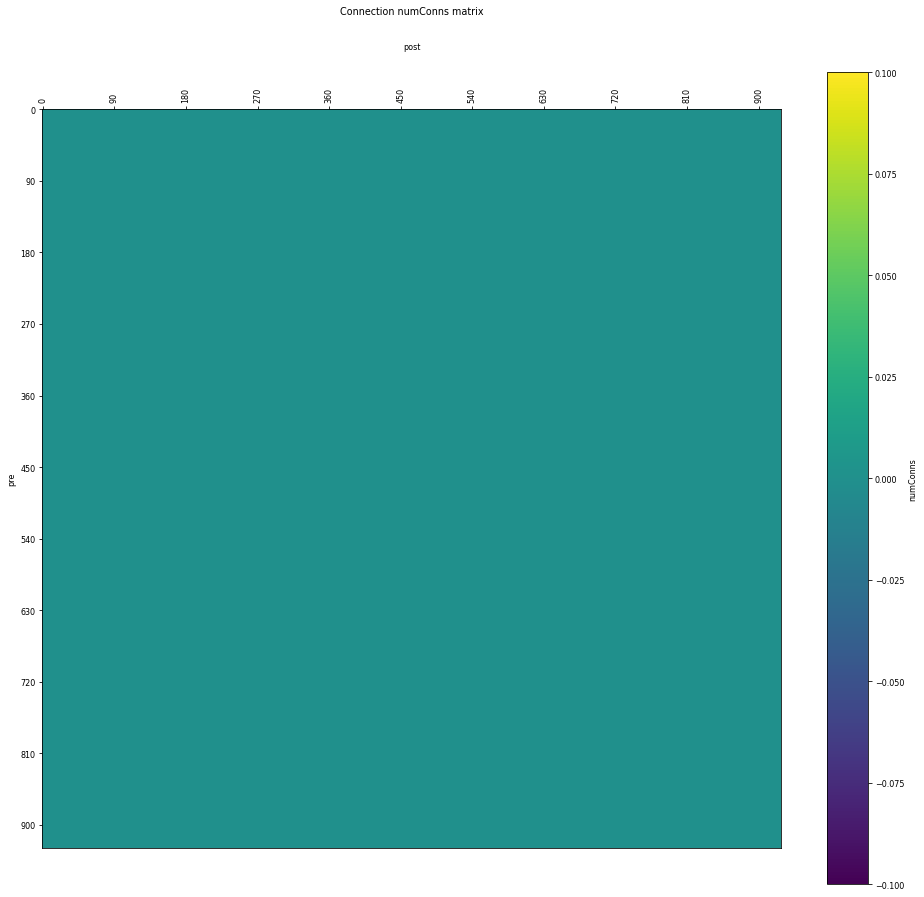

In [ ]:
features = ['numConns'] #,'convergence'
groups =['cell']
for feat in features:
   for group in groups:
        sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature=feat, groupBy=group, figSize=(15,15), orderBy='gid', graphType='matrix', fontSize=8, saveData=None, 
                               saveFig=False, showFig=False);

Plotting connectivity matrix...


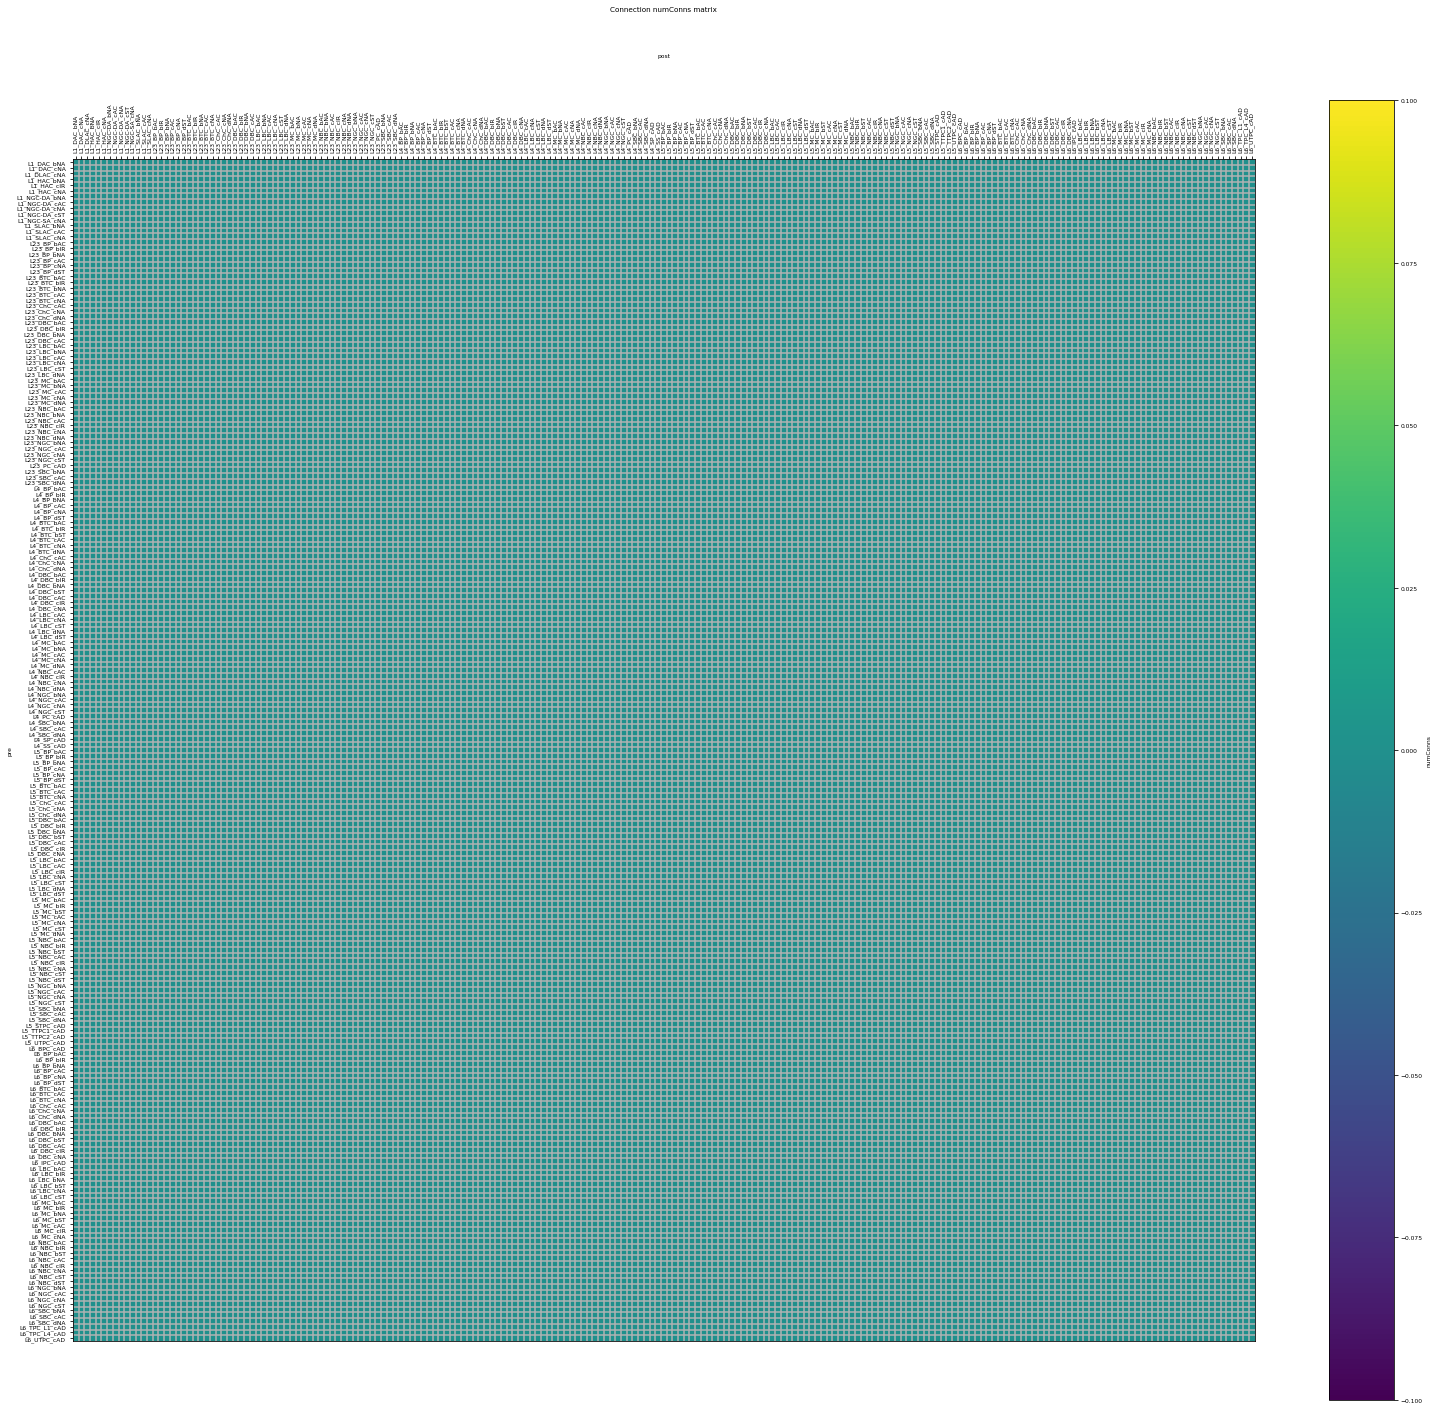

In [ ]:
# features = ['numConns','convergence'] includePre=cfg.allpops, includePost = cfg.allpops,
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(24, 24), fontSize=6, saveData=None, 
                               saveFig=True, showFig=False);

In [ ]:
test[1]['connMatrix'] # total of synapses [AMPA, NMDA] or [GABAA, GABAB]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Plotting 2D representation of network cell locations and connections...


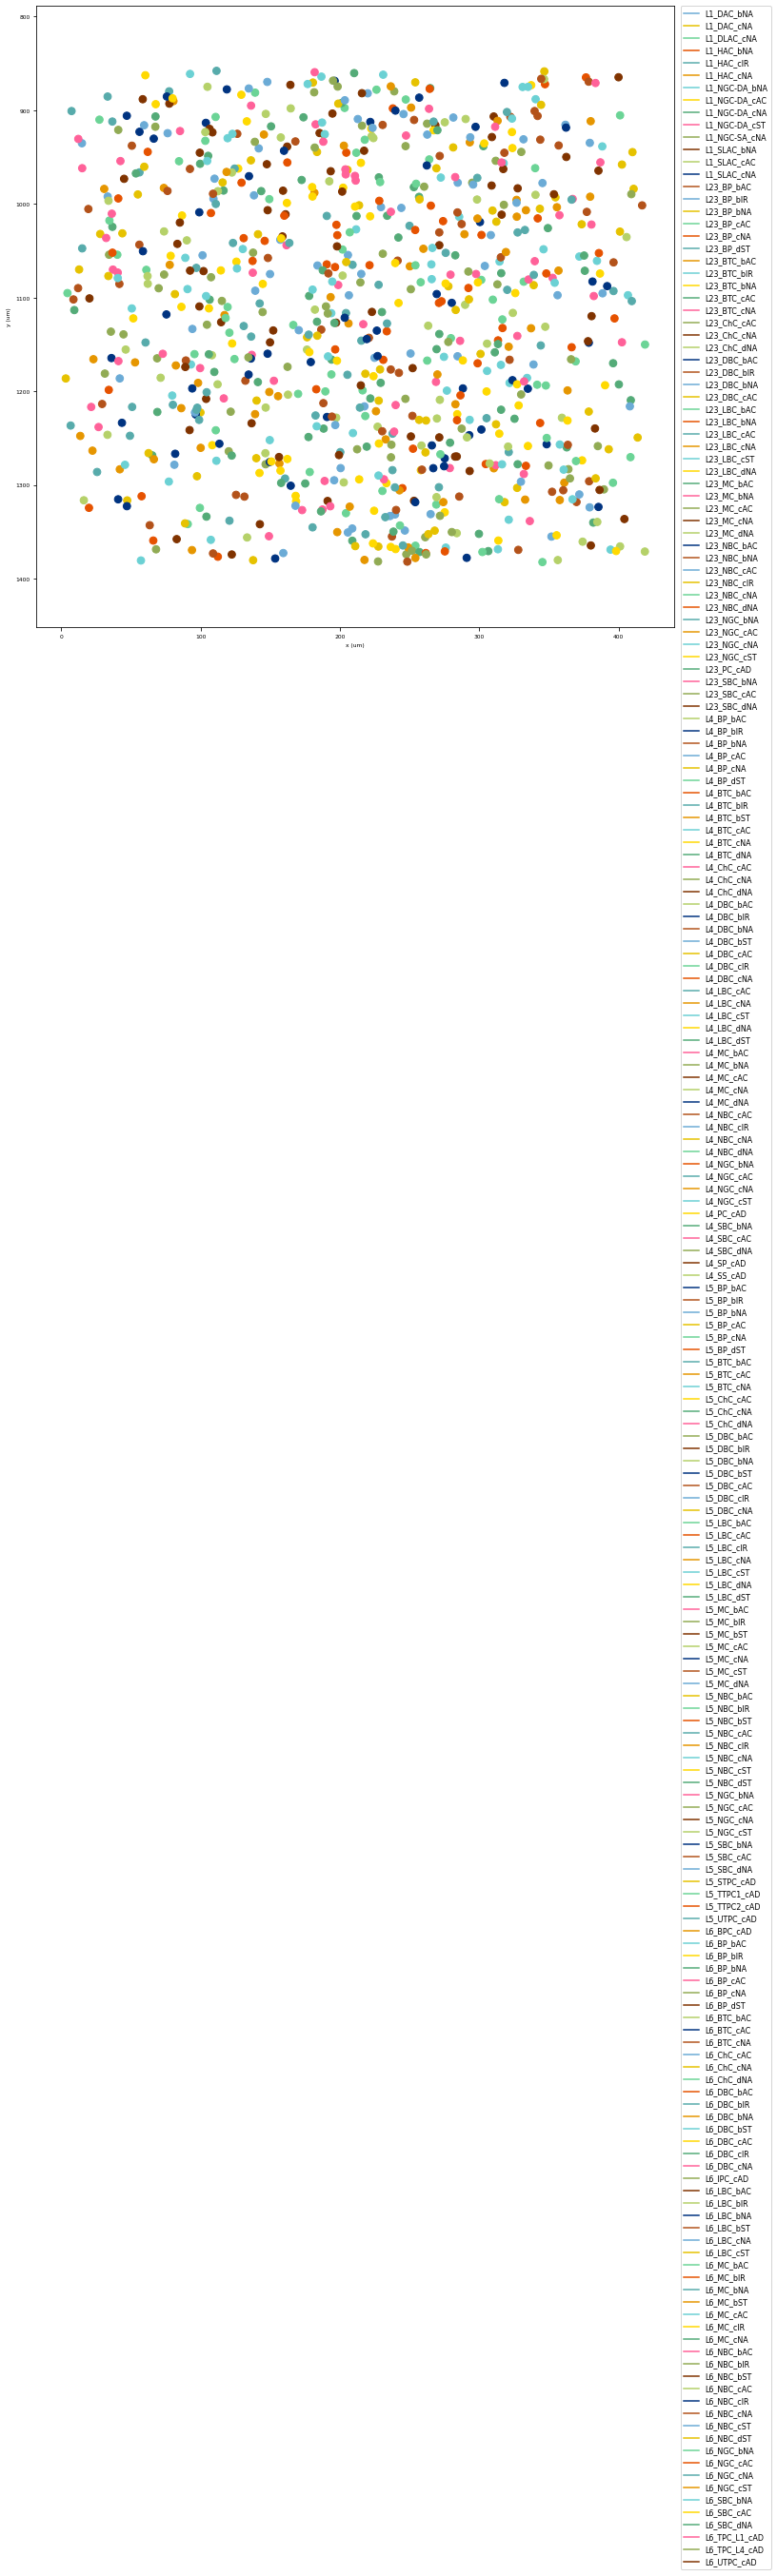

In [ ]:
sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
                               popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
                               saveFig=False, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=subPopLabels,view='xy', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=subPopLabels,view='xz', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

In [ ]:
# include=cfg.allpops, 
sim.analysis.plotRaster(include=cfg.allpops, timeRange=[0,cfg.duration], orderBy='gid', orderInverse=True, labels='legend', popRates=True, lw=5, marker='.', markerSize=24, figSize=(20, 10), fontSize=20, dpi=300, saveFig=True, showFig=False);

Plotting raster...
No spikes available to plot raster


In [ ]:
# cellNumber[metype]
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

# traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
# traces

Plotting recorded cell traces ... trace


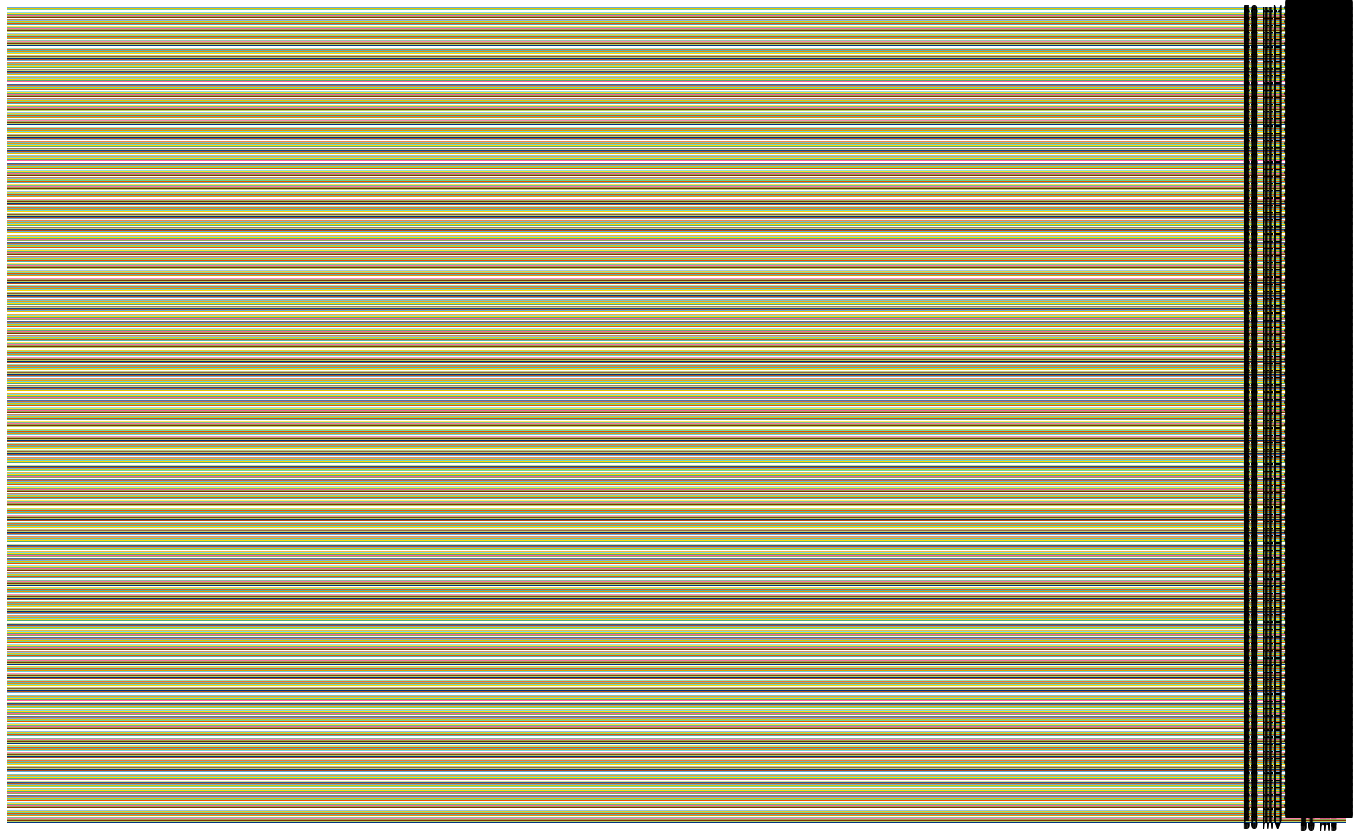

In [ ]:
# include=traces, 
sim.analysis.plotTraces(timeRange=[0,cfg.duration], overlay=False, oneFigPer='trace', ylim=[-90,50], subtitles= False, axis=False, scaleBarLoc=1, figSize=(24, 15), fontSize=12, saveFig=True);



 L1_DAC_bNA   N = 5
Plotting recorded cell traces ... trace


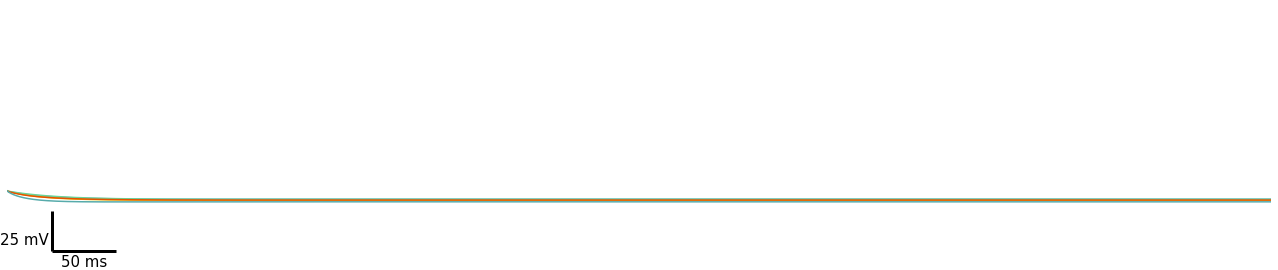



 L1_DAC_cNA   N = 5
Plotting recorded cell traces ... trace


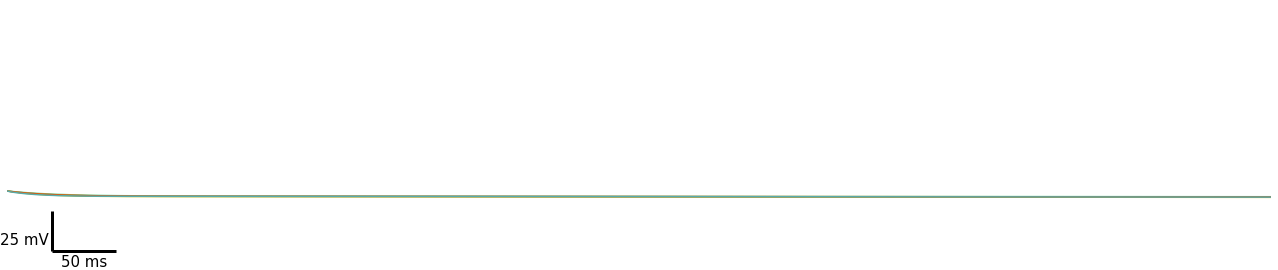



 L1_DLAC_cNA   N = 5
Plotting recorded cell traces ... trace


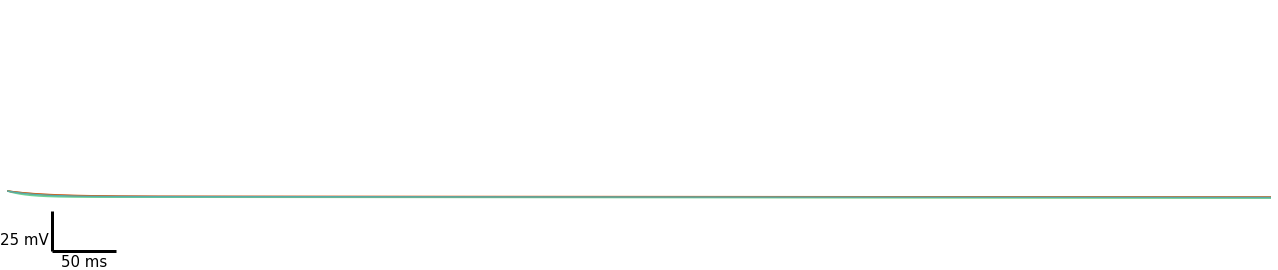



 L1_HAC_bNA   N = 5
Plotting recorded cell traces ... trace


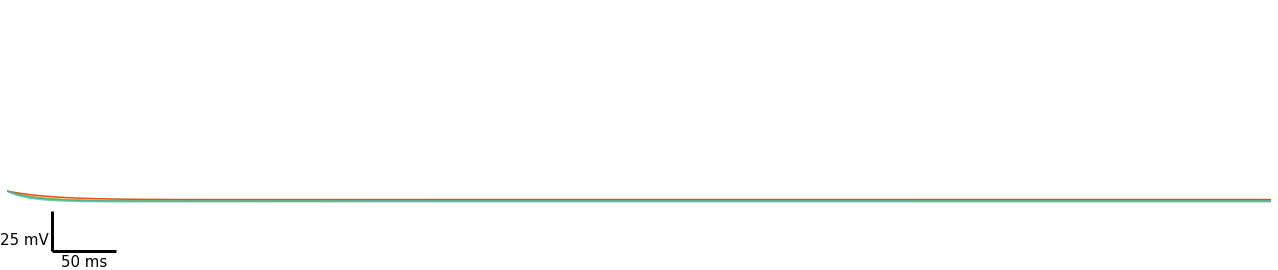



 L1_HAC_cIR   N = 5
Plotting recorded cell traces ... trace


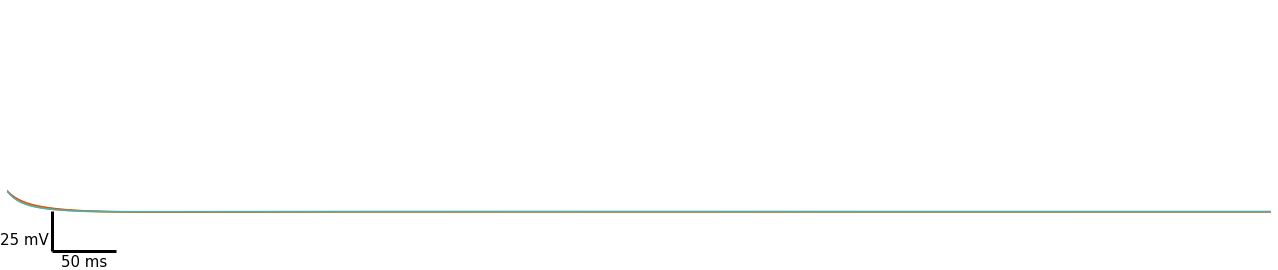



 L1_HAC_cNA   N = 5
Plotting recorded cell traces ... trace


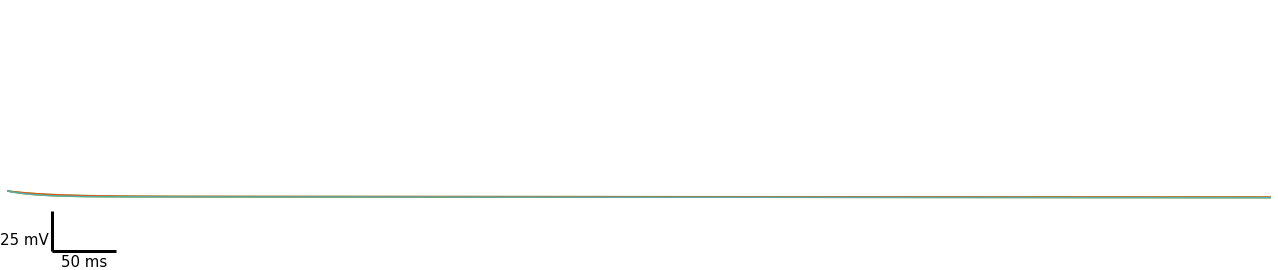



 L1_NGC-DA_bNA   N = 5
Plotting recorded cell traces ... trace


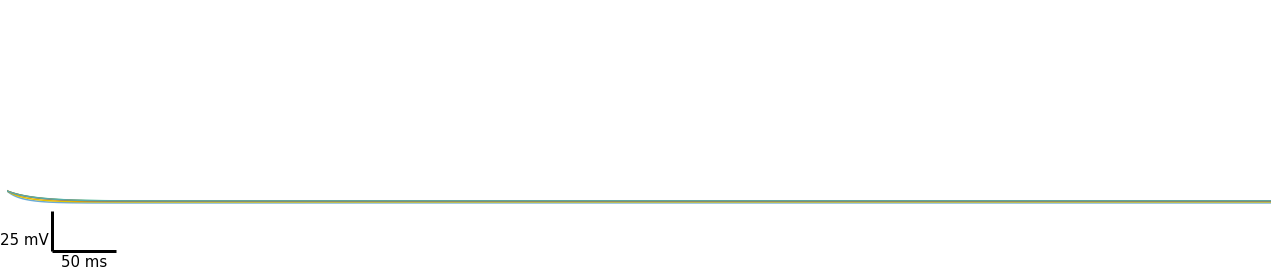



 L1_NGC-DA_cAC   N = 5
Plotting recorded cell traces ... trace


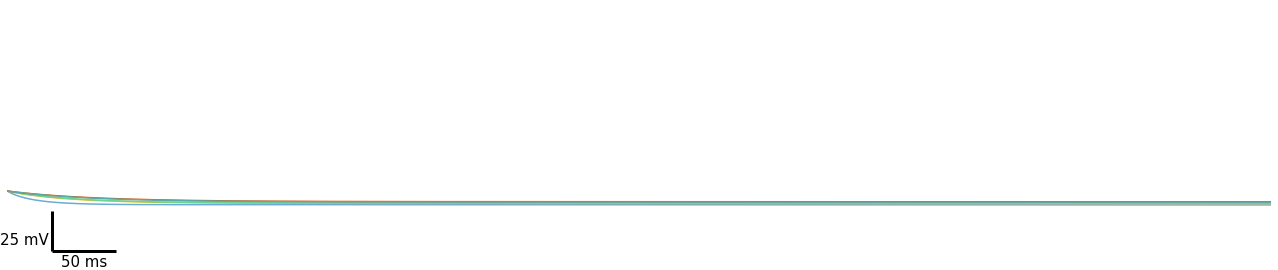



 L1_NGC-DA_cNA   N = 5
Plotting recorded cell traces ... trace


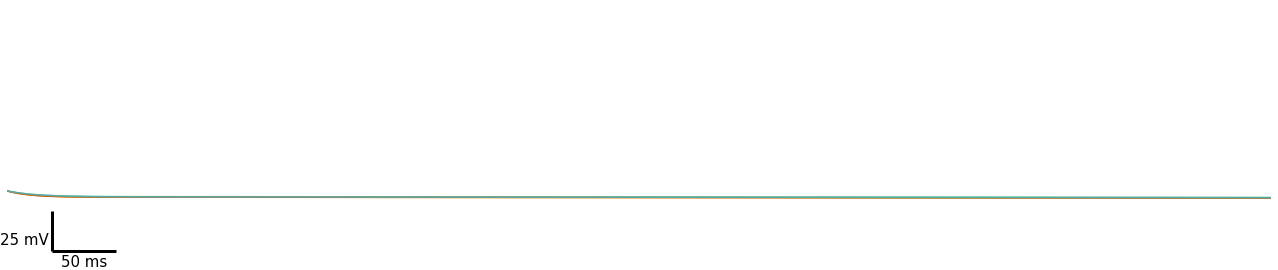



 L1_NGC-DA_cST   N = 5
Plotting recorded cell traces ... trace


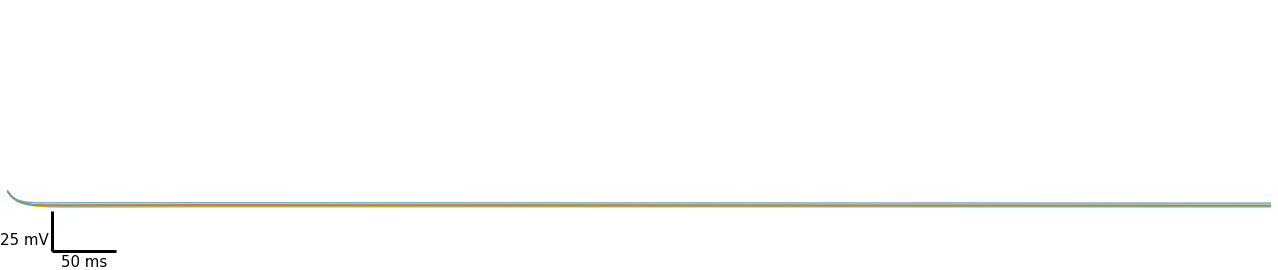



 L1_NGC-SA_cNA   N = 5
Plotting recorded cell traces ... trace


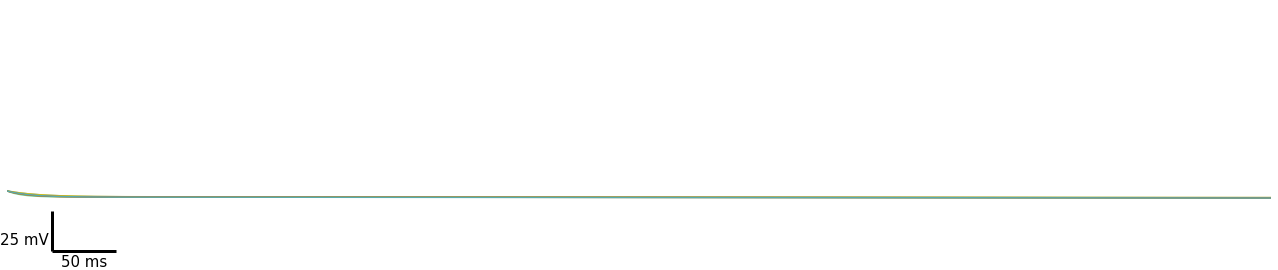



 L1_SLAC_bNA   N = 5
Plotting recorded cell traces ... trace


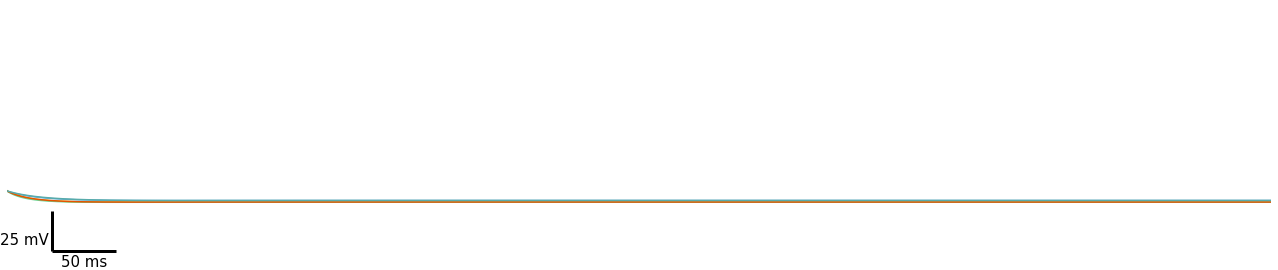



 L1_SLAC_cAC   N = 5
Plotting recorded cell traces ... trace


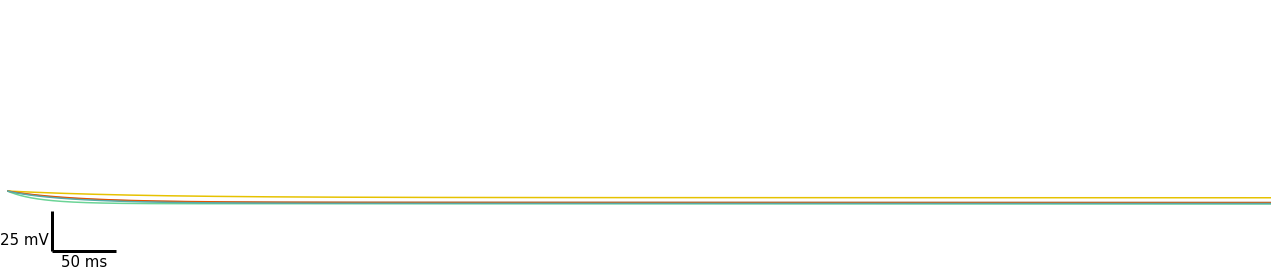



 L1_SLAC_cNA   N = 5
Plotting recorded cell traces ... trace


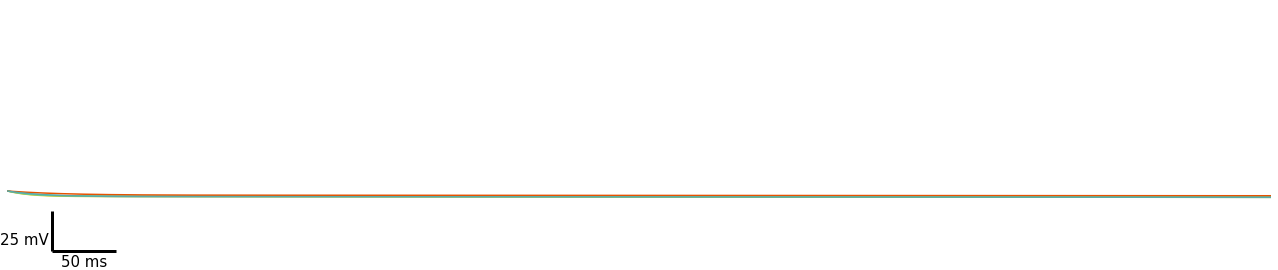



 L23_BP_bAC   N = 3
Plotting recorded cell traces ... trace


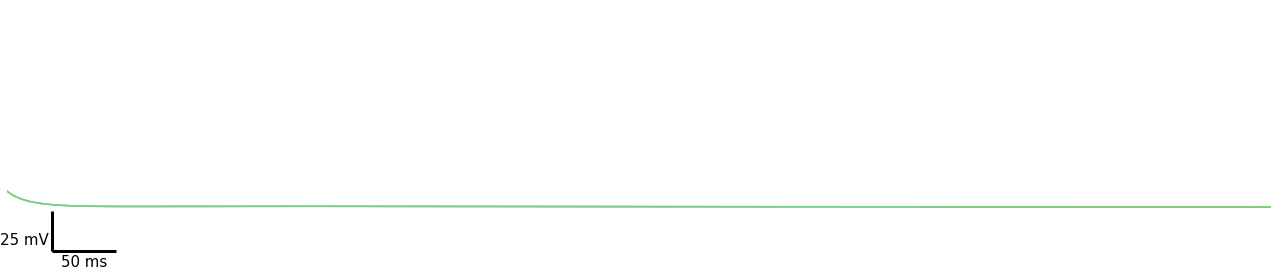



 L23_BP_bIR   N = 4
Plotting recorded cell traces ... trace


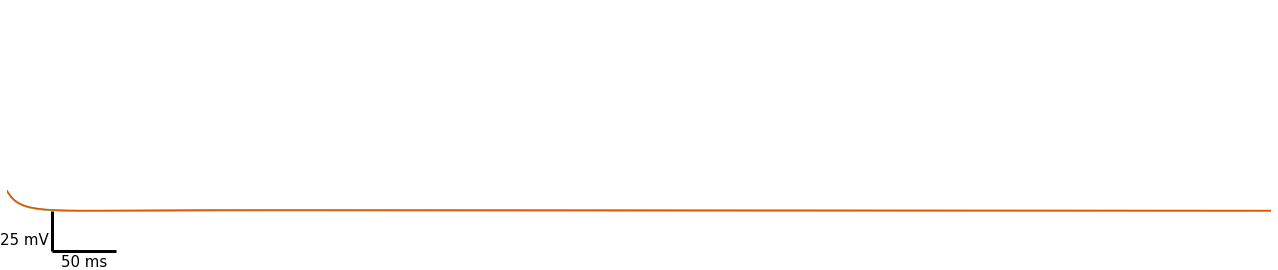



 L23_BP_bNA   N = 5
Plotting recorded cell traces ... trace


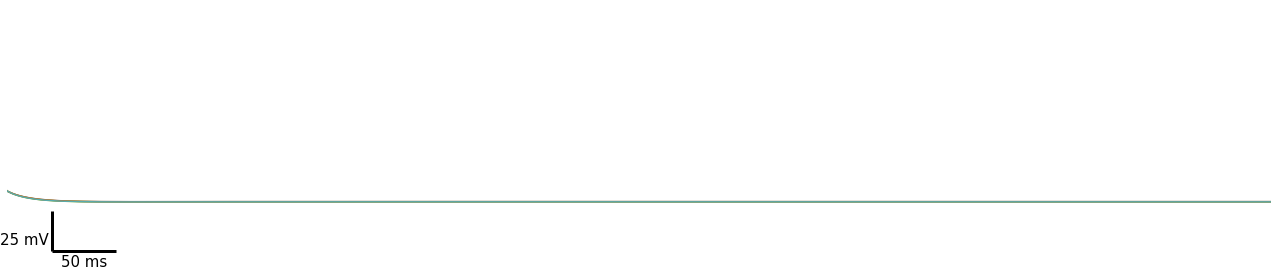



 L23_BP_cAC   N = 5
Plotting recorded cell traces ... trace


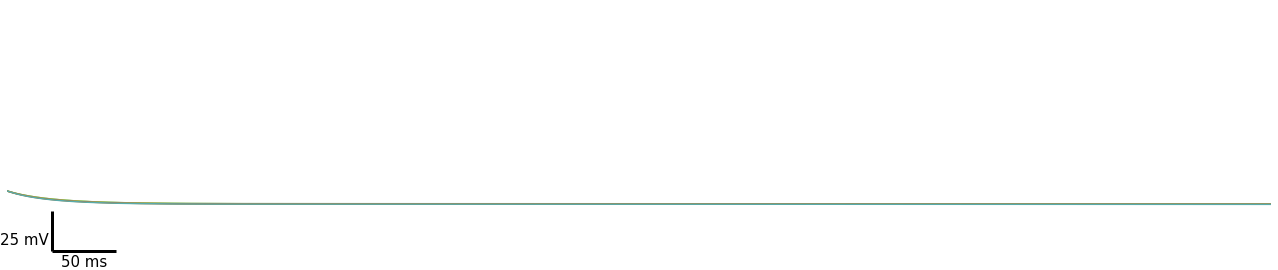



 L23_BP_cNA   N = 4
Plotting recorded cell traces ... trace


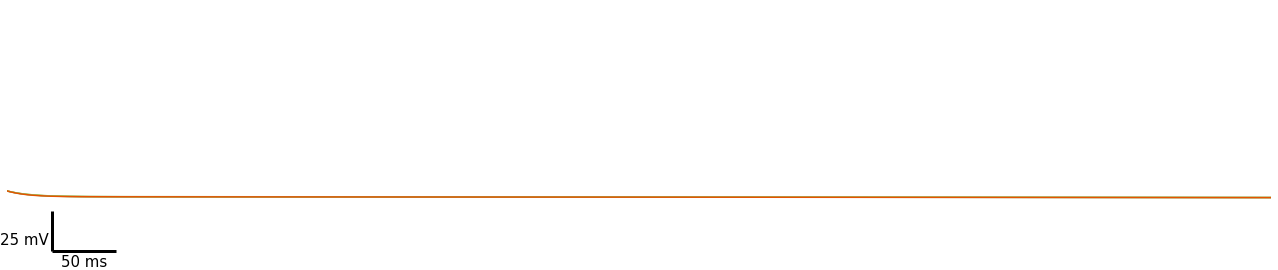



 L23_BP_dST   N = 3
Plotting recorded cell traces ... trace


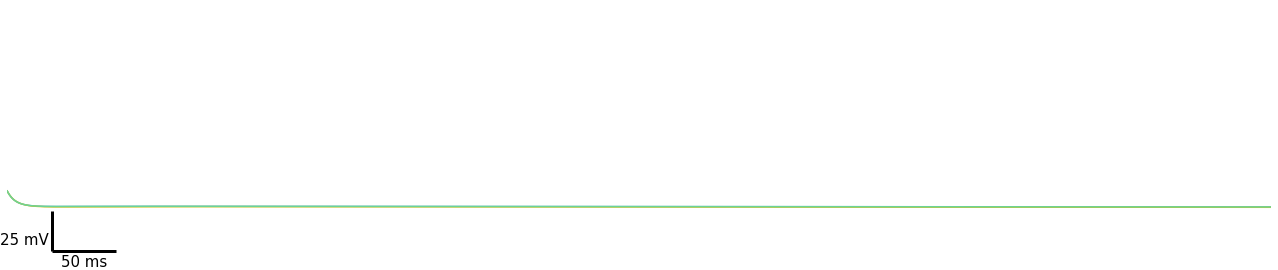



 L23_BTC_bAC   N = 5
Plotting recorded cell traces ... trace


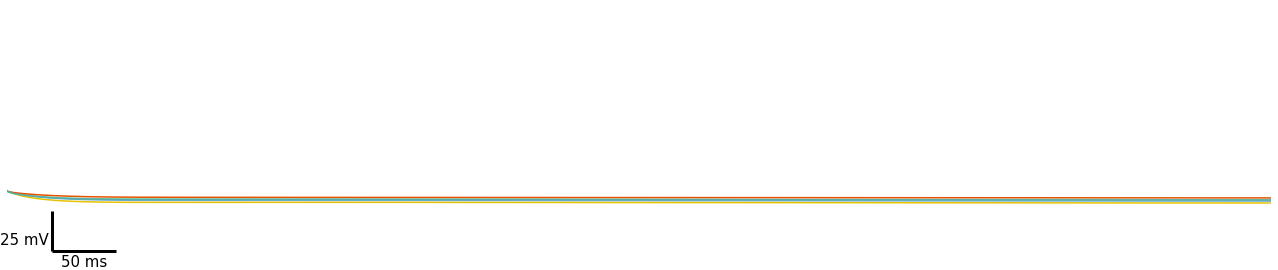



 L23_BTC_bIR   N = 5
Plotting recorded cell traces ... trace


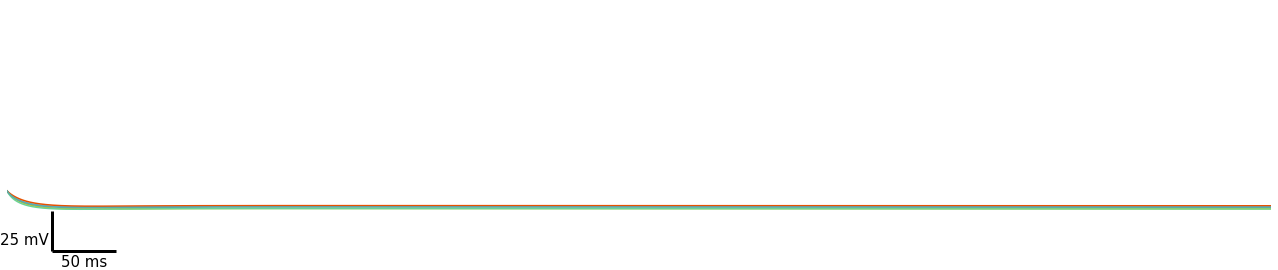



 L23_BTC_bNA   N = 5
Plotting recorded cell traces ... trace


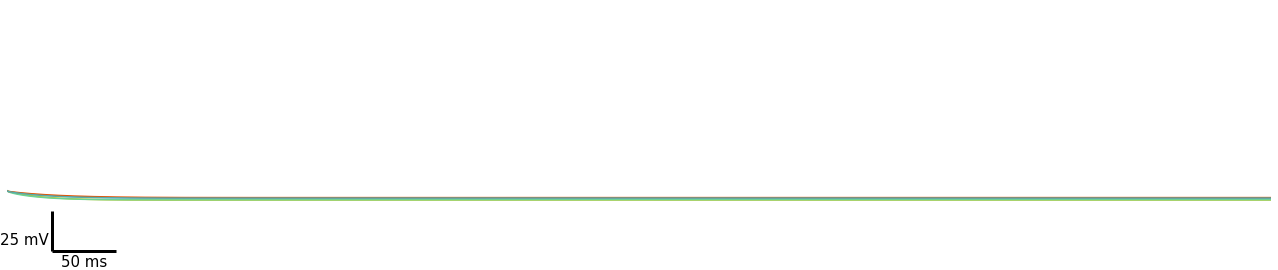



 L23_BTC_cAC   N = 5
Plotting recorded cell traces ... trace


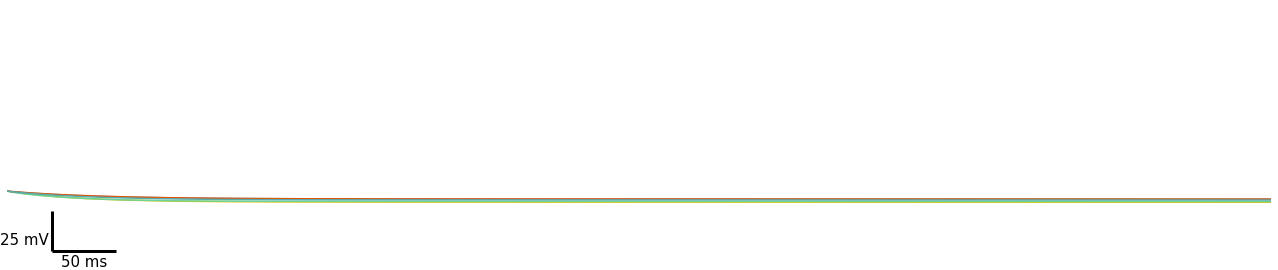



 L23_BTC_cNA   N = 5
Plotting recorded cell traces ... trace


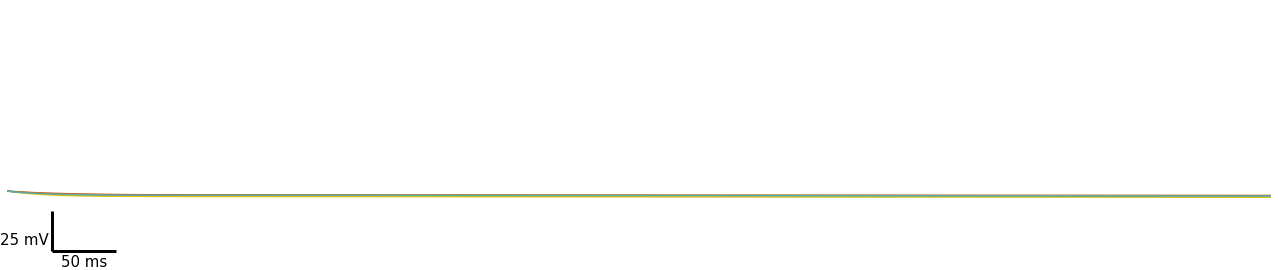



 L23_ChC_cAC   N = 5
Plotting recorded cell traces ... trace


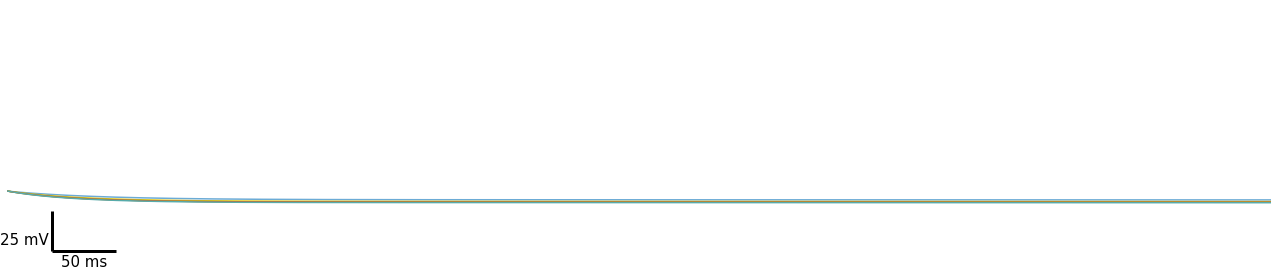



 L23_ChC_cNA   N = 5
Plotting recorded cell traces ... trace


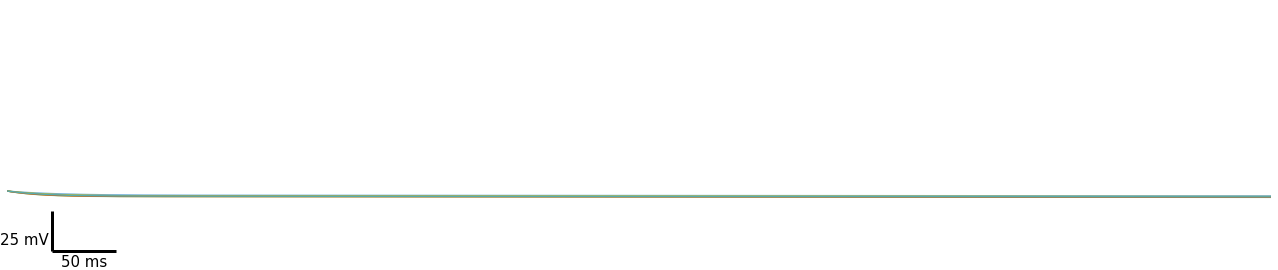



 L23_ChC_dNA   N = 5
Plotting recorded cell traces ... trace


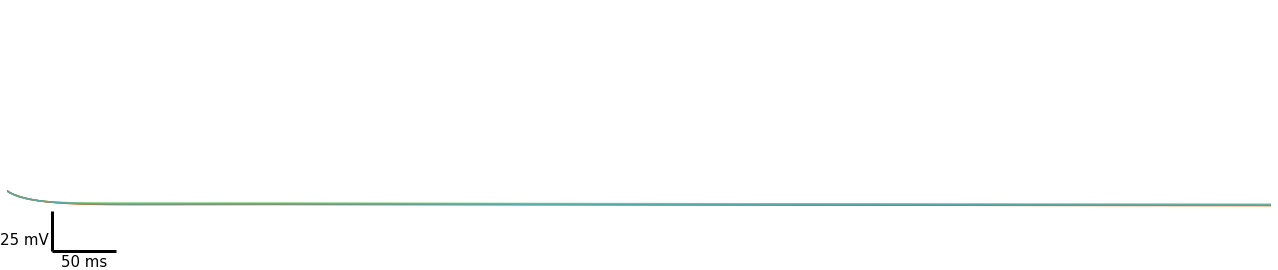



 L23_DBC_bAC   N = 5
Plotting recorded cell traces ... trace


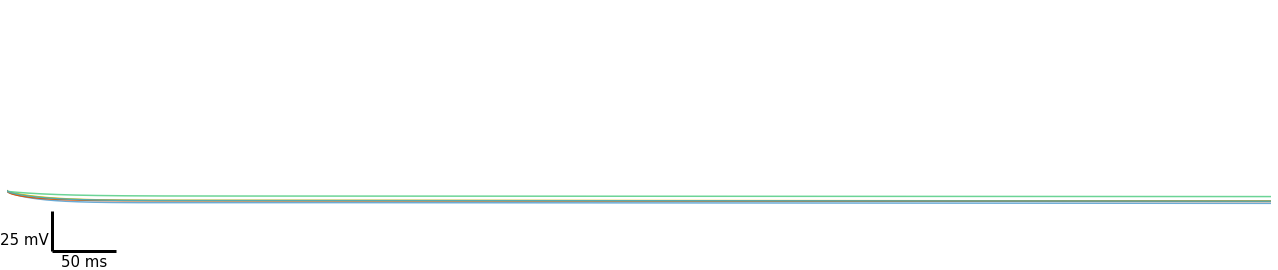



 L23_DBC_bIR   N = 5
Plotting recorded cell traces ... trace


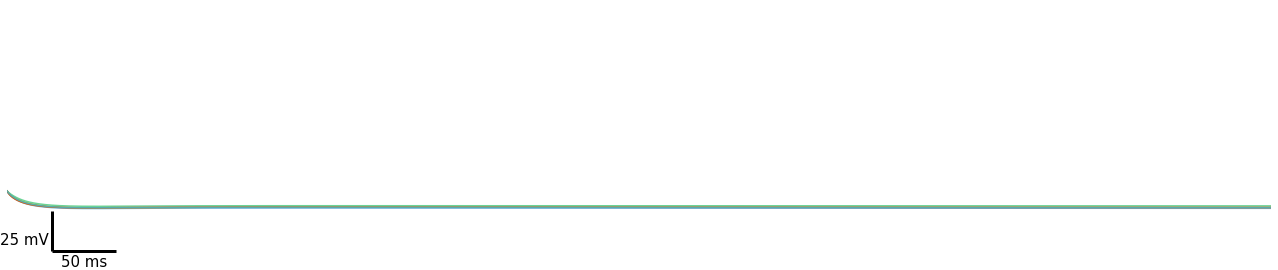



 L23_DBC_bNA   N = 5
Plotting recorded cell traces ... trace


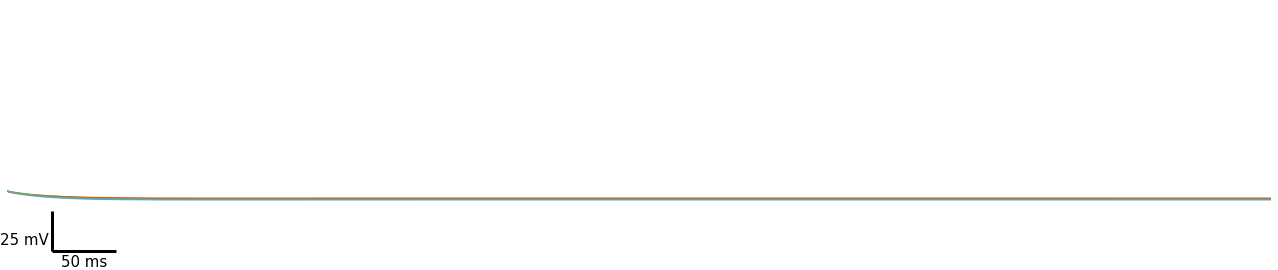



 L23_DBC_cAC   N = 5
Plotting recorded cell traces ... trace


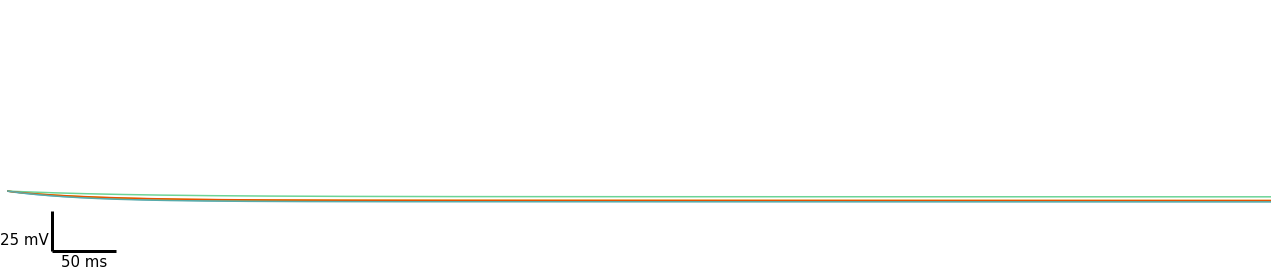



 L23_LBC_bAC   N = 5
Plotting recorded cell traces ... trace


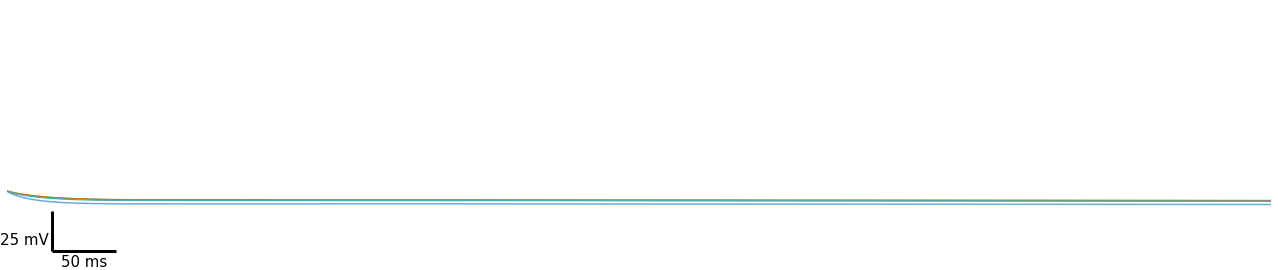



 L23_LBC_bNA   N = 5
Plotting recorded cell traces ... trace


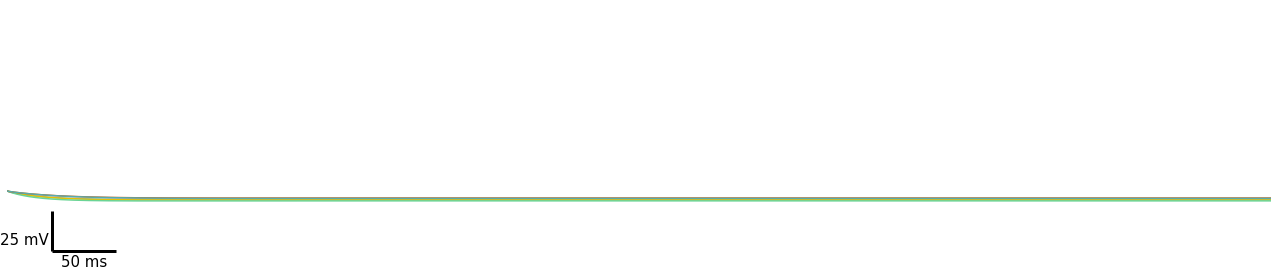



 L23_LBC_cAC   N = 5
Plotting recorded cell traces ... trace


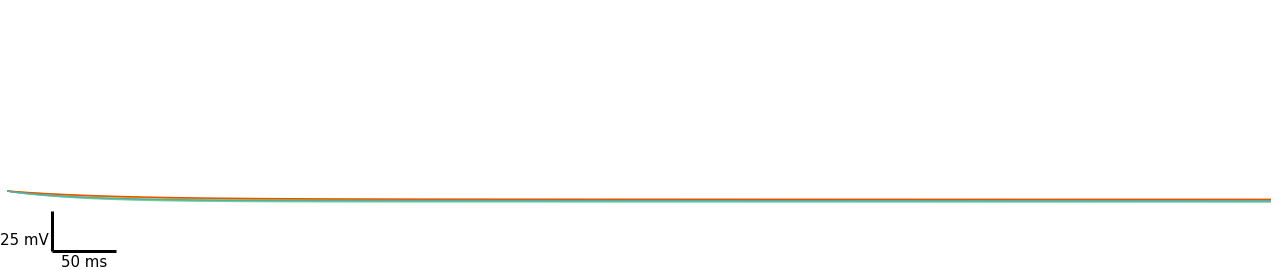



 L23_LBC_cNA   N = 5
Plotting recorded cell traces ... trace


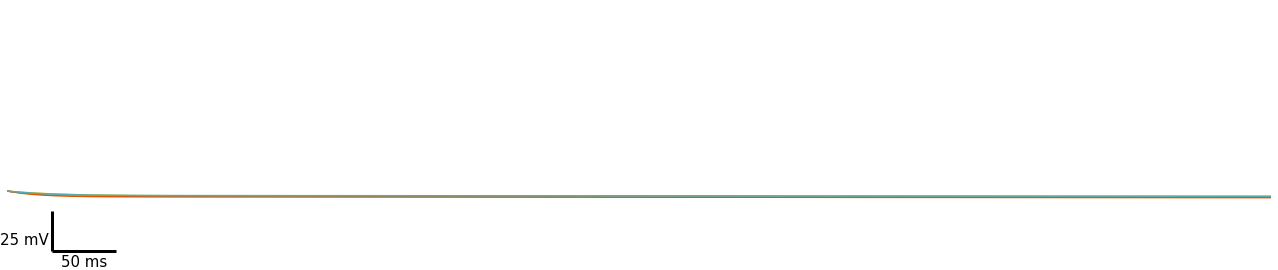



 L23_LBC_cST   N = 5
Plotting recorded cell traces ... trace


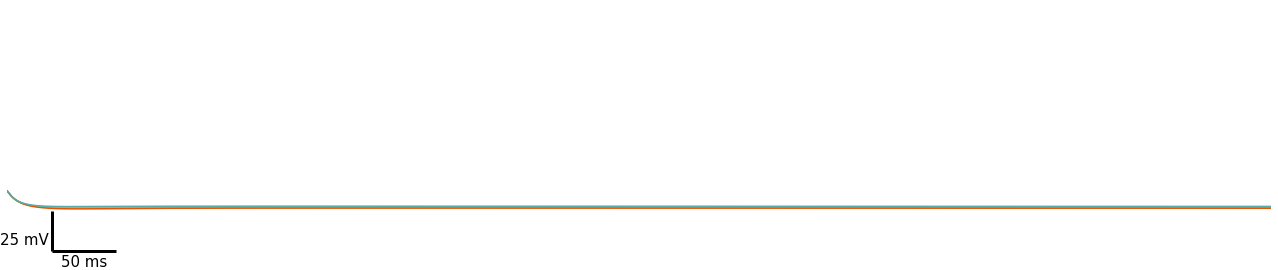



 L23_LBC_dNA   N = 5
Plotting recorded cell traces ... trace


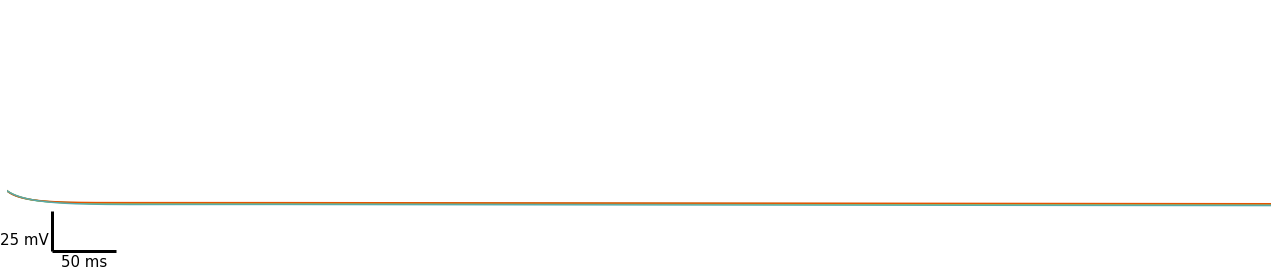



 L23_MC_bAC   N = 5
Plotting recorded cell traces ... trace


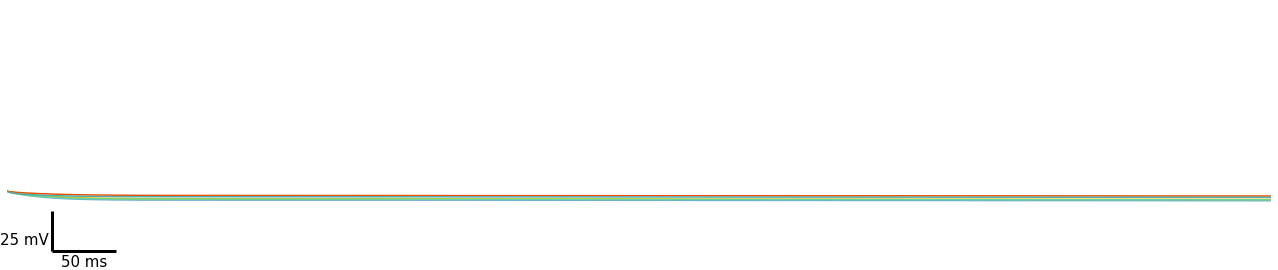



 L23_MC_bNA   N = 5
Plotting recorded cell traces ... trace


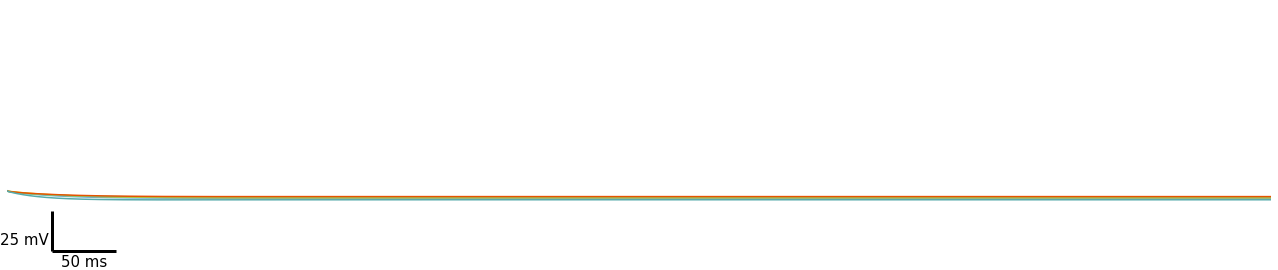



 L23_MC_cAC   N = 5
Plotting recorded cell traces ... trace


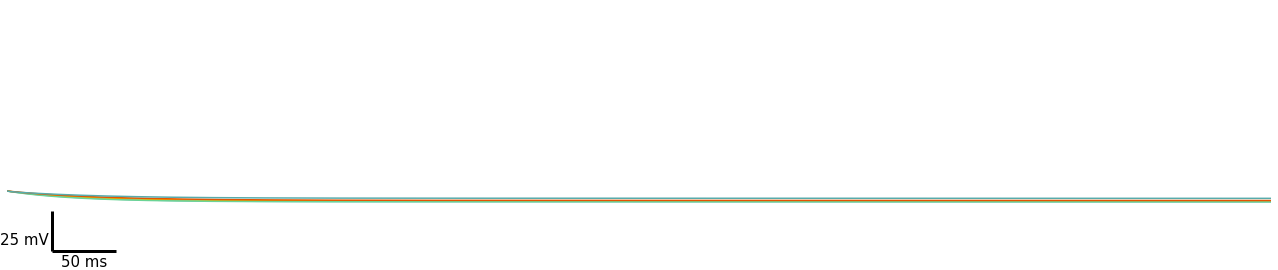



 L23_MC_cNA   N = 5
Plotting recorded cell traces ... trace


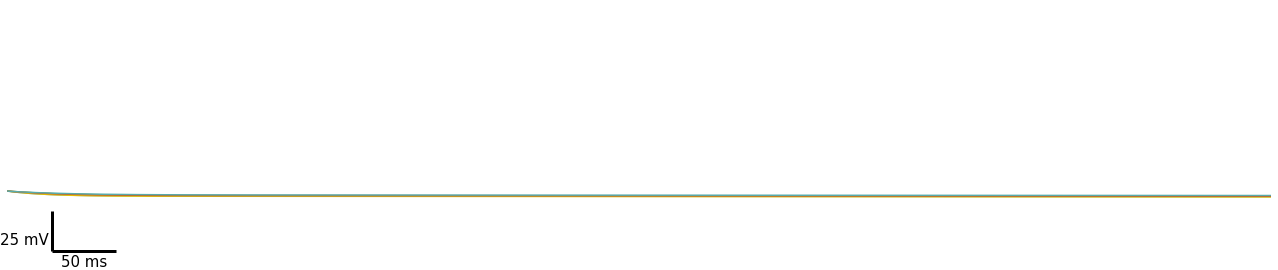



 L23_MC_dNA   N = 5
Plotting recorded cell traces ... trace


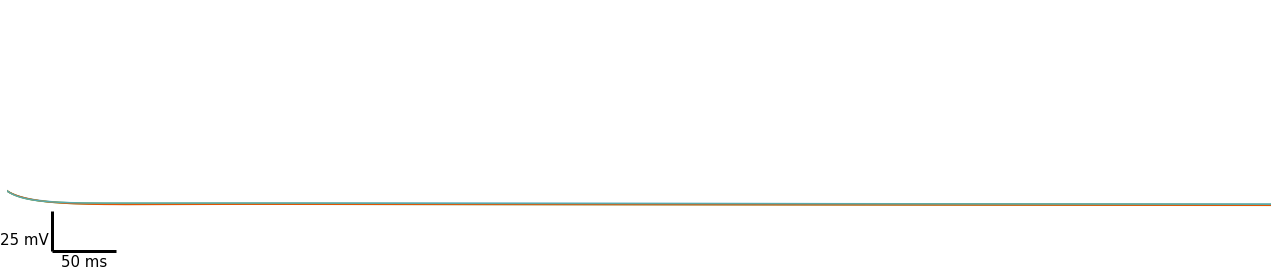



 L23_NBC_bAC   N = 5
Plotting recorded cell traces ... trace


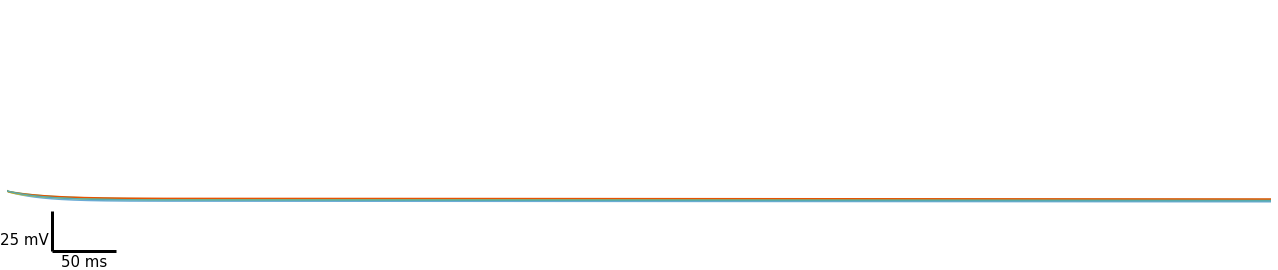



 L23_NBC_bNA   N = 5
Plotting recorded cell traces ... trace


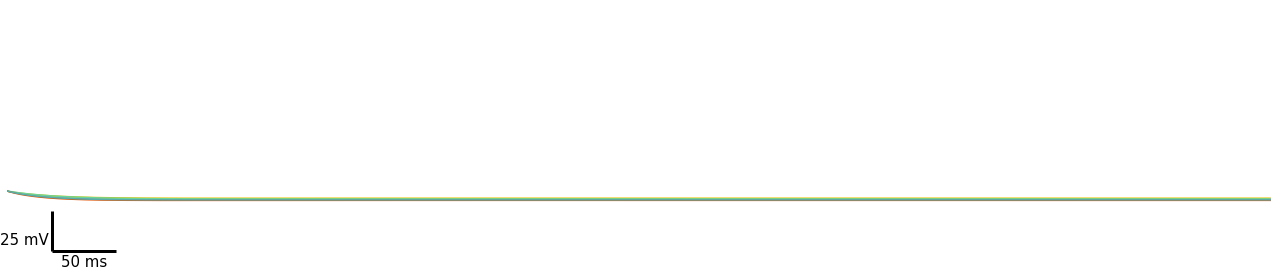



 L23_NBC_cAC   N = 5
Plotting recorded cell traces ... trace


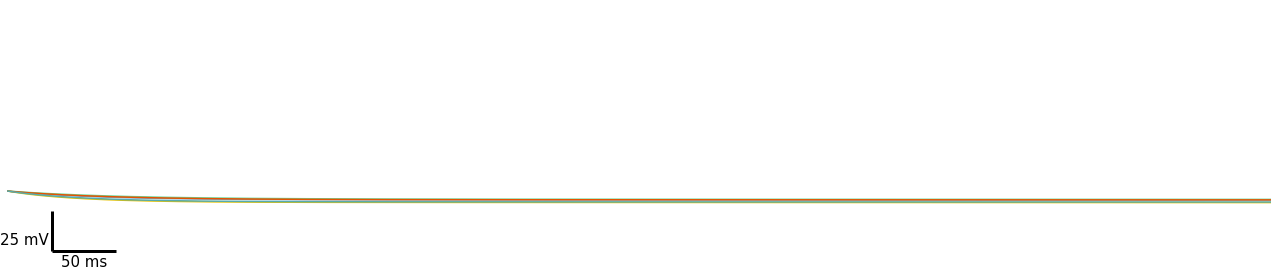



 L23_NBC_cIR   N = 5
Plotting recorded cell traces ... trace


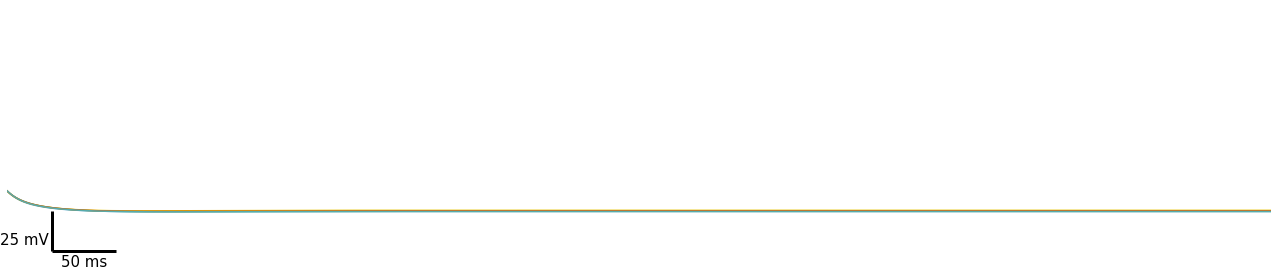



 L23_NBC_cNA   N = 5
Plotting recorded cell traces ... trace


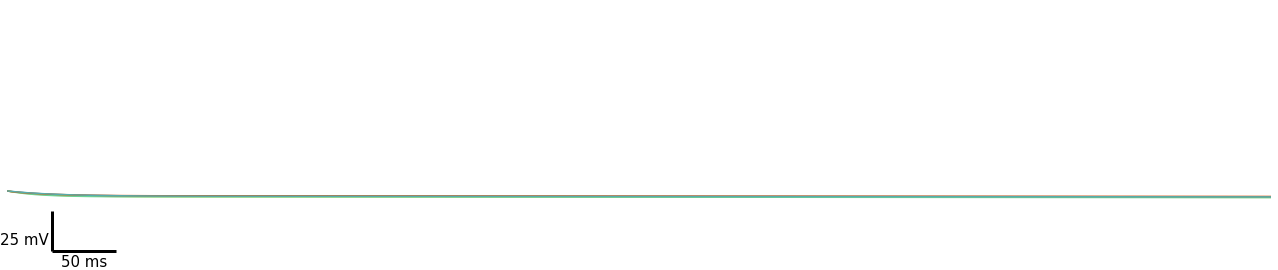



 L23_NBC_dNA   N = 5
Plotting recorded cell traces ... trace


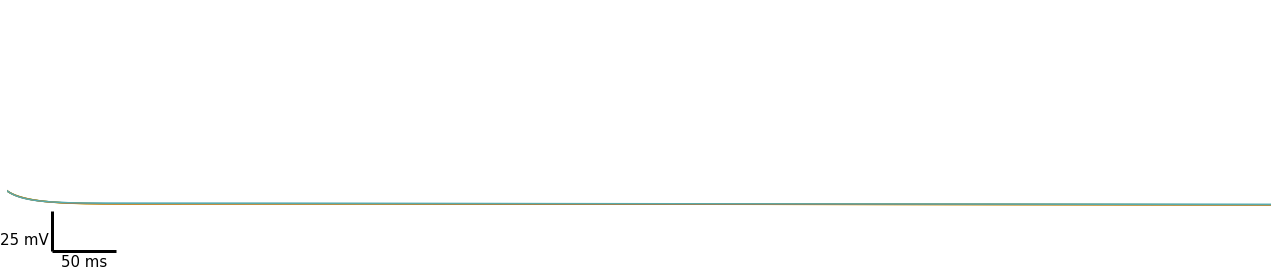



 L23_NGC_bNA   N = 5
Plotting recorded cell traces ... trace


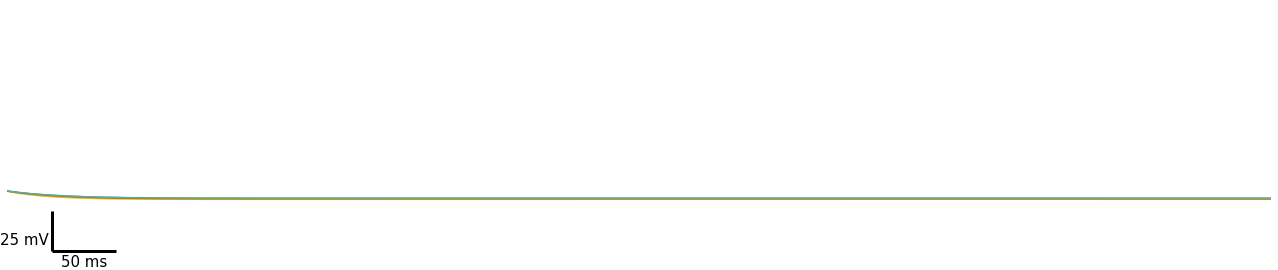



 L23_NGC_cAC   N = 5
Plotting recorded cell traces ... trace


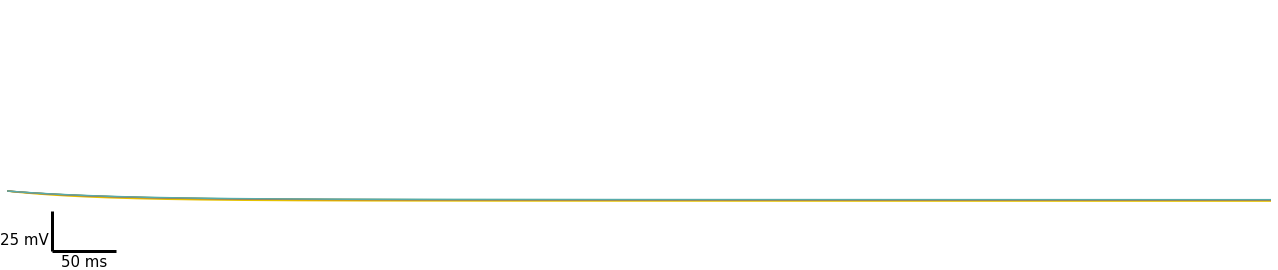



 L23_NGC_cNA   N = 5
Plotting recorded cell traces ... trace


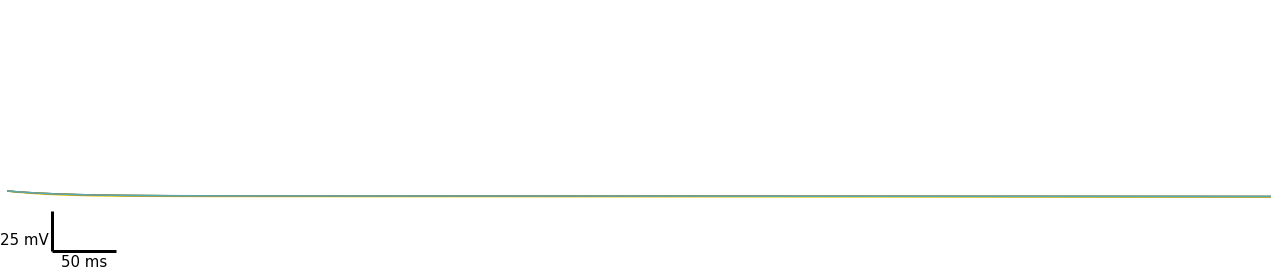



 L23_NGC_cST   N = 5
Plotting recorded cell traces ... trace


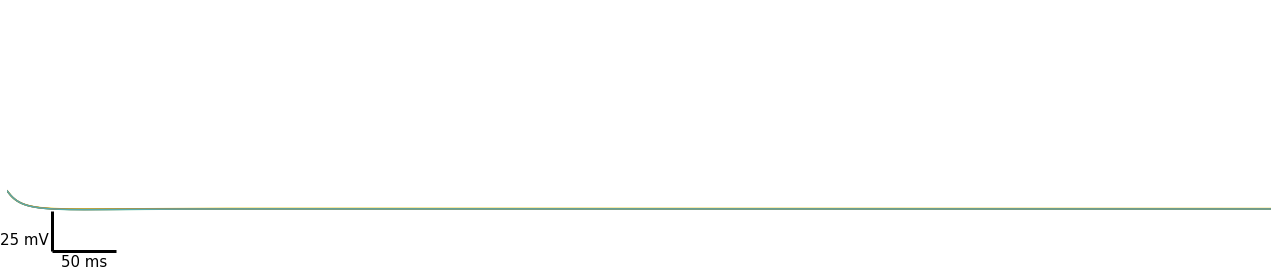



 L23_PC_cAD   N = 5
Plotting recorded cell traces ... trace


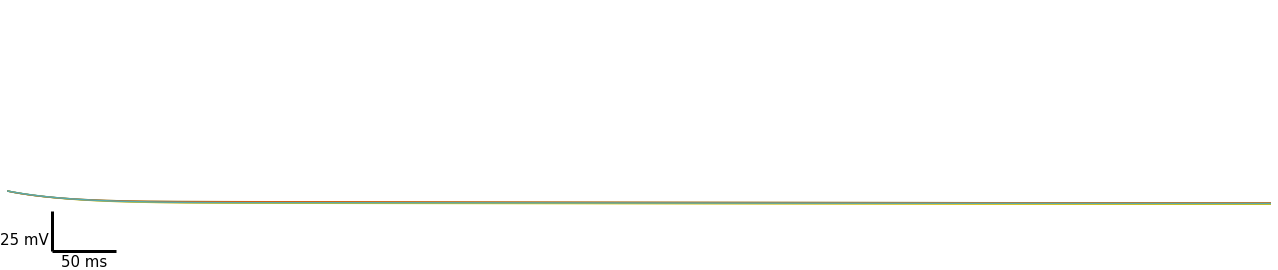



 L23_SBC_bNA   N = 5
Plotting recorded cell traces ... trace


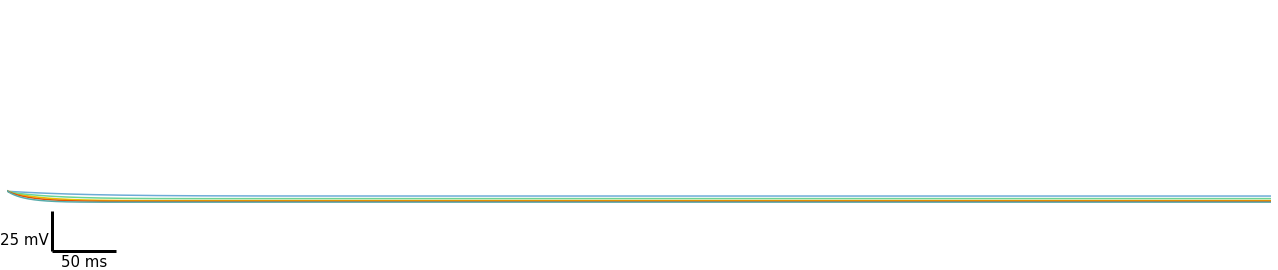



 L23_SBC_cAC   N = 5
Plotting recorded cell traces ... trace


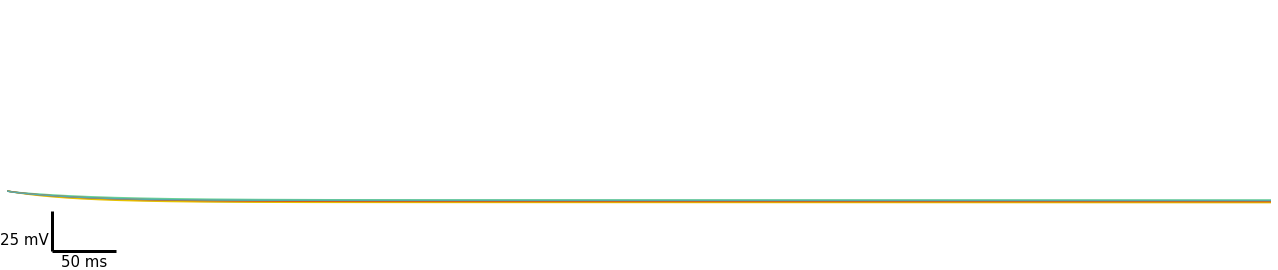



 L23_SBC_dNA   N = 5
Plotting recorded cell traces ... trace


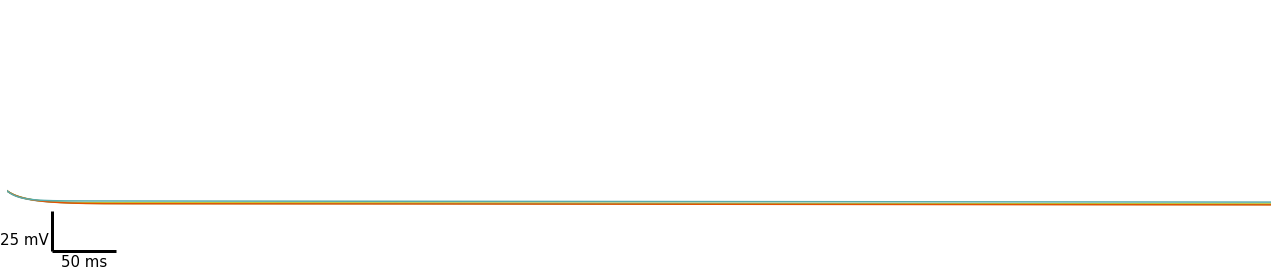



 L4_BP_bAC   N = 1
Plotting recorded cell traces ... trace


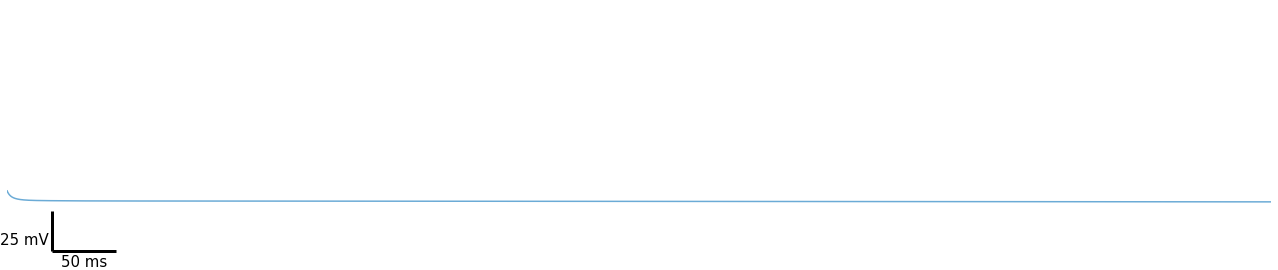



 L4_BP_bIR   N = 1
Plotting recorded cell traces ... trace


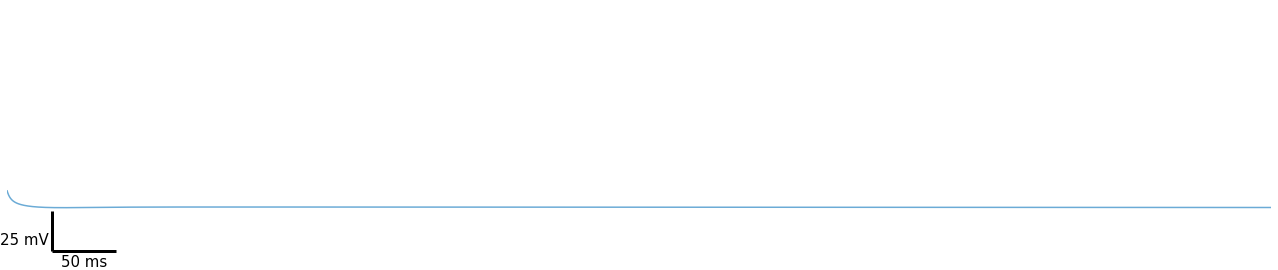



 L4_BP_bNA   N = 2
Plotting recorded cell traces ... trace


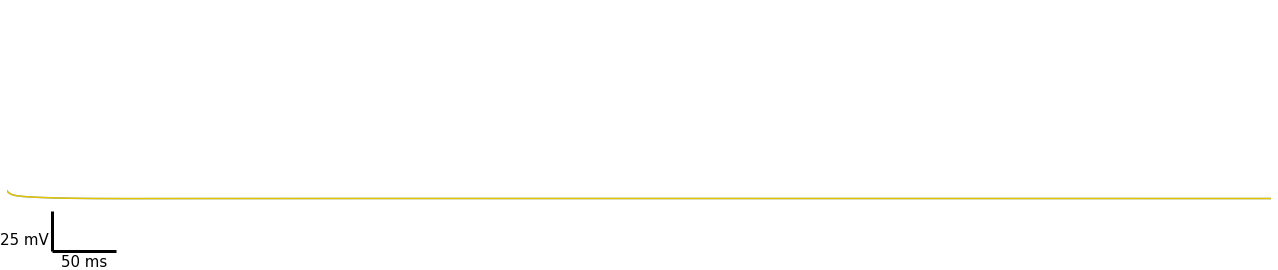



 L4_BP_cAC   N = 2
Plotting recorded cell traces ... trace


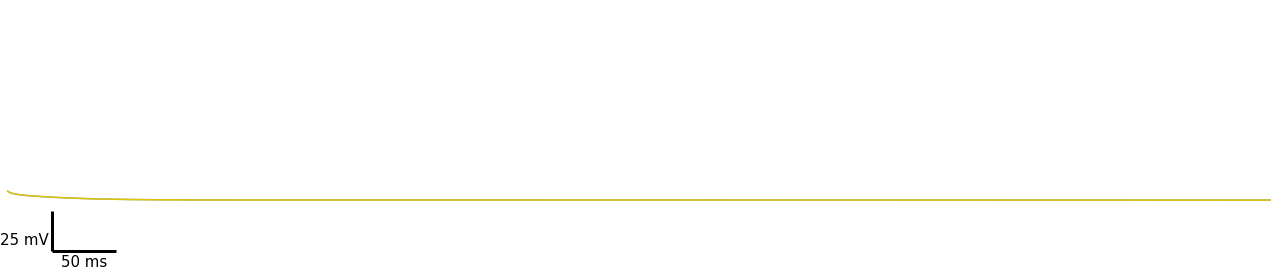



 L4_BP_cNA   N = 1
Plotting recorded cell traces ... trace


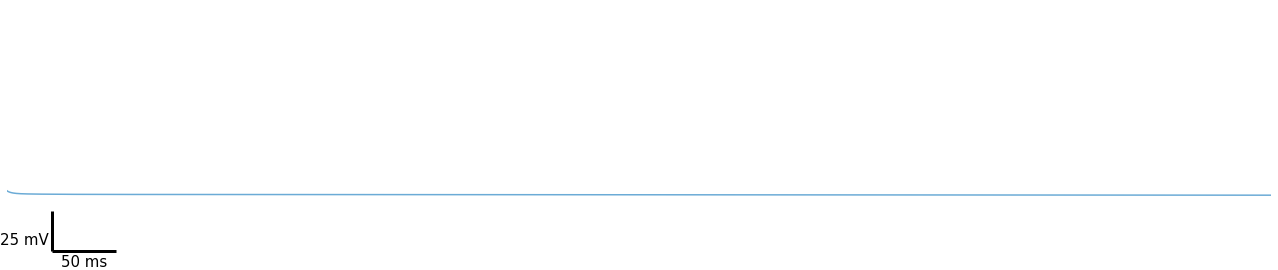



 L4_BP_dST   N = 1
Plotting recorded cell traces ... trace


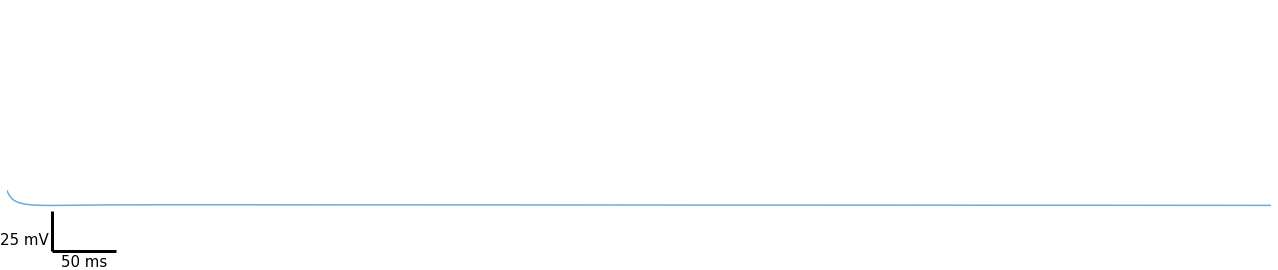



 L4_BTC_bAC   N = 2
Plotting recorded cell traces ... trace


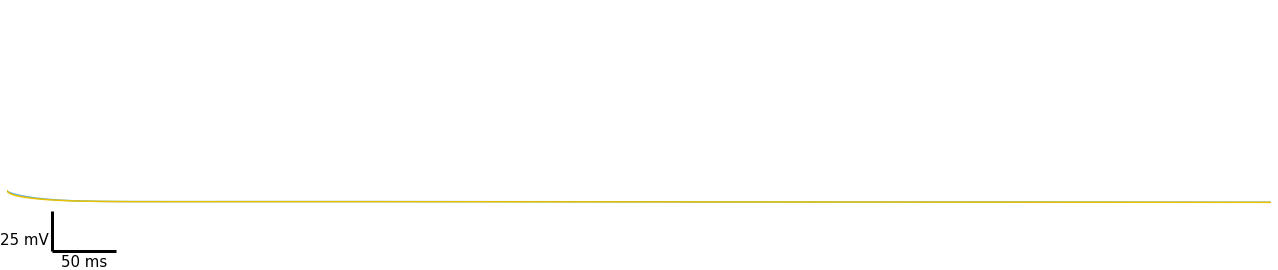



 L4_BTC_bIR   N = 2
Plotting recorded cell traces ... trace


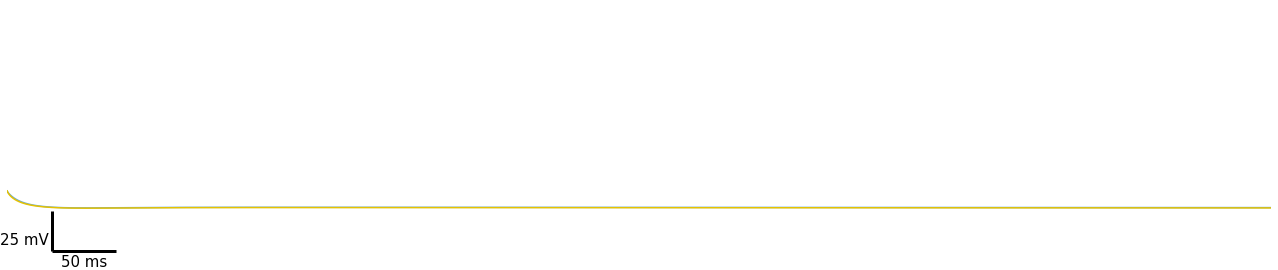



 L4_BTC_bST   N = 2
Plotting recorded cell traces ... trace


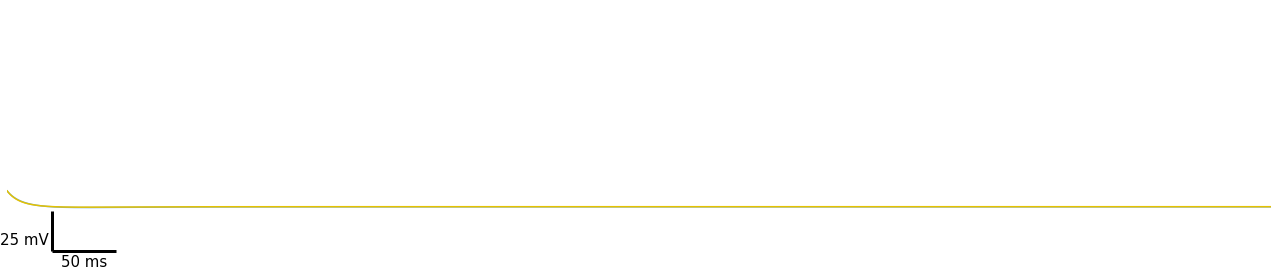



 L4_BTC_cAC   N = 5
Plotting recorded cell traces ... trace


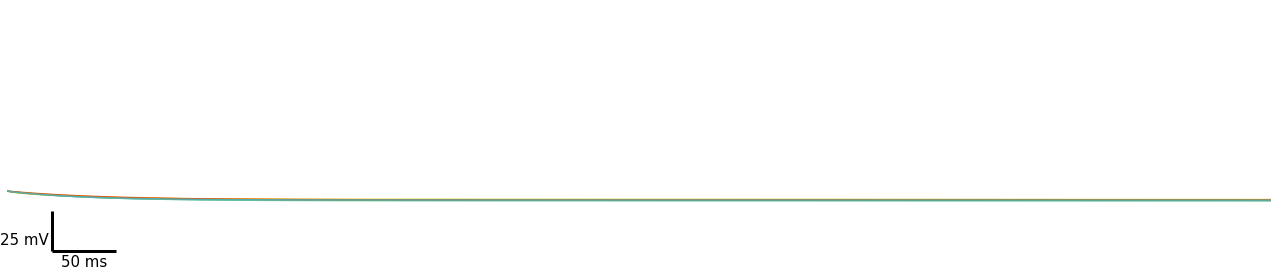



 L4_BTC_cNA   N = 3
Plotting recorded cell traces ... trace


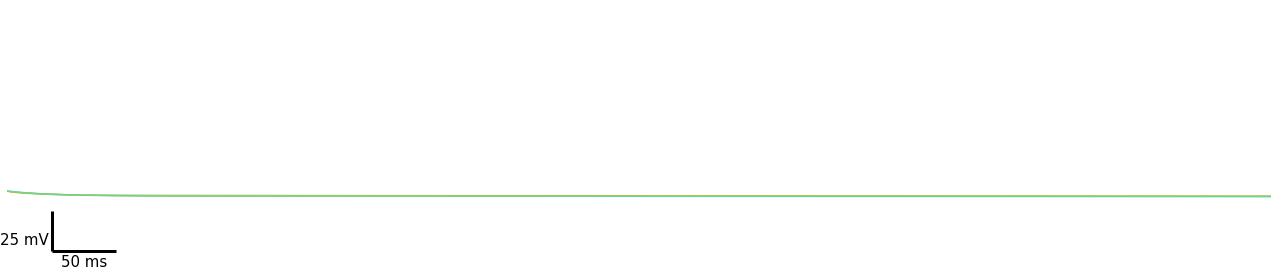



 L4_BTC_dNA   N = 2
Plotting recorded cell traces ... trace


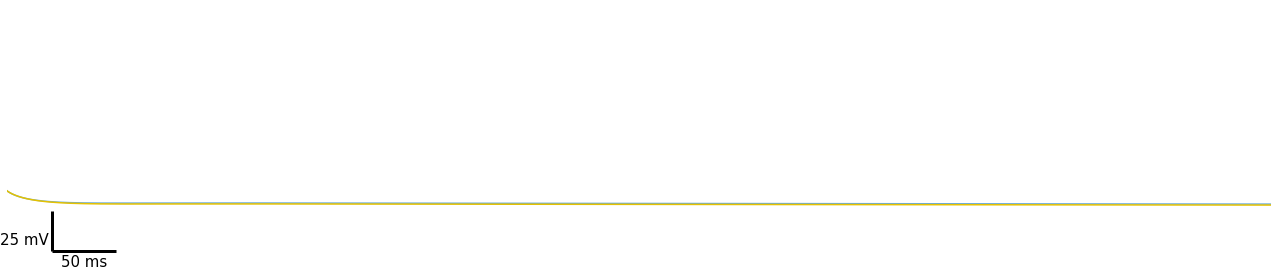



 L4_ChC_cAC   N = 3
Plotting recorded cell traces ... trace


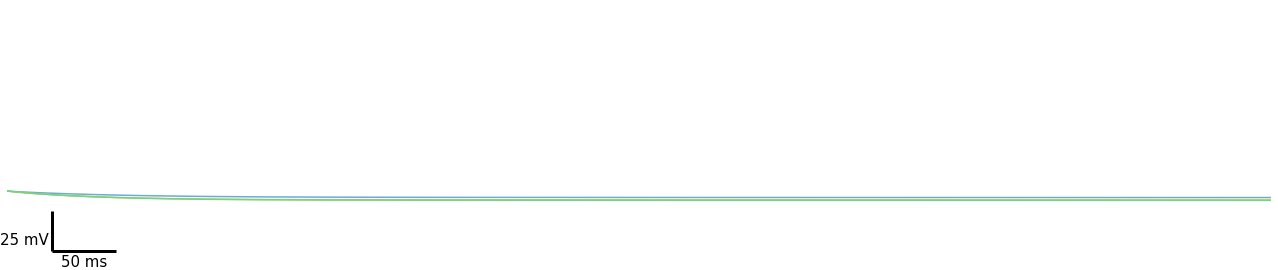



 L4_ChC_cNA   N = 3
Plotting recorded cell traces ... trace


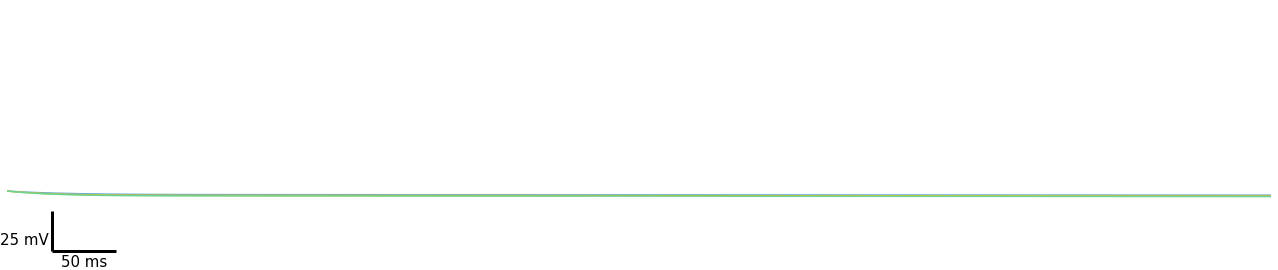



 L4_ChC_dNA   N = 2
Plotting recorded cell traces ... trace


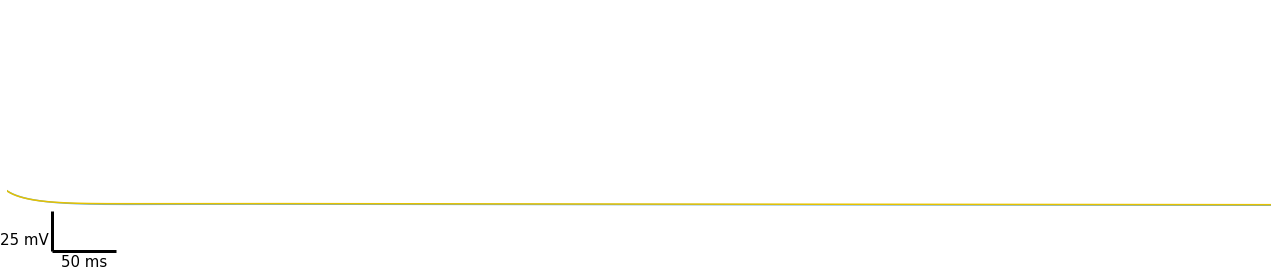



 L4_DBC_bAC   N = 4
Plotting recorded cell traces ... trace


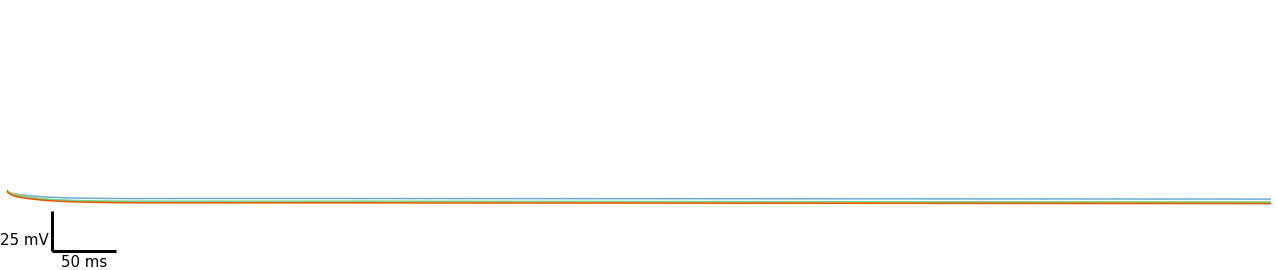



 L4_DBC_bIR   N = 5
Plotting recorded cell traces ... trace


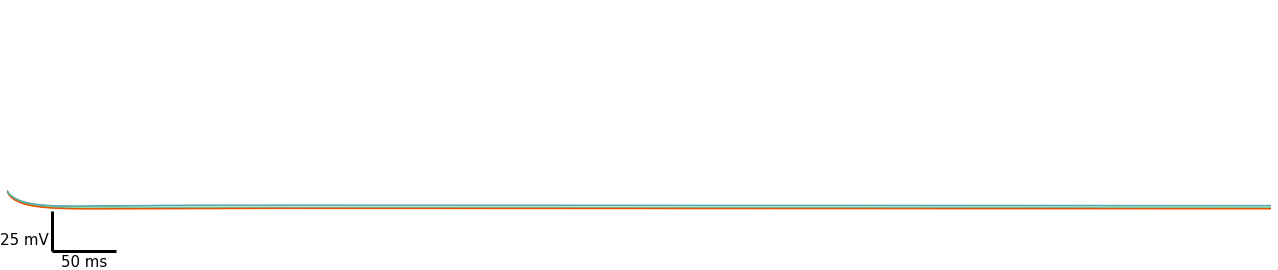



 L4_DBC_bNA   N = 4
Plotting recorded cell traces ... trace


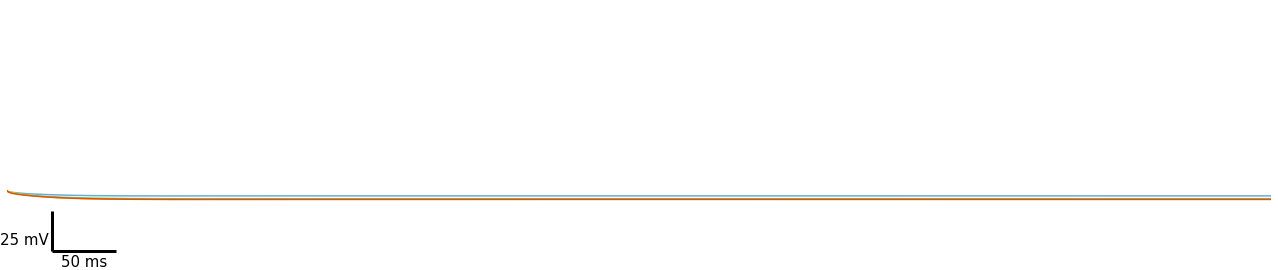



 L4_DBC_bST   N = 4
Plotting recorded cell traces ... trace


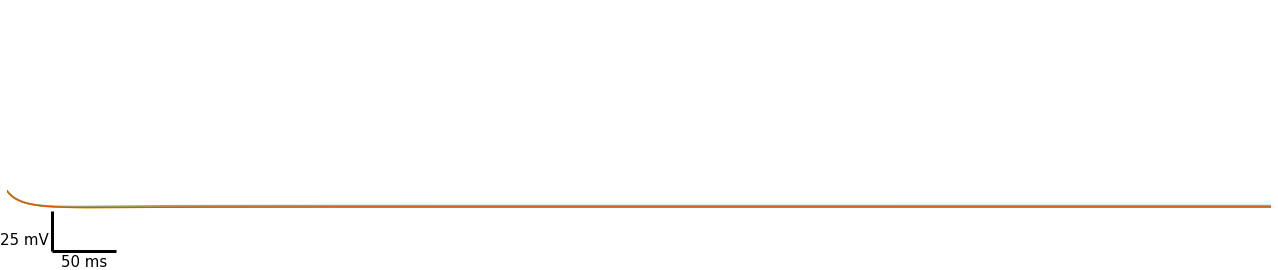



 L4_DBC_cAC   N = 4
Plotting recorded cell traces ... trace


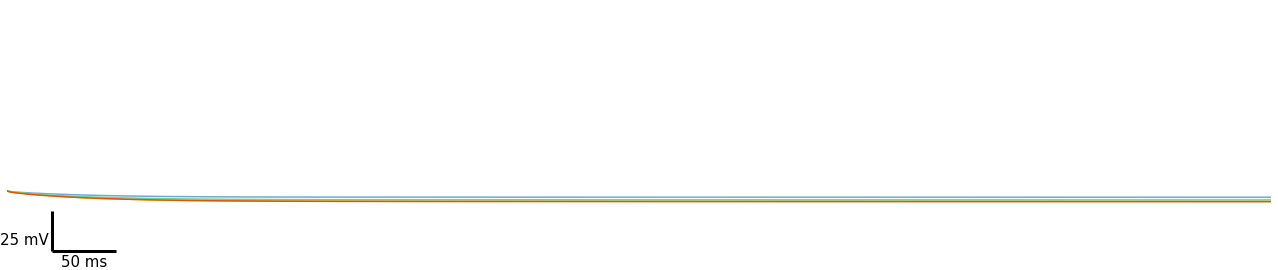



 L4_DBC_cIR   N = 5
Plotting recorded cell traces ... trace


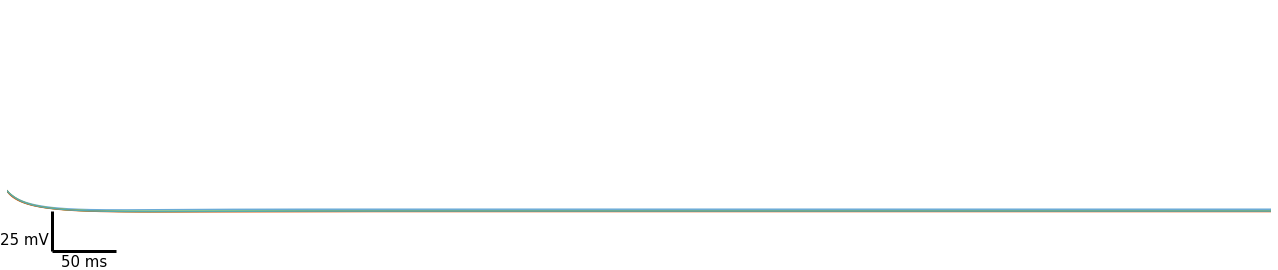



 L4_DBC_cNA   N = 4
Plotting recorded cell traces ... trace


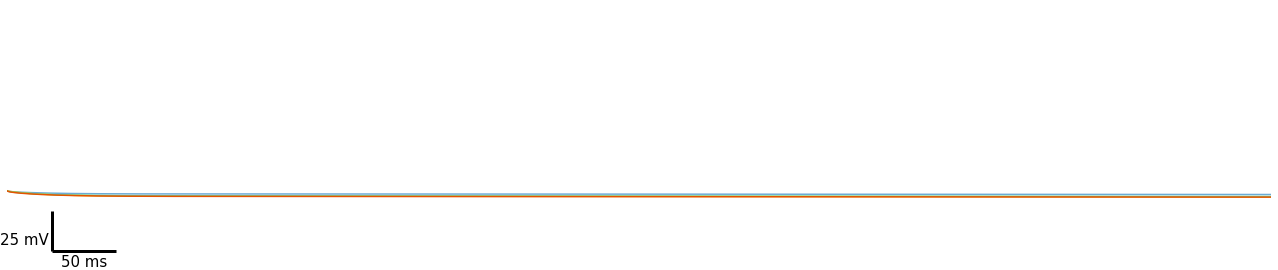



 L4_LBC_cAC   N = 5
Plotting recorded cell traces ... trace


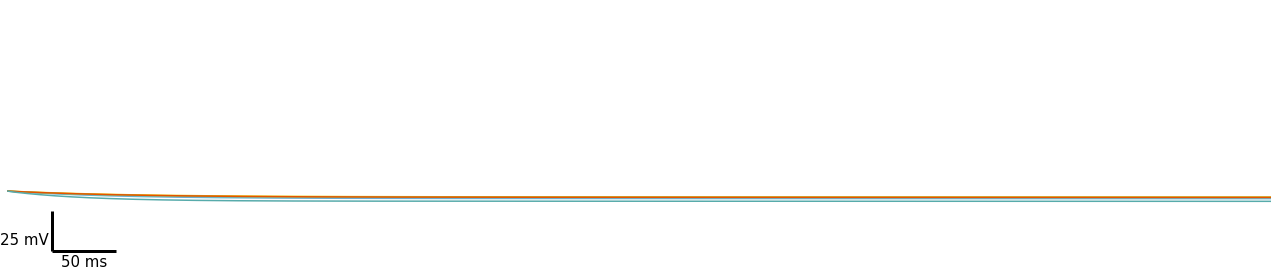



 L4_LBC_cNA   N = 5
Plotting recorded cell traces ... trace


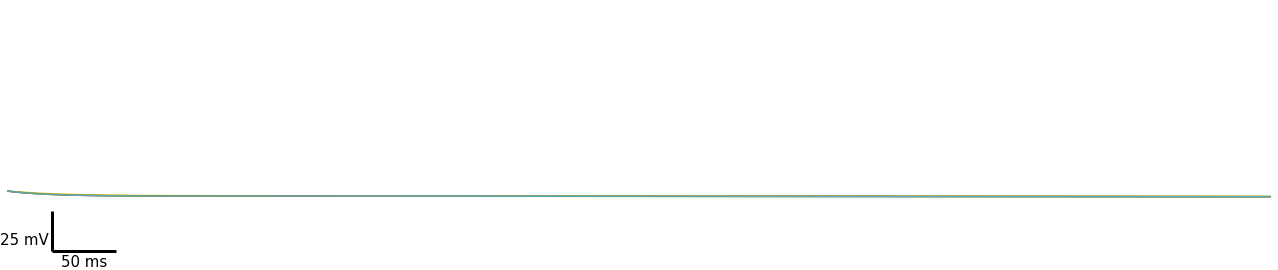



 L4_LBC_cST   N = 5
Plotting recorded cell traces ... trace


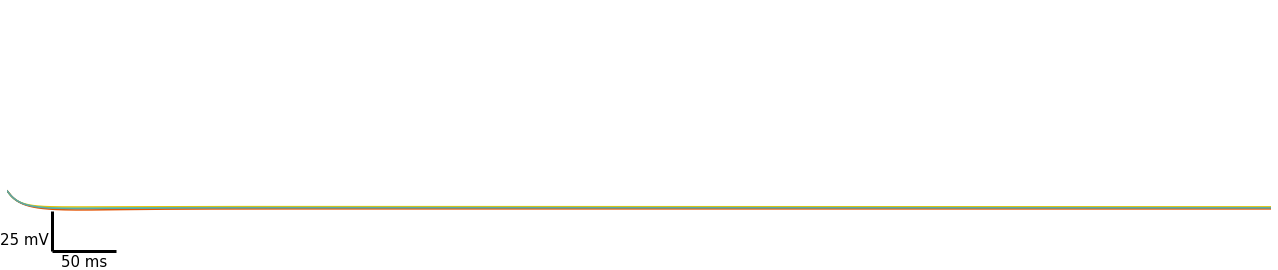



 L4_LBC_dNA   N = 5
Plotting recorded cell traces ... trace


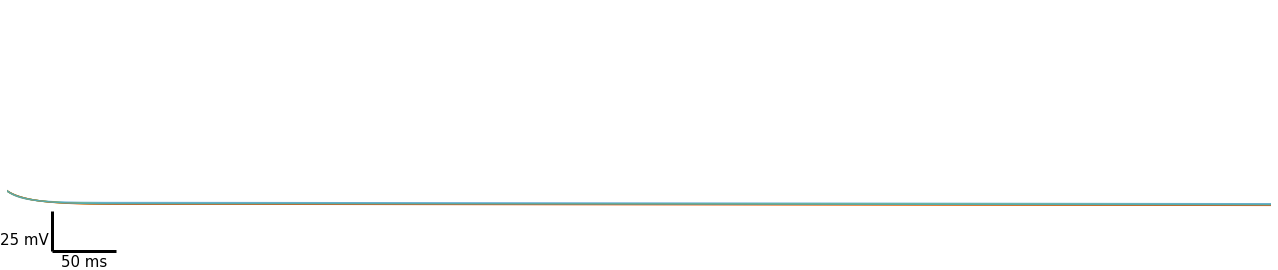



 L4_LBC_dST   N = 5
Plotting recorded cell traces ... trace


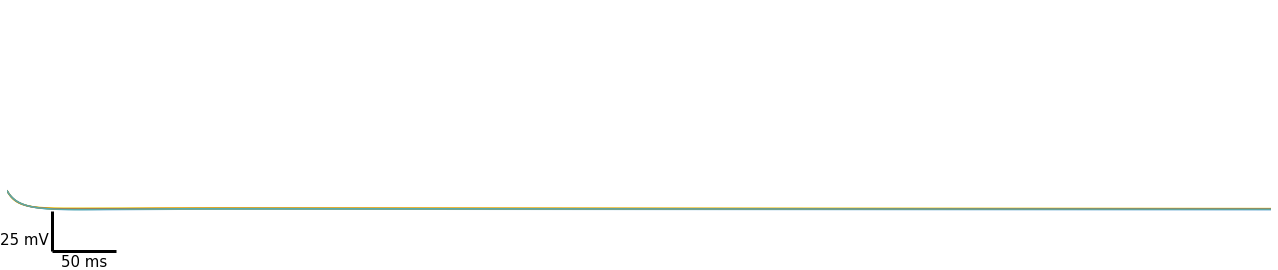



 L4_MC_bAC   N = 5
Plotting recorded cell traces ... trace


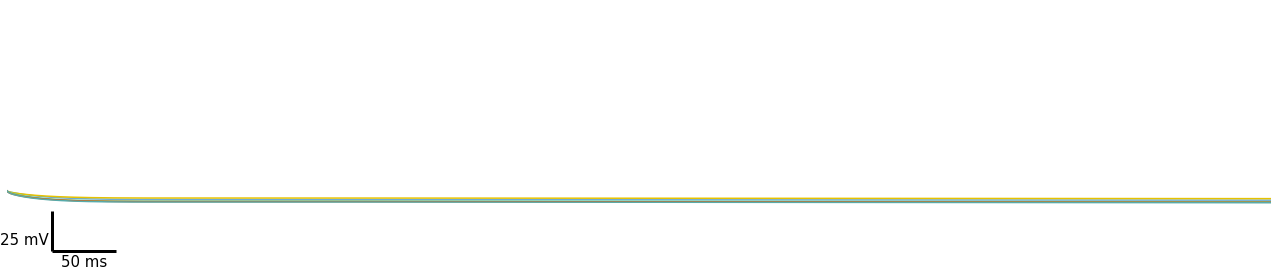



 L4_MC_bNA   N = 4
Plotting recorded cell traces ... trace


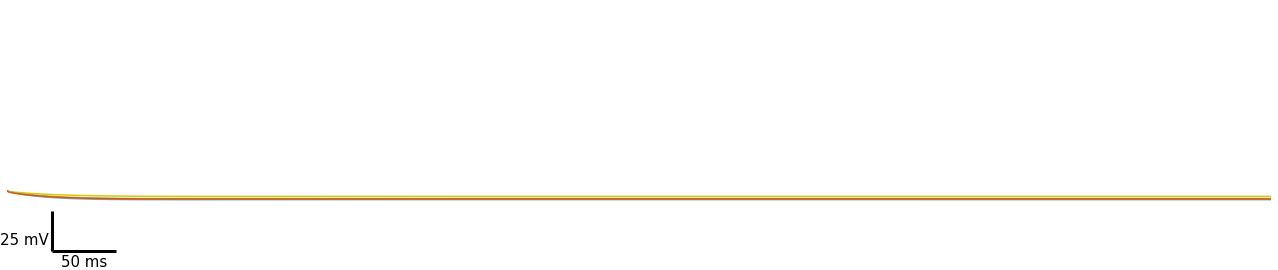



 L4_MC_cAC   N = 5
Plotting recorded cell traces ... trace


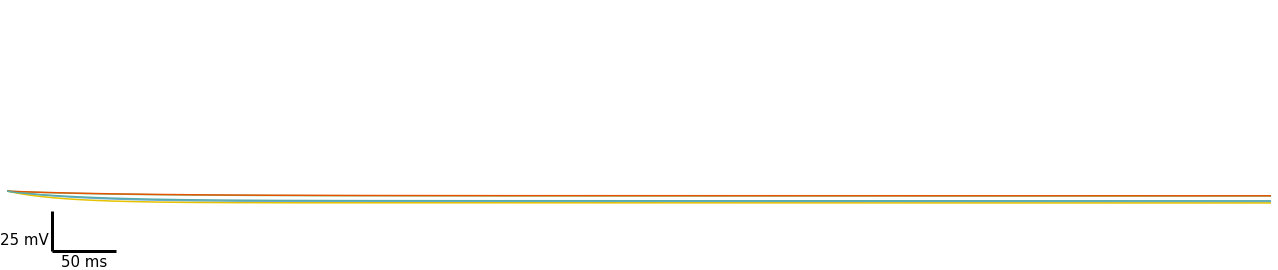



 L4_MC_cNA   N = 5
Plotting recorded cell traces ... trace


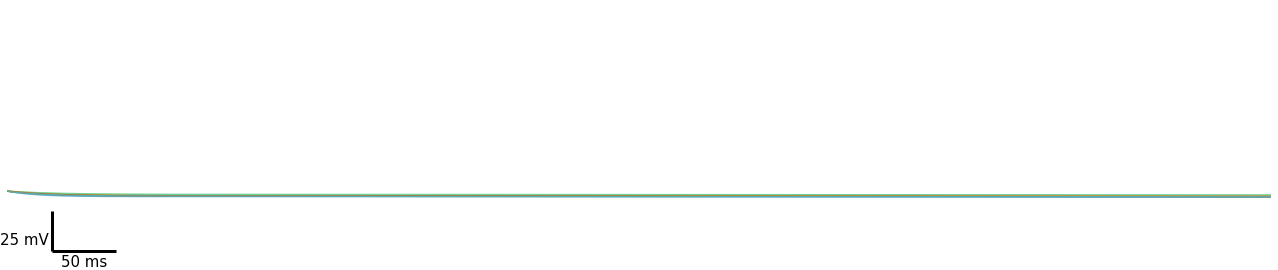



 L4_MC_dNA   N = 4
Plotting recorded cell traces ... trace


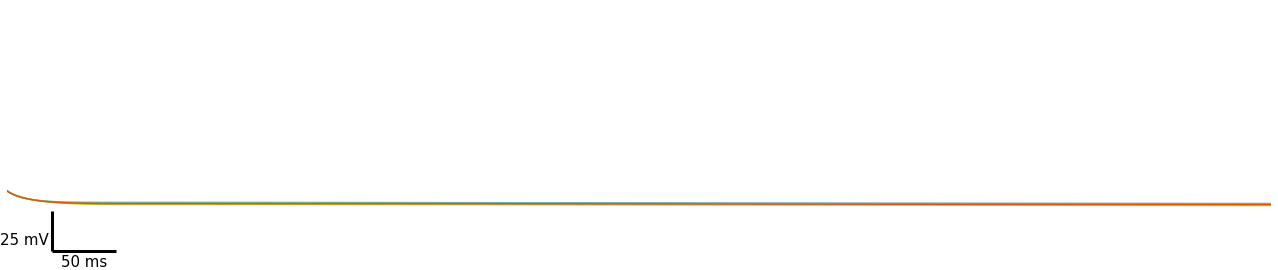



 L4_NBC_cAC   N = 5
Plotting recorded cell traces ... trace


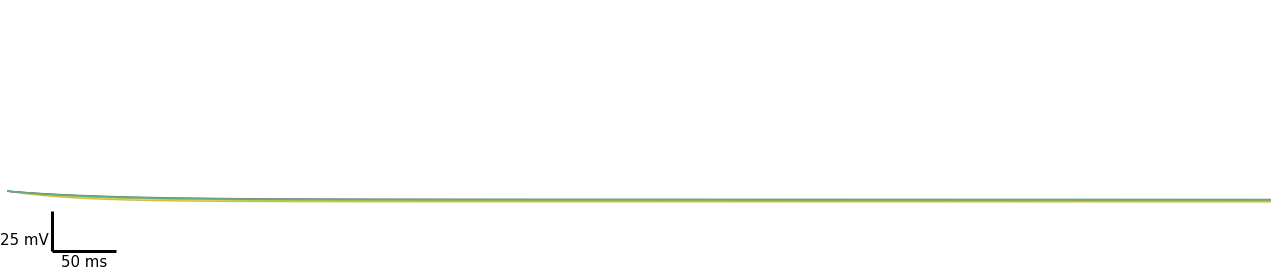



 L4_NBC_cIR   N = 5
Plotting recorded cell traces ... trace


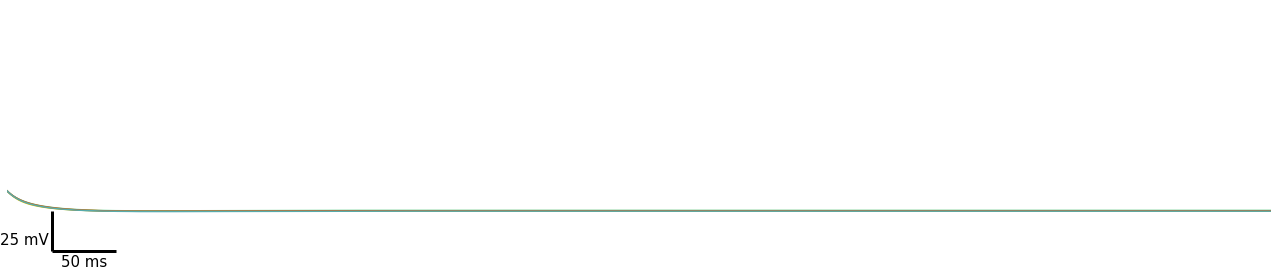



 L4_NBC_cNA   N = 5
Plotting recorded cell traces ... trace


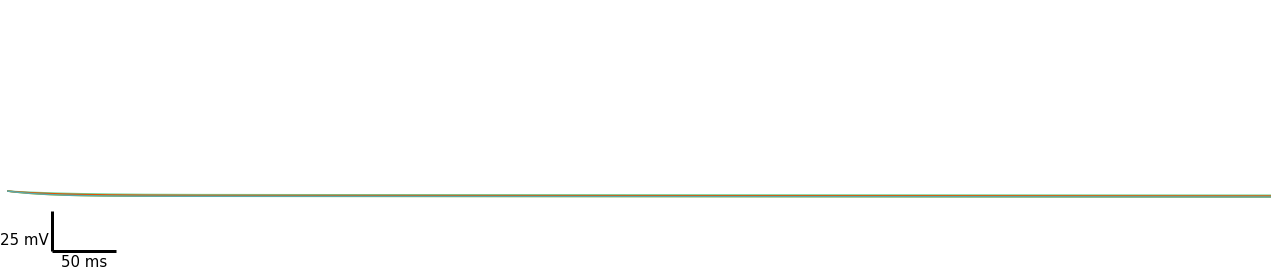



 L4_NBC_dNA   N = 5
Plotting recorded cell traces ... trace


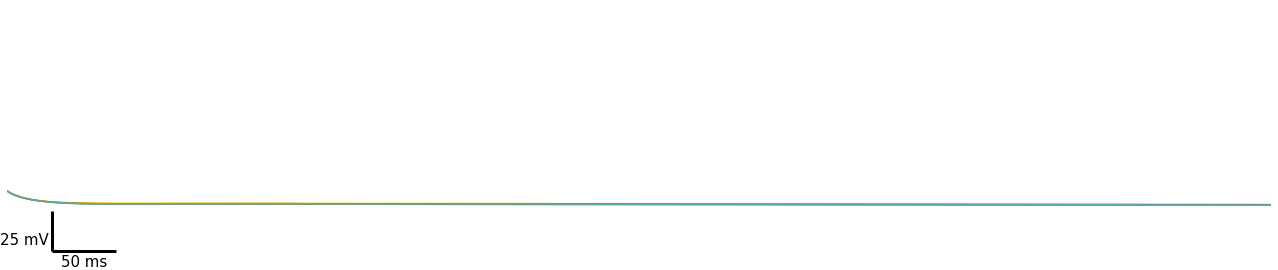



 L4_NGC_bNA   N = 1
Plotting recorded cell traces ... trace


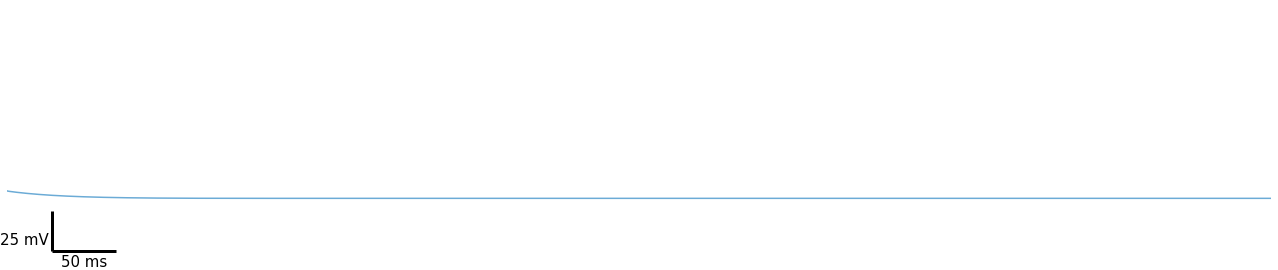



 L4_NGC_cAC   N = 1
Plotting recorded cell traces ... trace


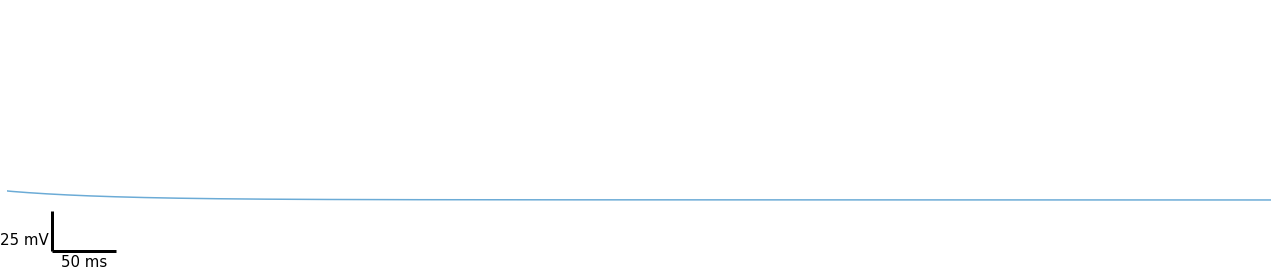



 L4_NGC_cNA   N = 3
Plotting recorded cell traces ... trace


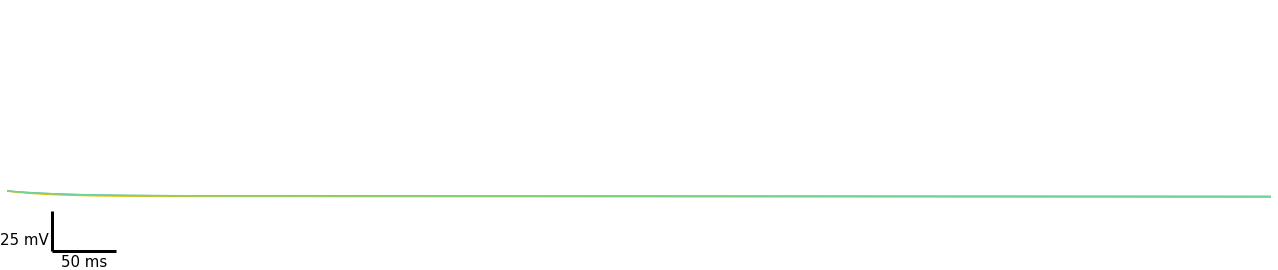



 L4_NGC_cST   N = 1
Plotting recorded cell traces ... trace


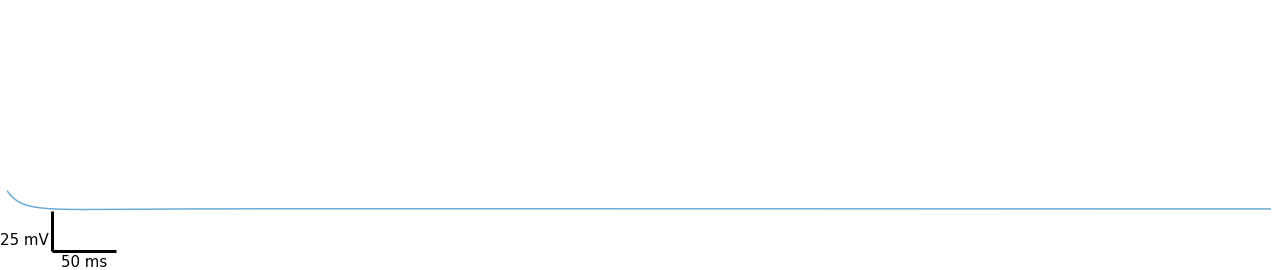



 L4_PC_cAD   N = 5
Plotting recorded cell traces ... trace


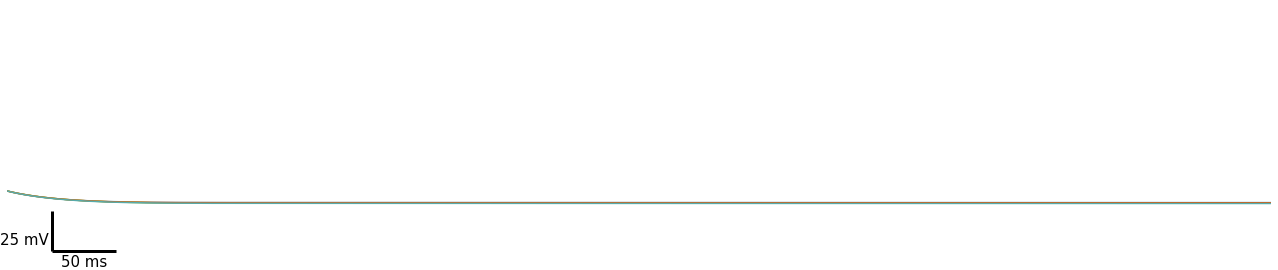



 L4_SBC_bNA   N = 5
Plotting recorded cell traces ... trace


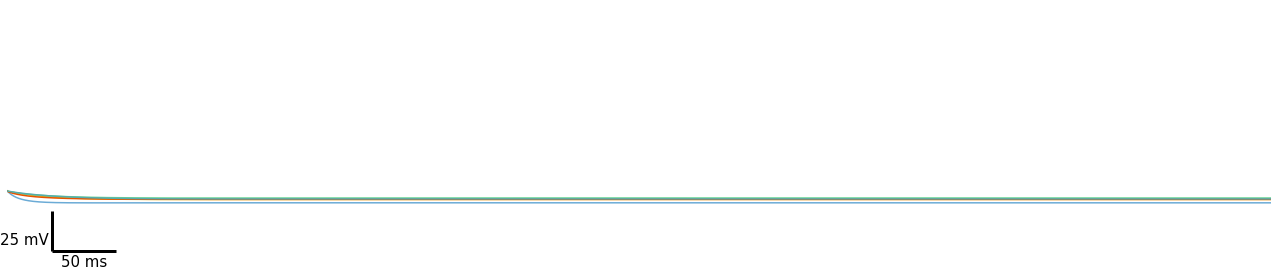



 L4_SBC_cAC   N = 5
Plotting recorded cell traces ... trace


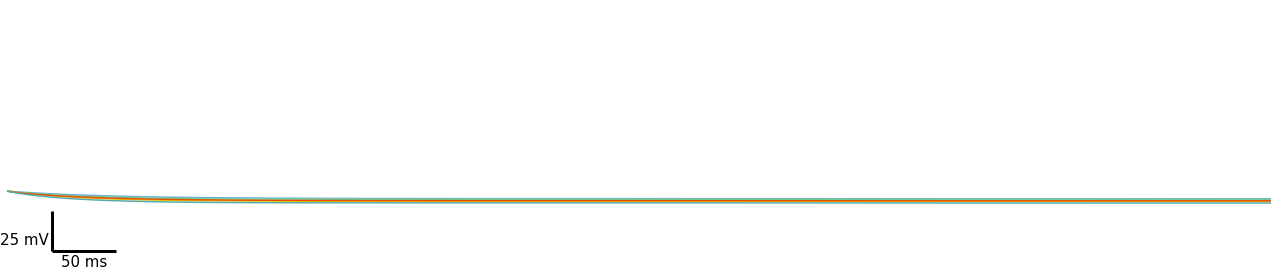



 L4_SBC_dNA   N = 5
Plotting recorded cell traces ... trace


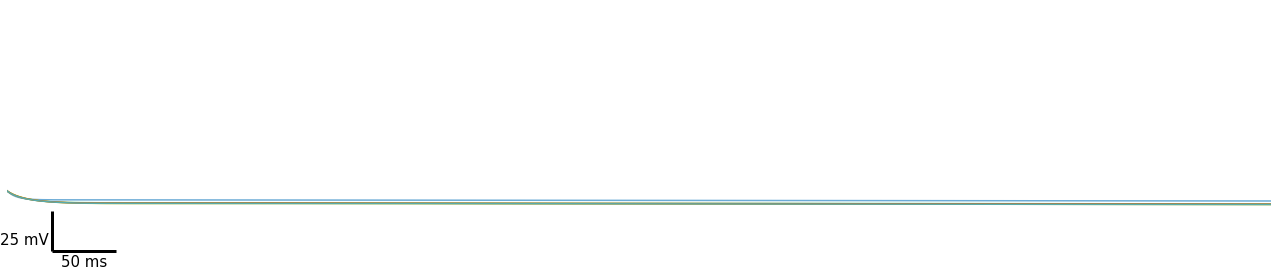



 L4_SP_cAD   N = 5
Plotting recorded cell traces ... trace


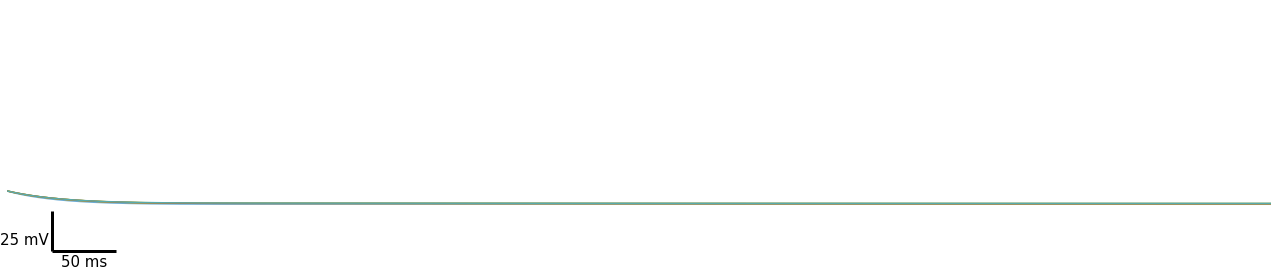



 L4_SS_cAD   N = 5
Plotting recorded cell traces ... trace


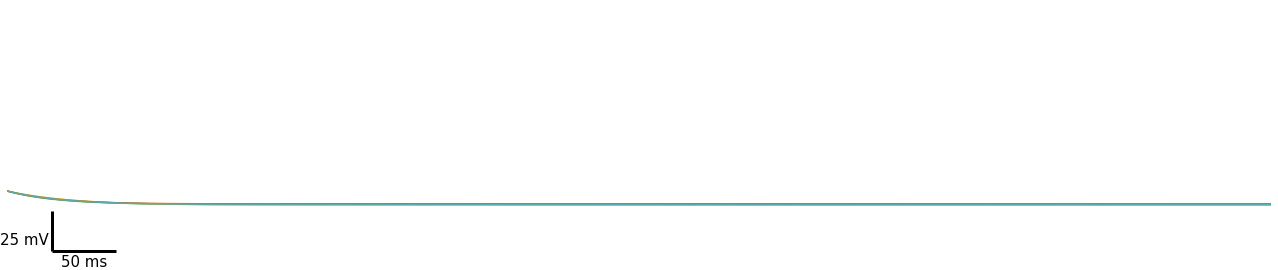



 L5_BP_bAC   N = 3
Plotting recorded cell traces ... trace


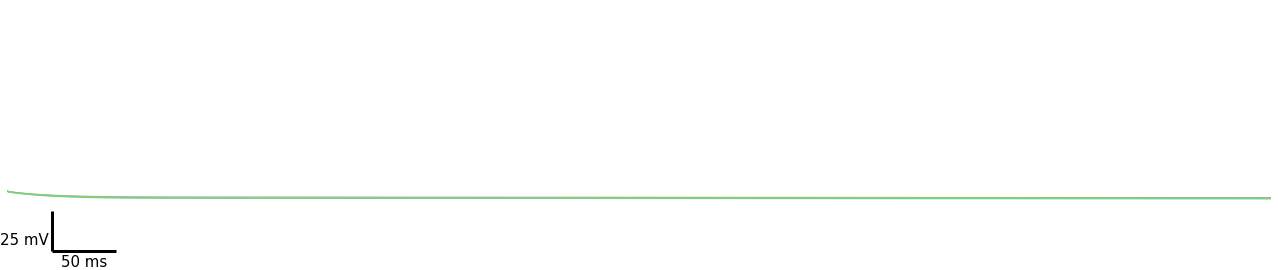



 L5_BP_bIR   N = 5
Plotting recorded cell traces ... trace


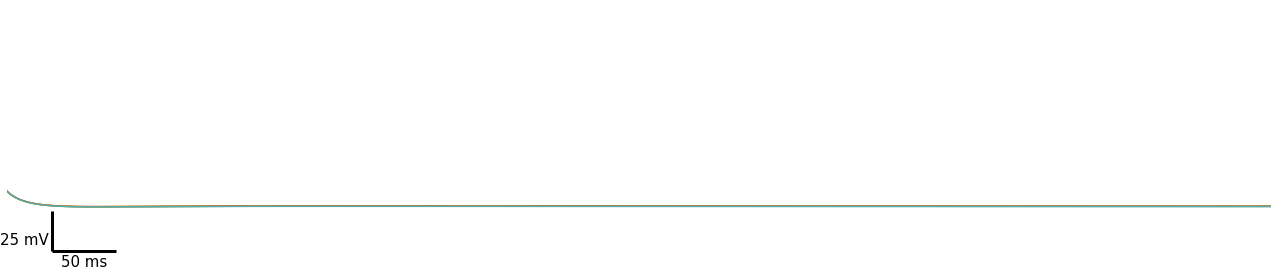



 L5_BP_bNA   N = 5
Plotting recorded cell traces ... trace


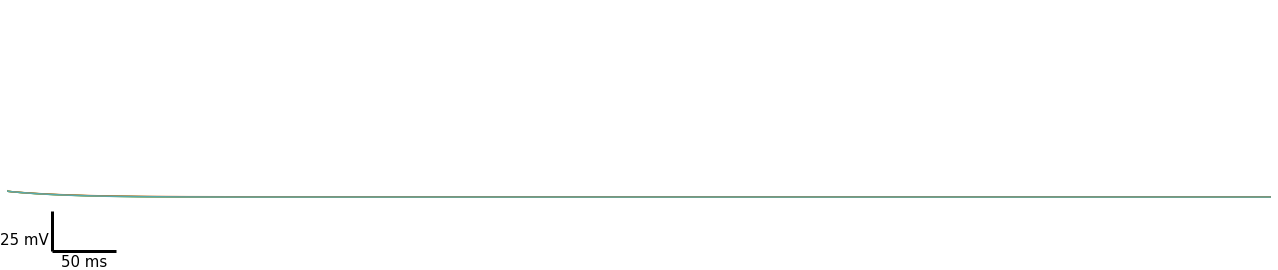



 L5_BP_cAC   N = 5
Plotting recorded cell traces ... trace


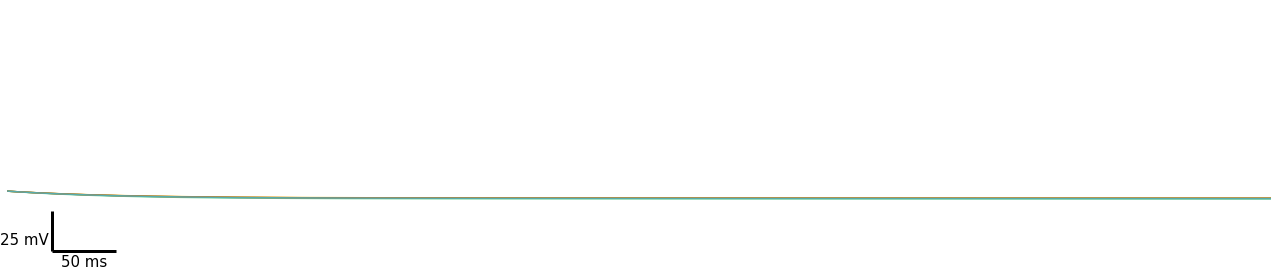



 L5_BP_cNA   N = 5
Plotting recorded cell traces ... trace


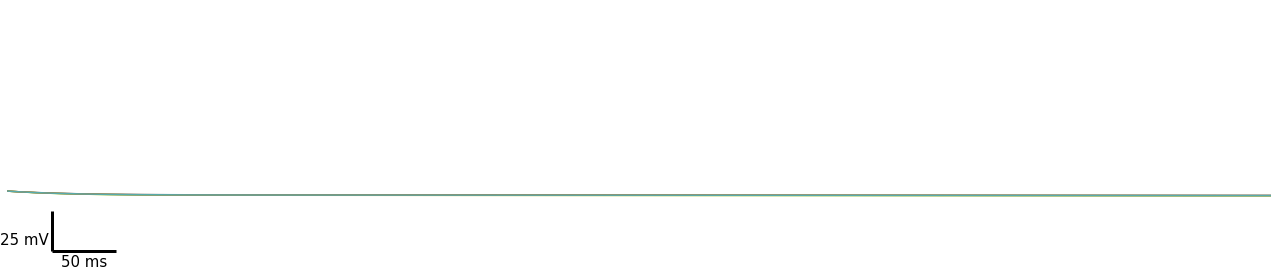



 L5_BP_dST   N = 3
Plotting recorded cell traces ... trace


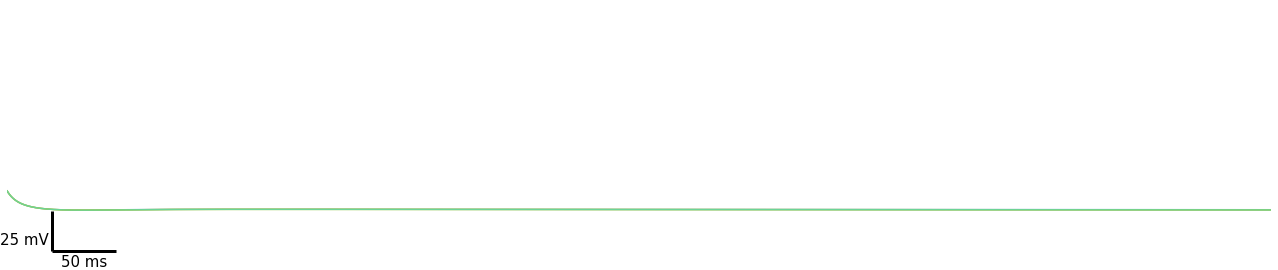



 L5_BTC_bAC   N = 5
Plotting recorded cell traces ... trace


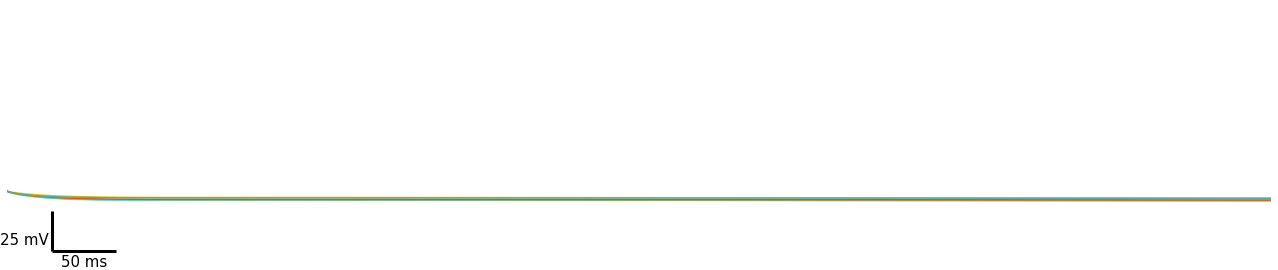



 L5_BTC_cAC   N = 5
Plotting recorded cell traces ... trace


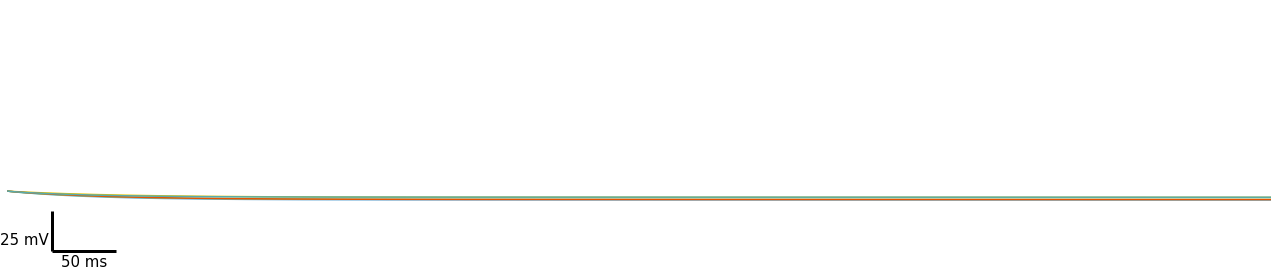



 L5_BTC_cNA   N = 5
Plotting recorded cell traces ... trace


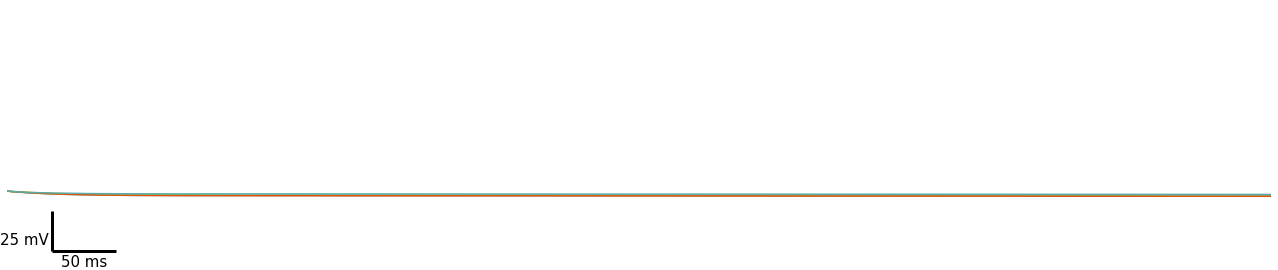



 L5_ChC_cAC   N = 5
Plotting recorded cell traces ... trace


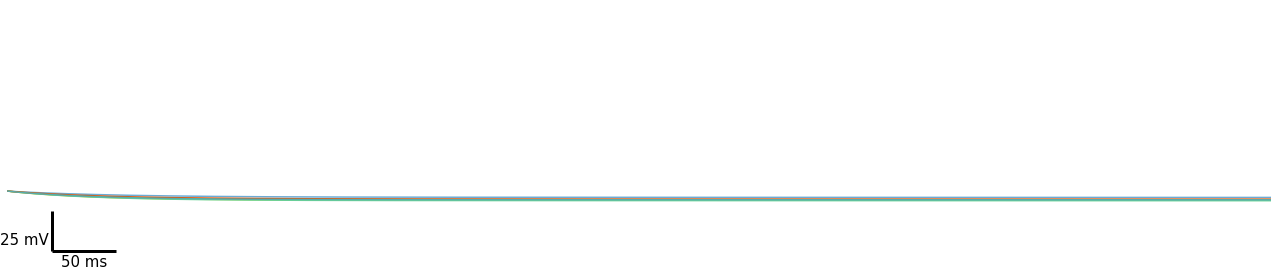



 L5_ChC_cNA   N = 5
Plotting recorded cell traces ... trace


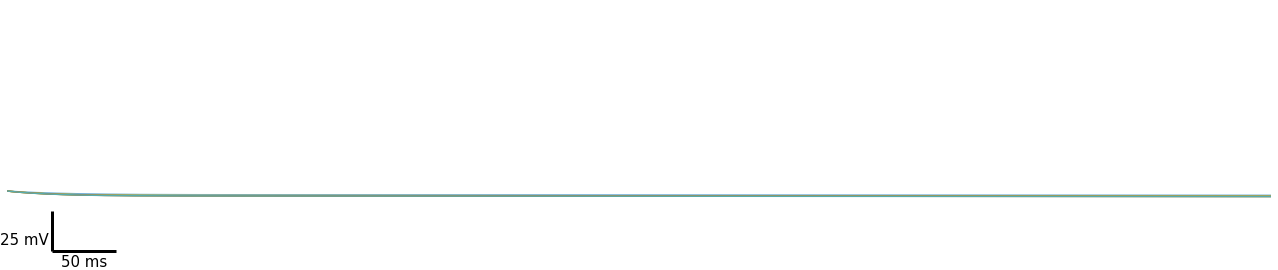



 L5_ChC_dNA   N = 5
Plotting recorded cell traces ... trace


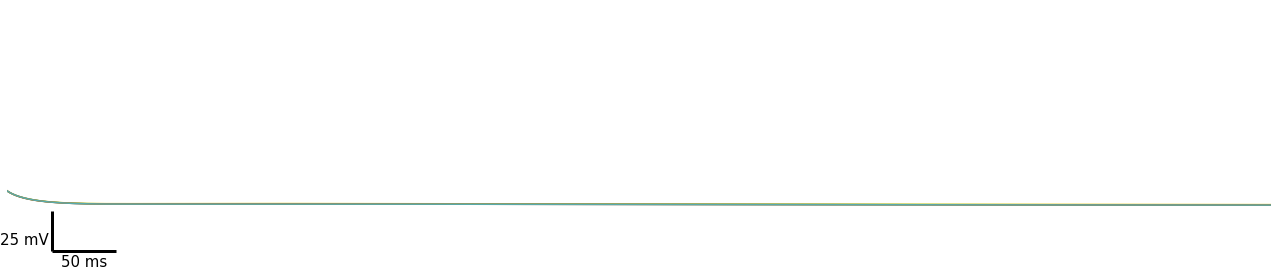



 L5_DBC_bAC   N = 5
Plotting recorded cell traces ... trace


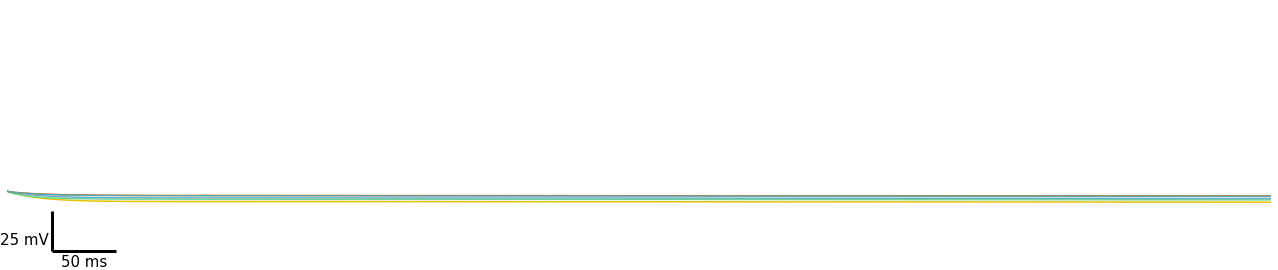



 L5_DBC_bIR   N = 5
Plotting recorded cell traces ... trace


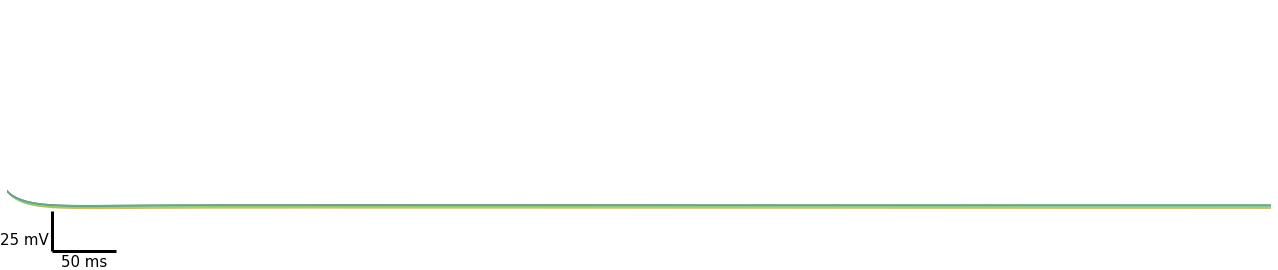



 L5_DBC_bNA   N = 5
Plotting recorded cell traces ... trace


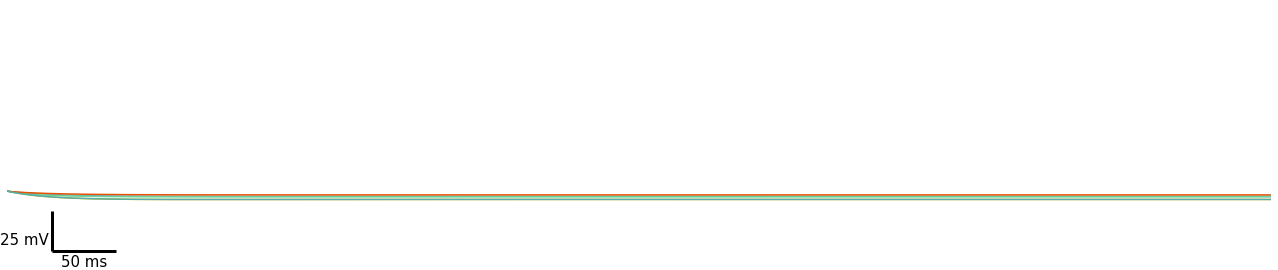



 L5_DBC_bST   N = 5
Plotting recorded cell traces ... trace


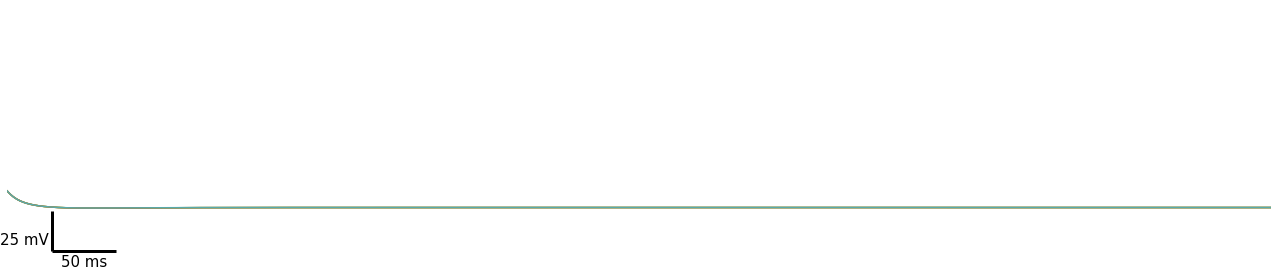



 L5_DBC_cAC   N = 5
Plotting recorded cell traces ... trace


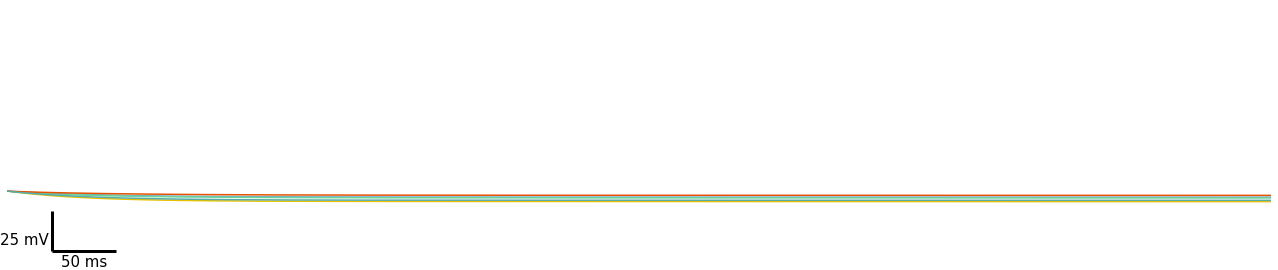



 L5_DBC_cIR   N = 5
Plotting recorded cell traces ... trace


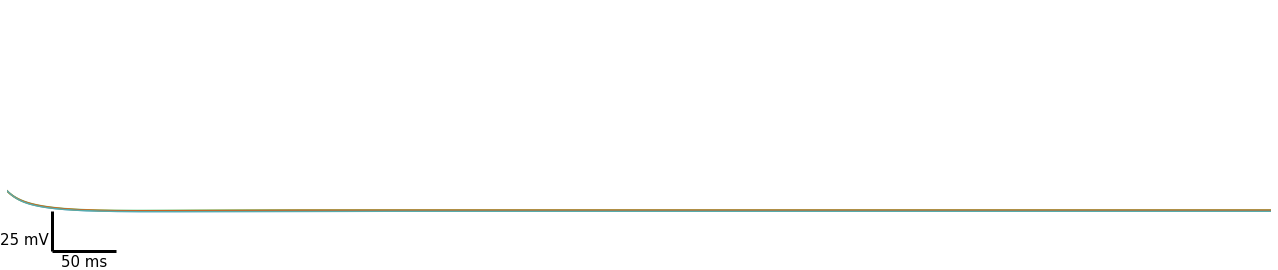



 L5_DBC_cNA   N = 5
Plotting recorded cell traces ... trace


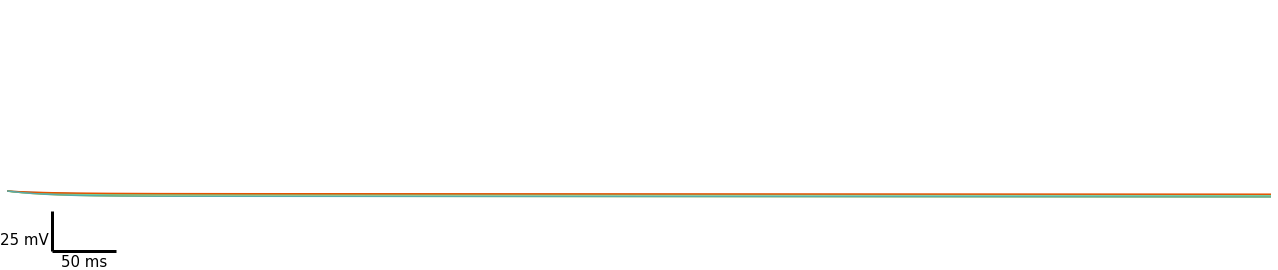



 L5_LBC_bAC   N = 5
Plotting recorded cell traces ... trace


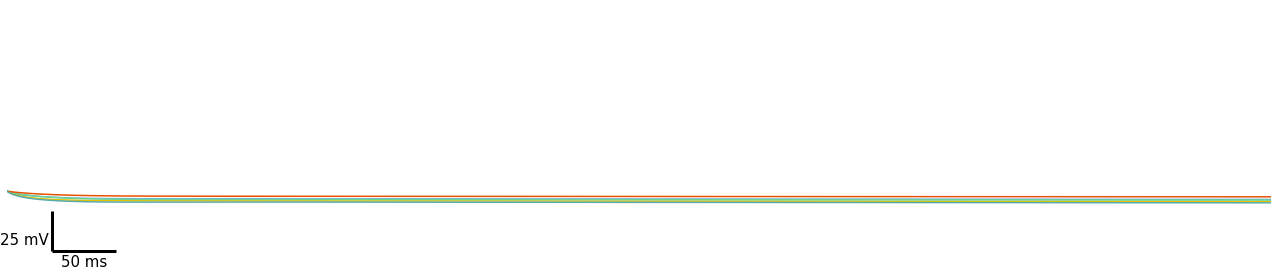



 L5_LBC_cAC   N = 5
Plotting recorded cell traces ... trace


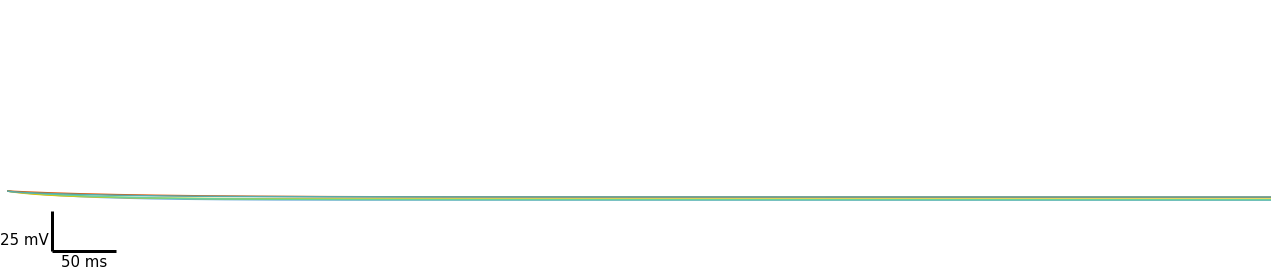



 L5_LBC_cIR   N = 5
Plotting recorded cell traces ... trace


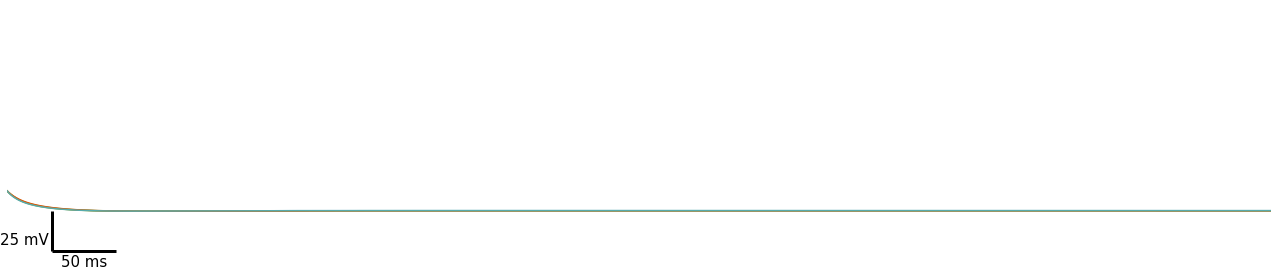



 L5_LBC_cNA   N = 5
Plotting recorded cell traces ... trace


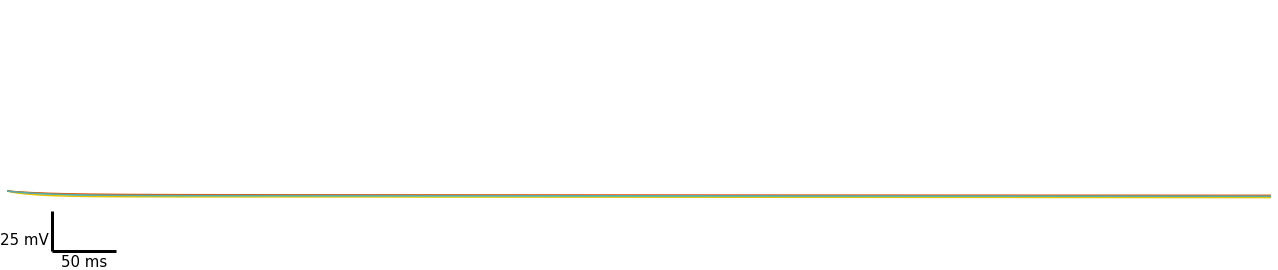



 L5_LBC_cST   N = 5
Plotting recorded cell traces ... trace


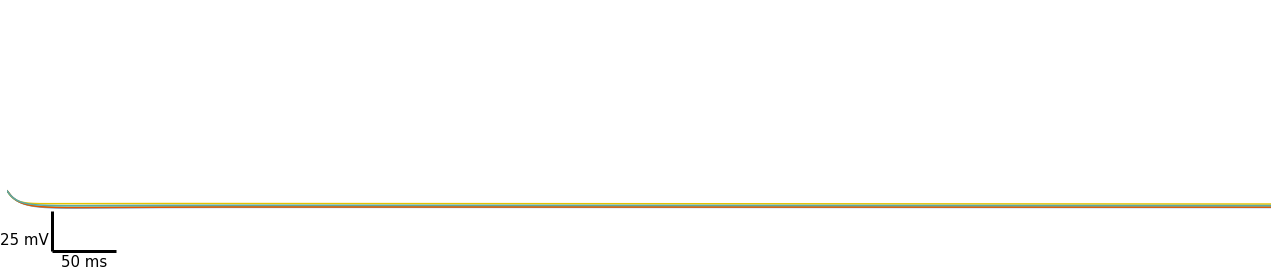



 L5_LBC_dNA   N = 5
Plotting recorded cell traces ... trace


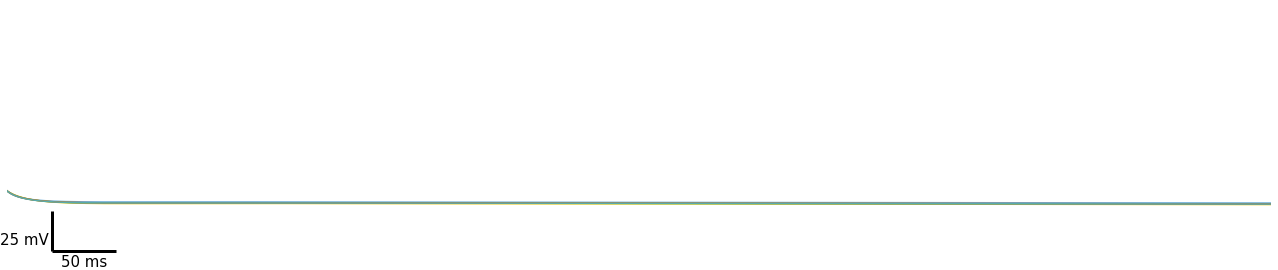



 L5_LBC_dST   N = 5
Plotting recorded cell traces ... trace


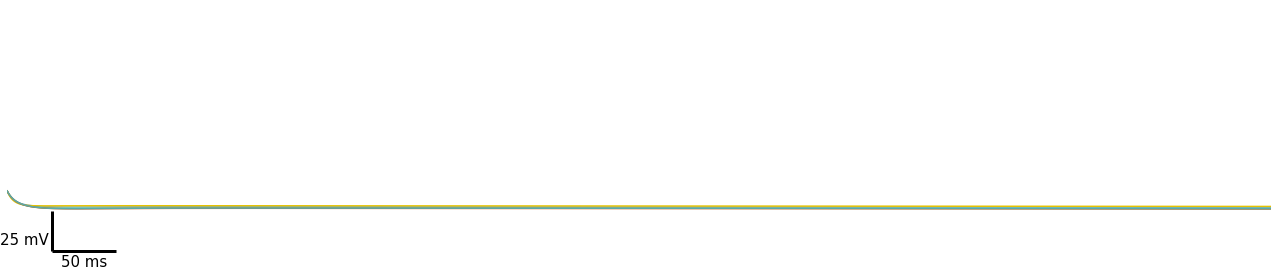



 L5_MC_bAC   N = 5
Plotting recorded cell traces ... trace


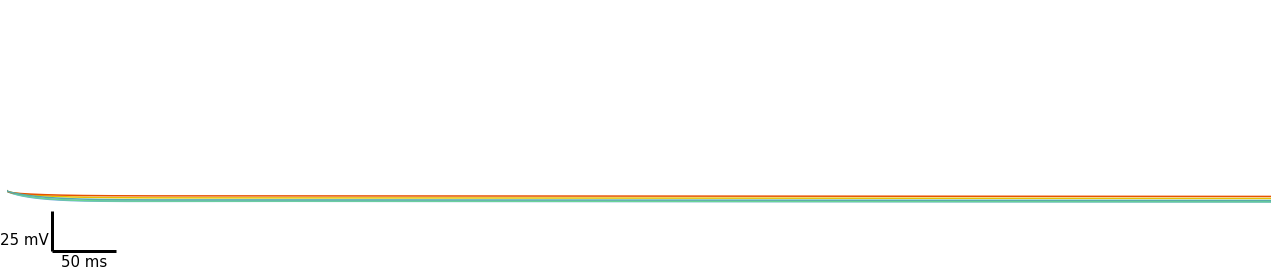



 L5_MC_bIR   N = 5
Plotting recorded cell traces ... trace


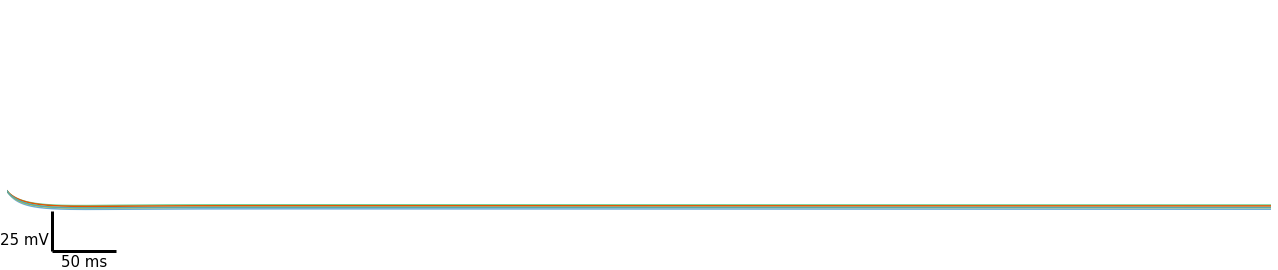



 L5_MC_bST   N = 5
Plotting recorded cell traces ... trace


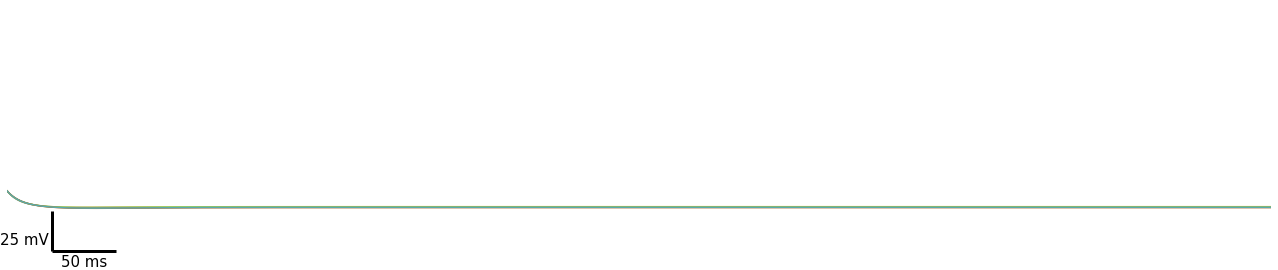



 L5_MC_cAC   N = 5
Plotting recorded cell traces ... trace


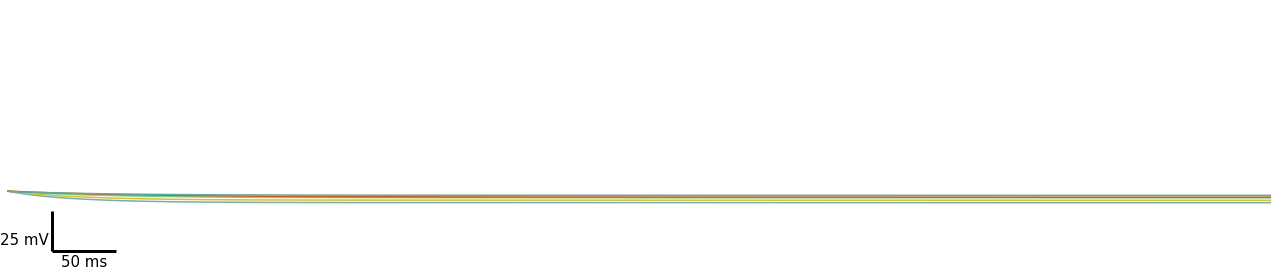



 L5_MC_cNA   N = 5
Plotting recorded cell traces ... trace


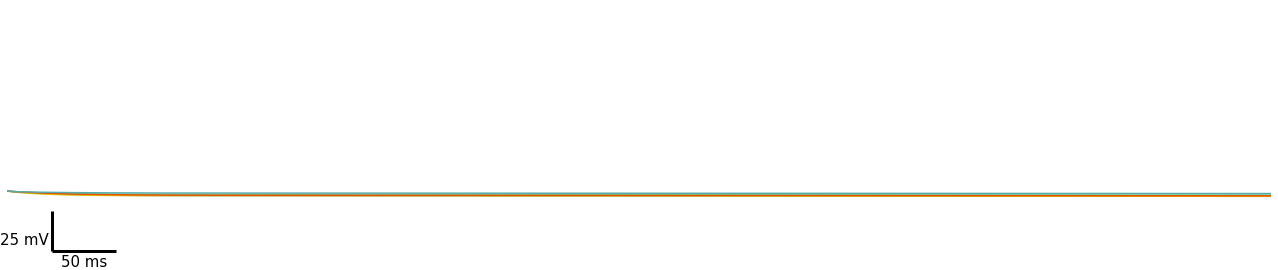



 L5_MC_cST   N = 5
Plotting recorded cell traces ... trace


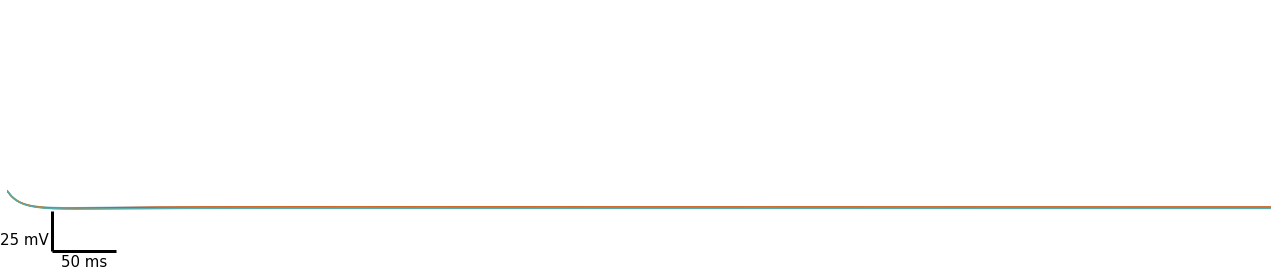



 L5_MC_dNA   N = 5
Plotting recorded cell traces ... trace


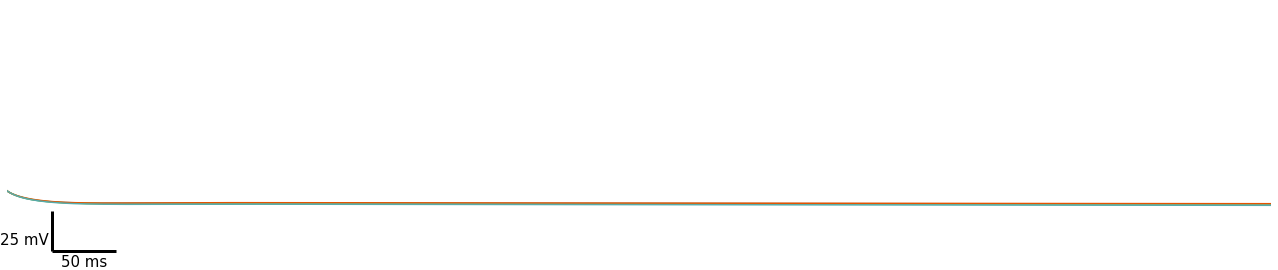



 L5_NBC_bAC   N = 5
Plotting recorded cell traces ... trace


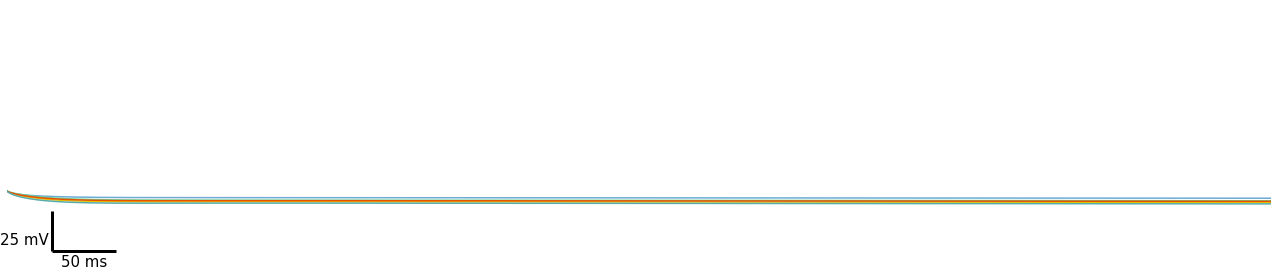



 L5_NBC_bIR   N = 5
Plotting recorded cell traces ... trace


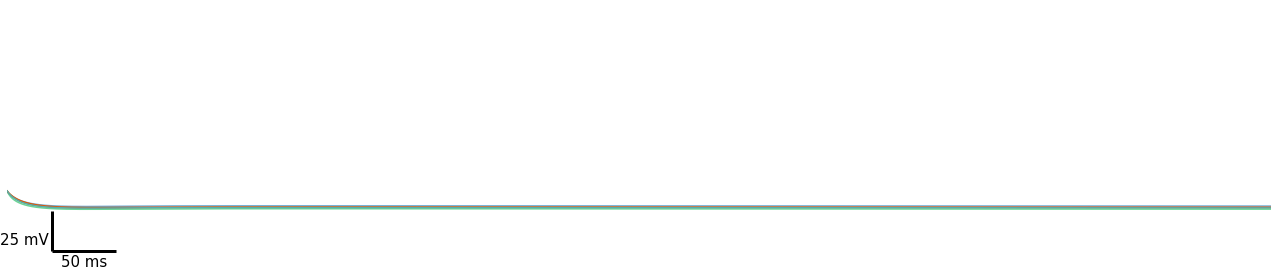



 L5_NBC_bST   N = 5
Plotting recorded cell traces ... trace


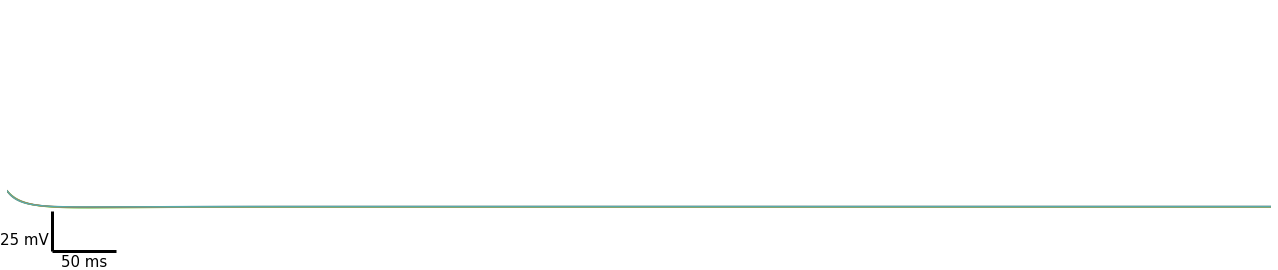



 L5_NBC_cAC   N = 5
Plotting recorded cell traces ... trace


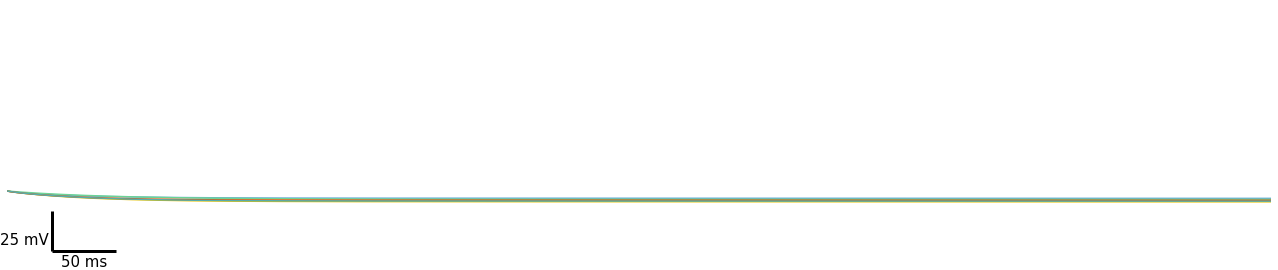



 L5_NBC_cIR   N = 5
Plotting recorded cell traces ... trace


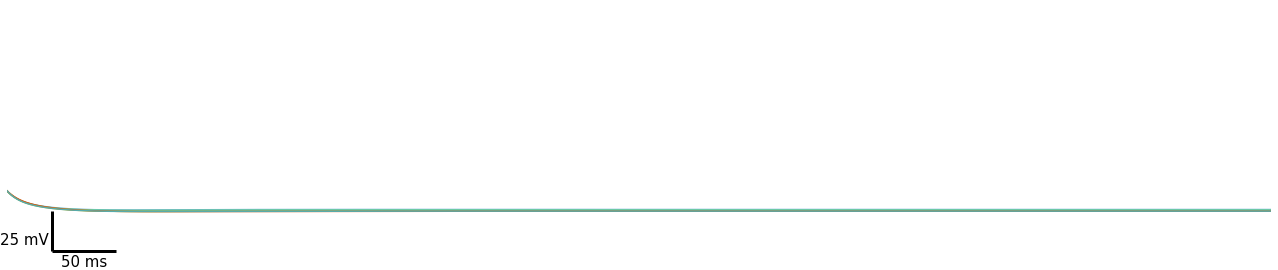



 L5_NBC_cNA   N = 5
Plotting recorded cell traces ... trace


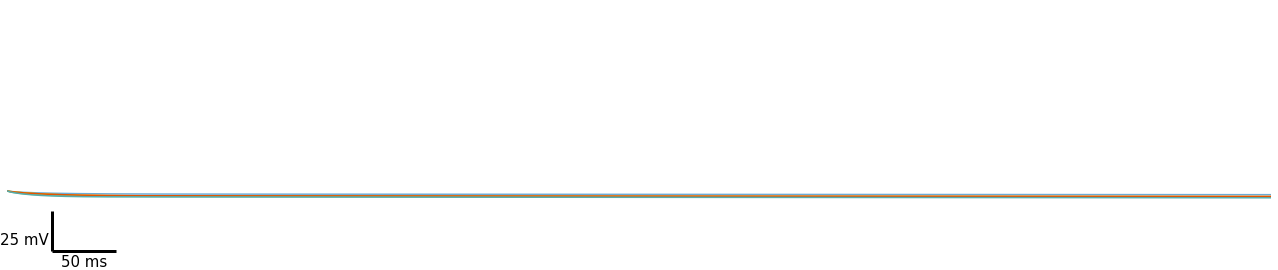



 L5_NBC_cST   N = 5
Plotting recorded cell traces ... trace


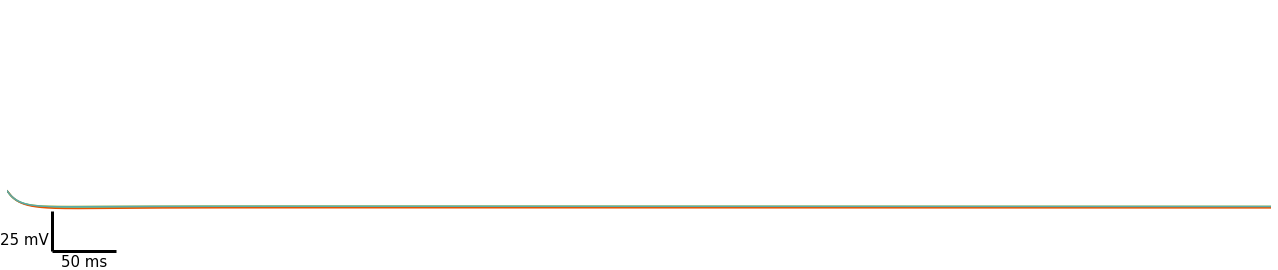



 L5_NBC_dST   N = 5
Plotting recorded cell traces ... trace


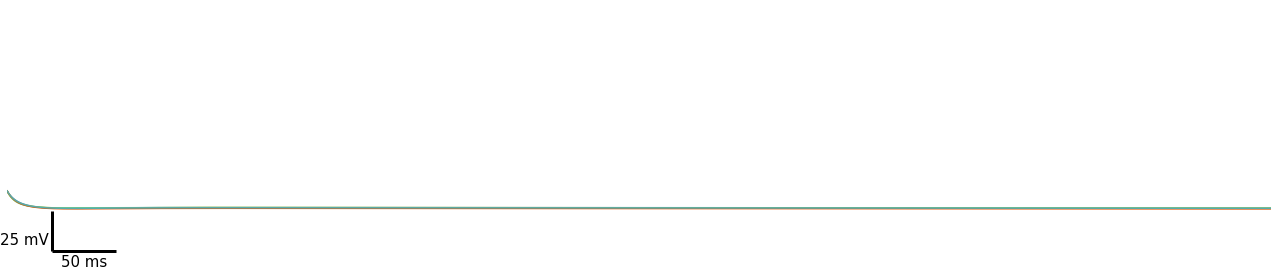



 L5_NGC_bNA   N = 1
Plotting recorded cell traces ... trace


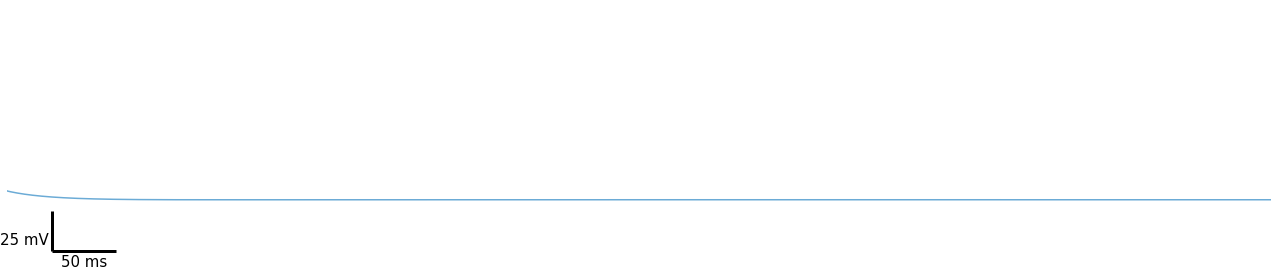



 L5_NGC_cAC   N = 1
Plotting recorded cell traces ... trace


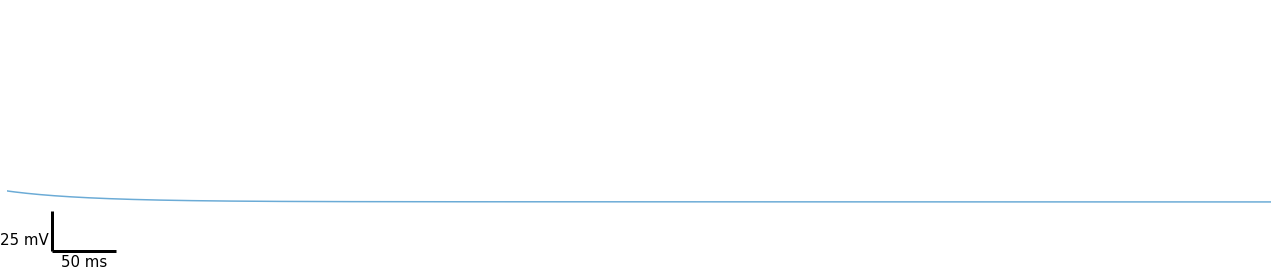



 L5_NGC_cNA   N = 5
Plotting recorded cell traces ... trace


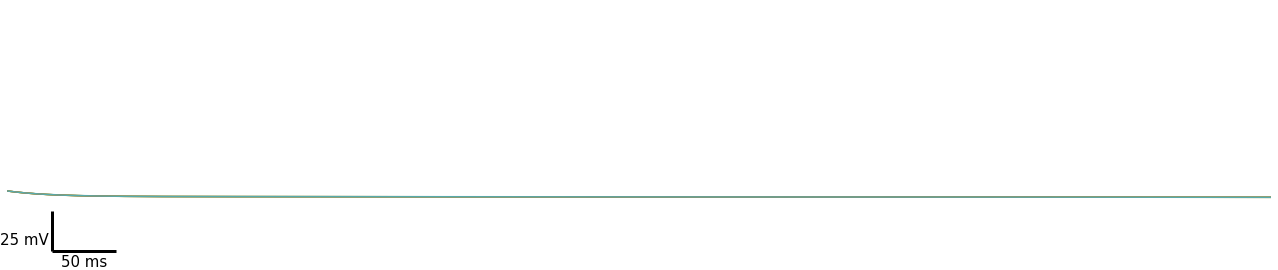



 L5_NGC_cST   N = 1
Plotting recorded cell traces ... trace


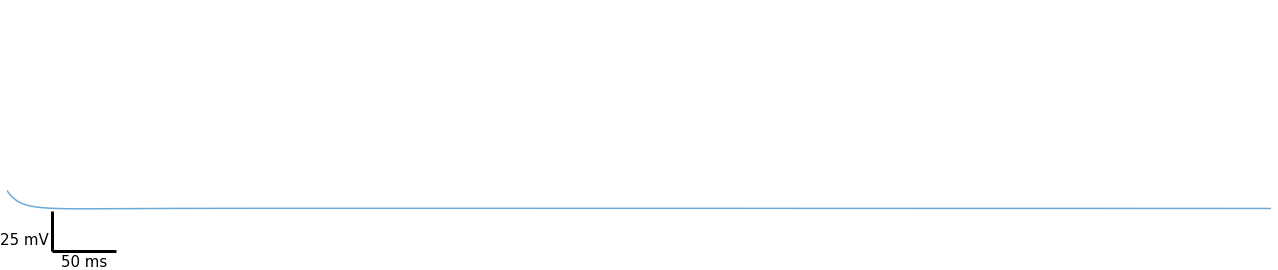



 L5_SBC_bNA   N = 5
Plotting recorded cell traces ... trace


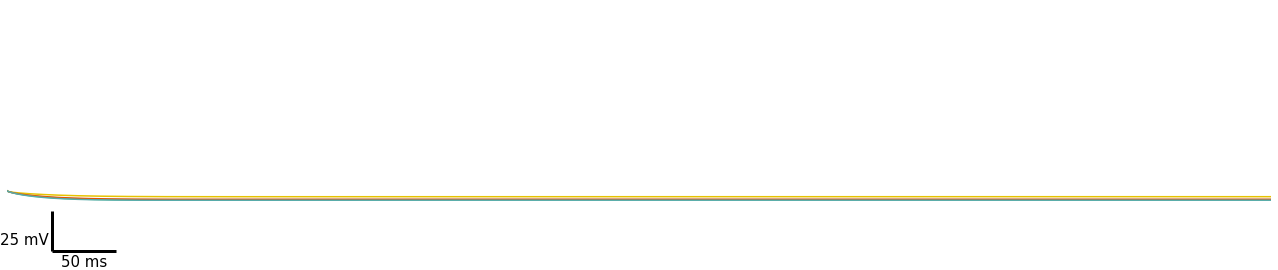



 L5_SBC_cAC   N = 5
Plotting recorded cell traces ... trace


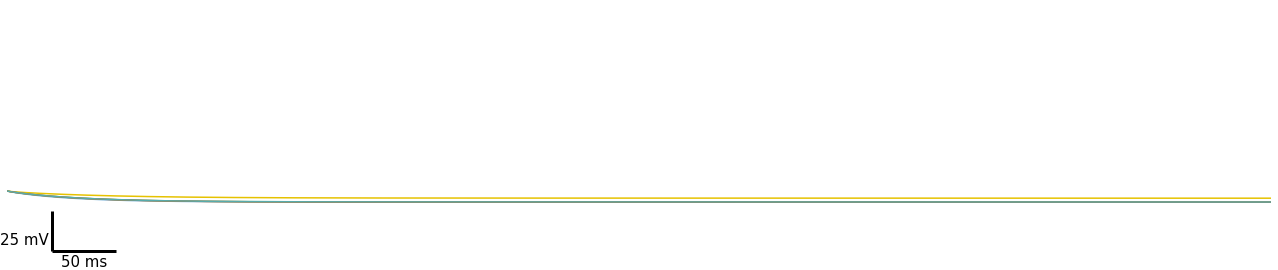



 L5_SBC_dNA   N = 5
Plotting recorded cell traces ... trace


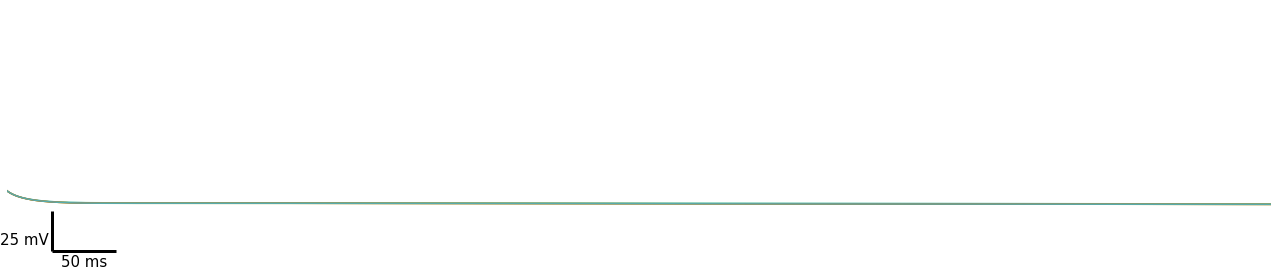



 L5_STPC_cAD   N = 5
Plotting recorded cell traces ... trace


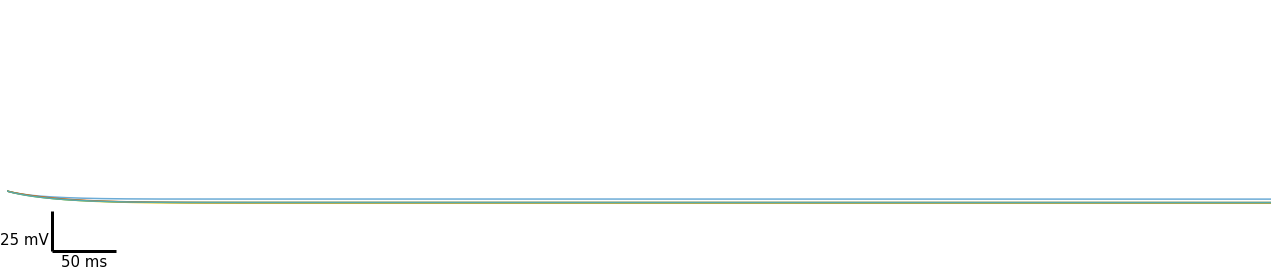



 L5_TTPC1_cAD   N = 5
Plotting recorded cell traces ... trace


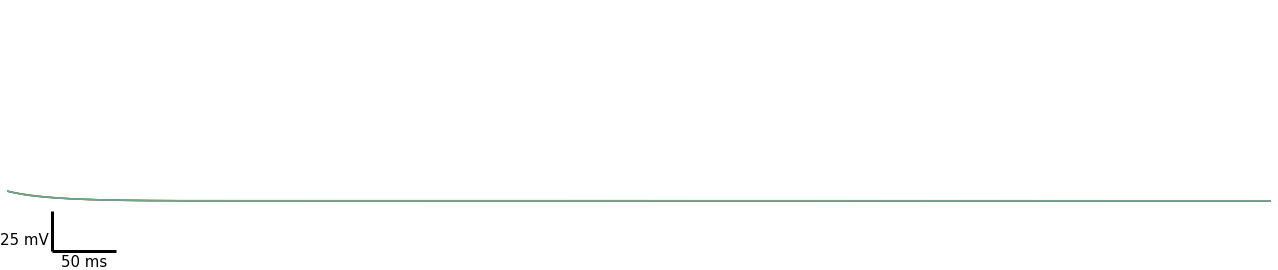



 L5_TTPC2_cAD   N = 5
Plotting recorded cell traces ... trace


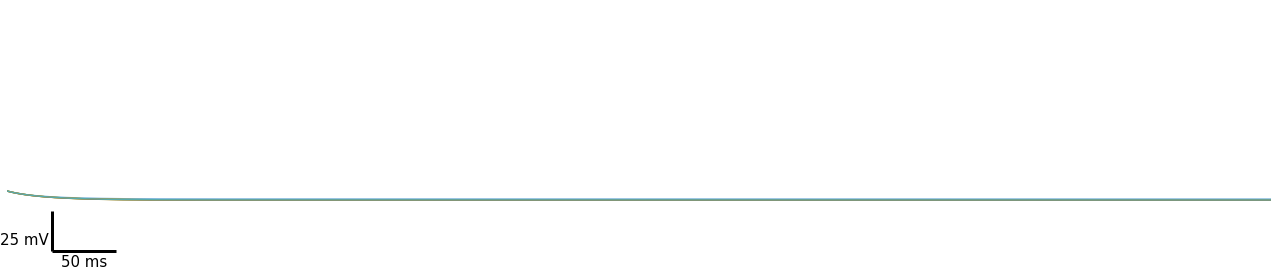



 L5_UTPC_cAD   N = 5
Plotting recorded cell traces ... trace


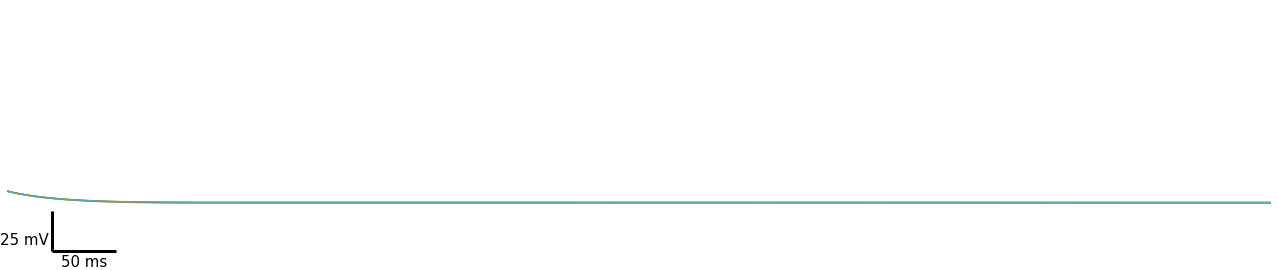



 L6_BPC_cAD   N = 5
Plotting recorded cell traces ... trace


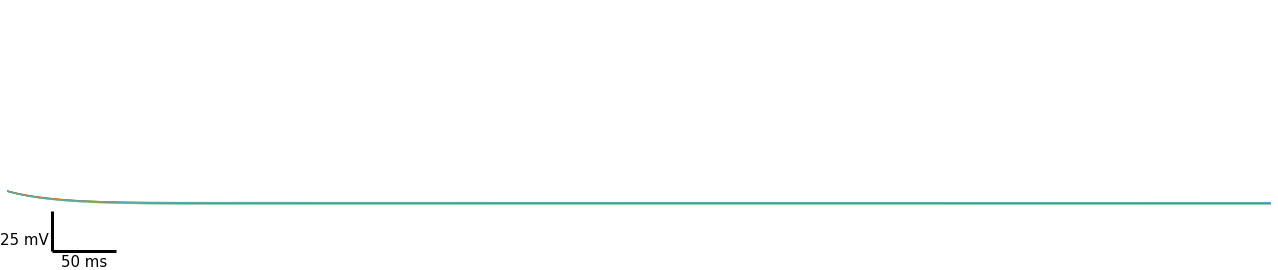



 L6_BP_bAC   N = 5
Plotting recorded cell traces ... trace


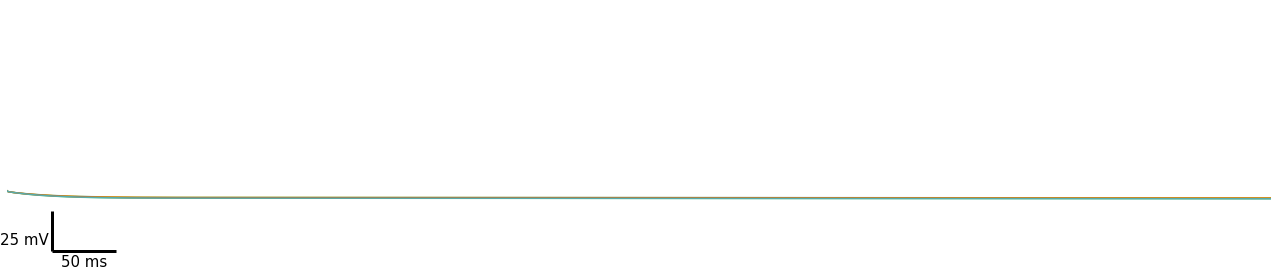



 L6_BP_bIR   N = 5
Plotting recorded cell traces ... trace


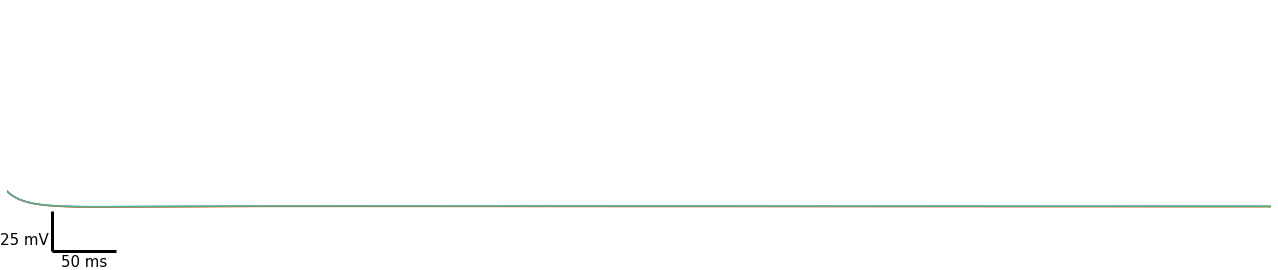



 L6_BP_bNA   N = 5
Plotting recorded cell traces ... trace


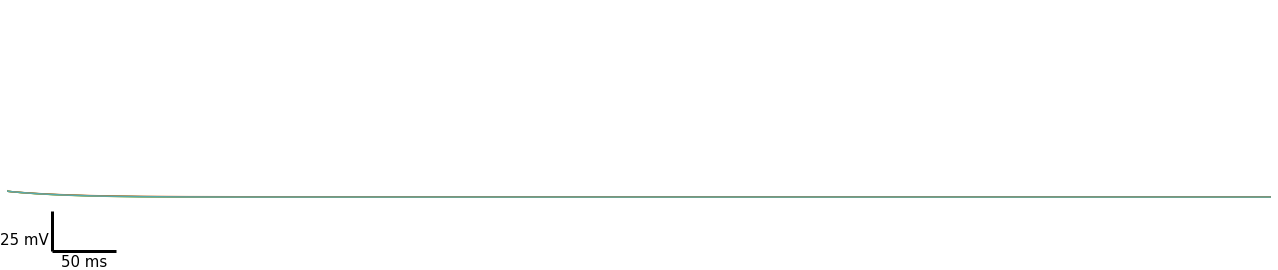



 L6_BP_cAC   N = 5
Plotting recorded cell traces ... trace


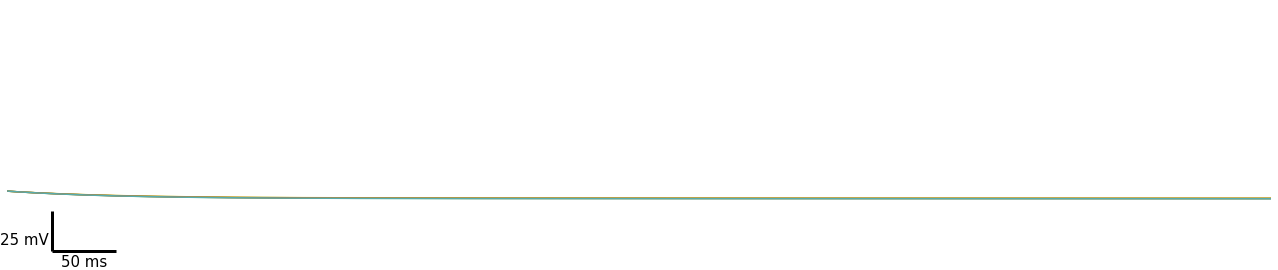



 L6_BP_cNA   N = 5
Plotting recorded cell traces ... trace


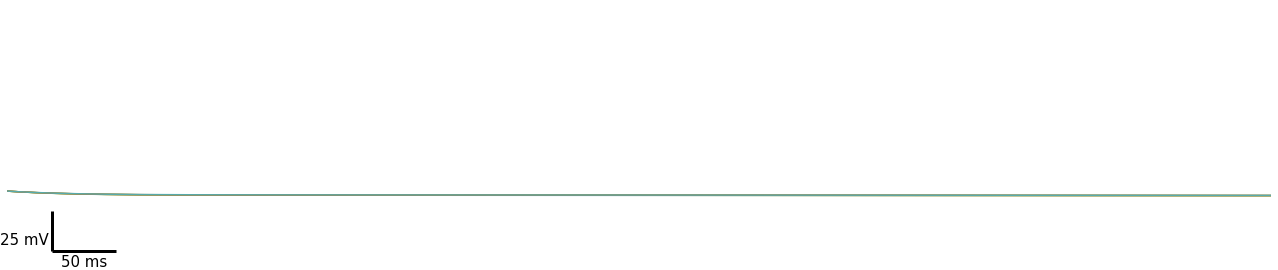



 L6_BP_dST   N = 5
Plotting recorded cell traces ... trace


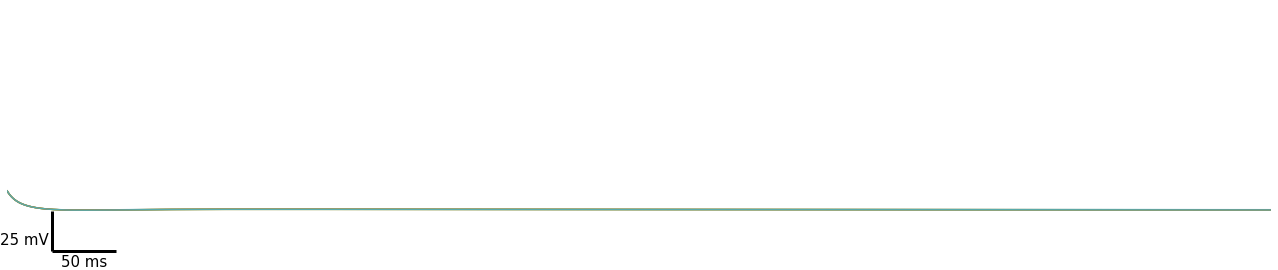



 L6_BTC_bAC   N = 5
Plotting recorded cell traces ... trace


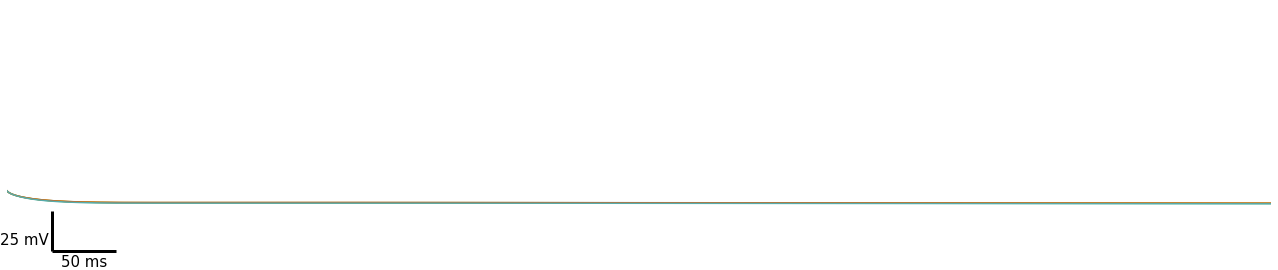



 L6_BTC_cAC   N = 5
Plotting recorded cell traces ... trace


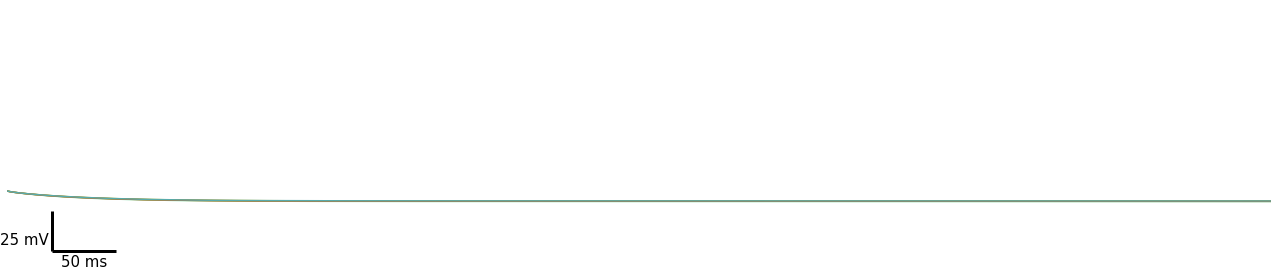



 L6_BTC_cNA   N = 5
Plotting recorded cell traces ... trace


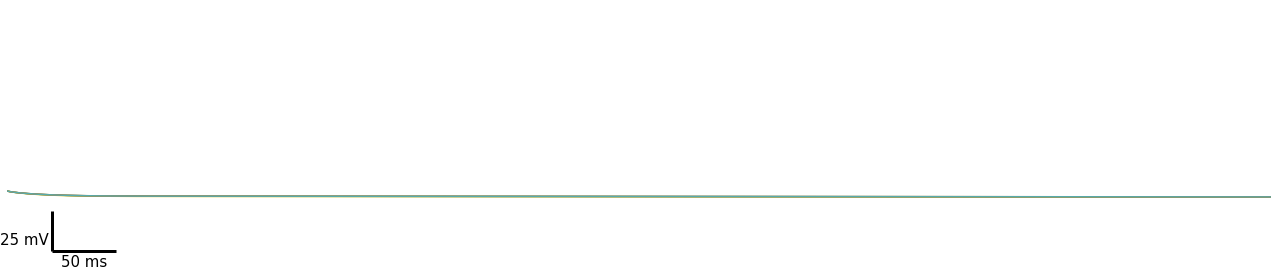



 L6_ChC_cAC   N = 5
Plotting recorded cell traces ... trace


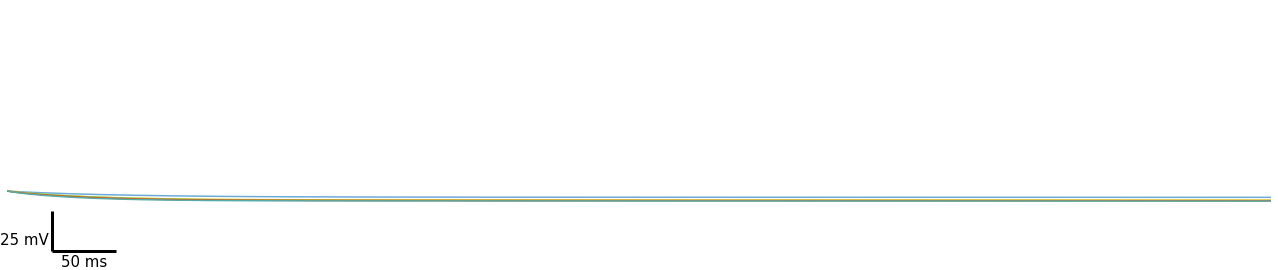



 L6_ChC_cNA   N = 5
Plotting recorded cell traces ... trace


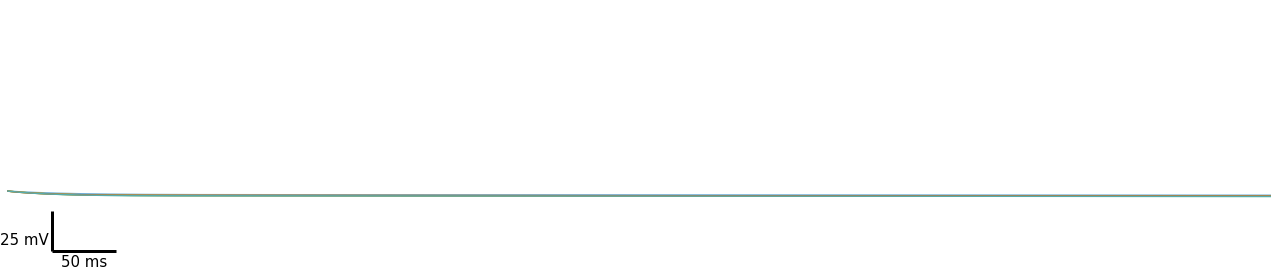



 L6_ChC_dNA   N = 4
Plotting recorded cell traces ... trace


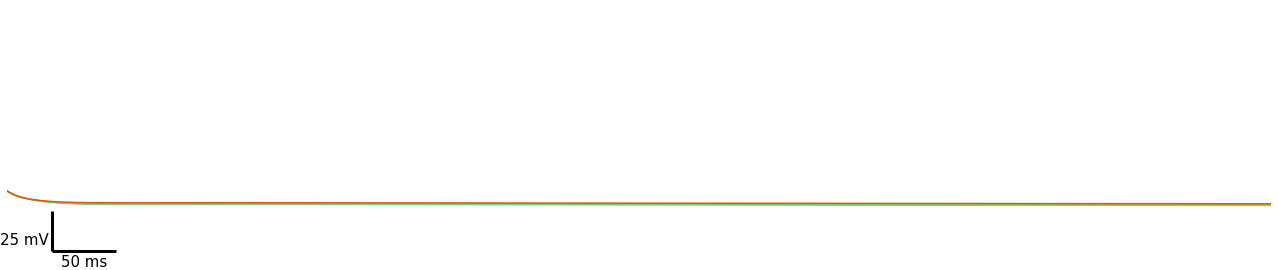



 L6_DBC_bAC   N = 3
Plotting recorded cell traces ... trace


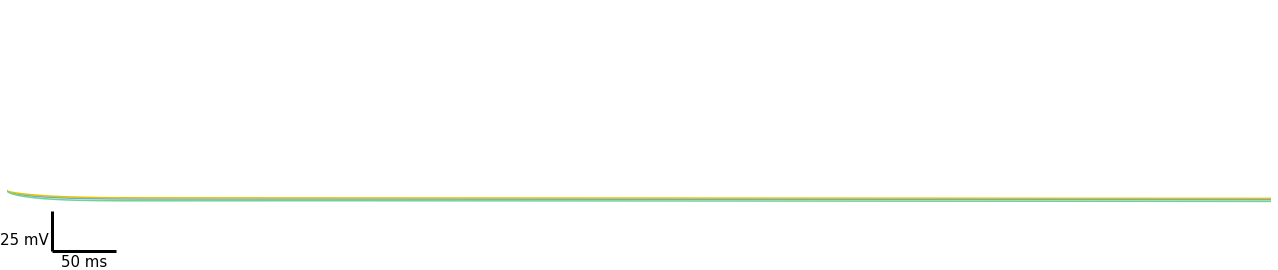



 L6_DBC_bIR   N = 5
Plotting recorded cell traces ... trace


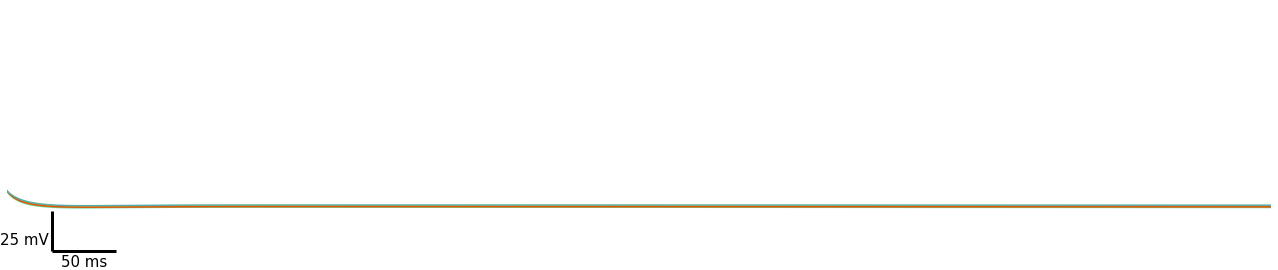



 L6_DBC_bNA   N = 3
Plotting recorded cell traces ... trace


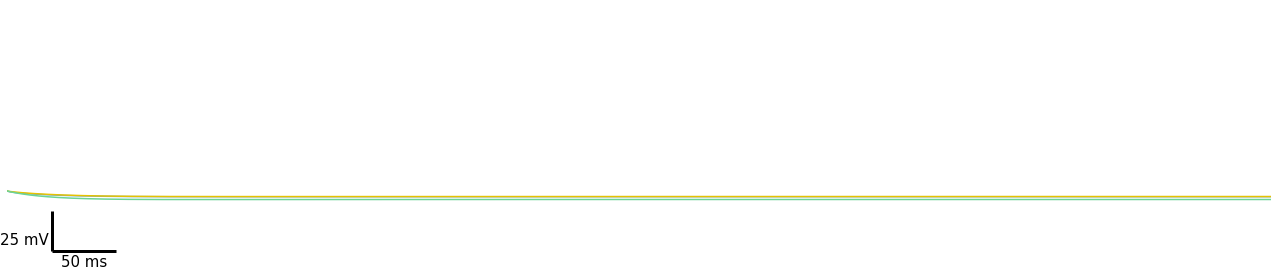



 L6_DBC_bST   N = 3
Plotting recorded cell traces ... trace


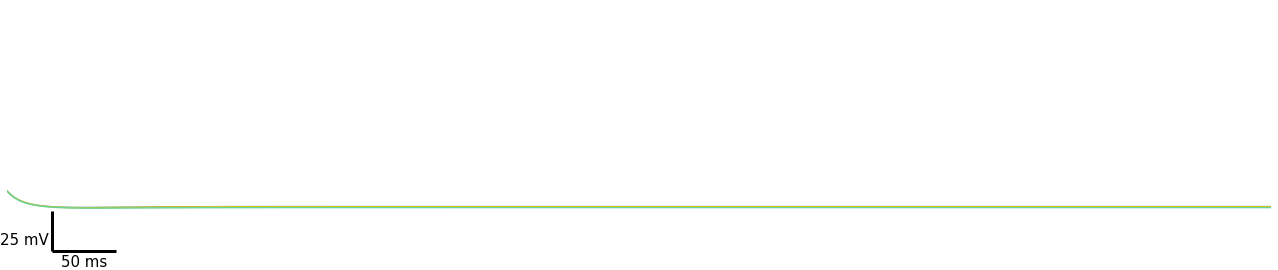



 L6_DBC_cAC   N = 3
Plotting recorded cell traces ... trace


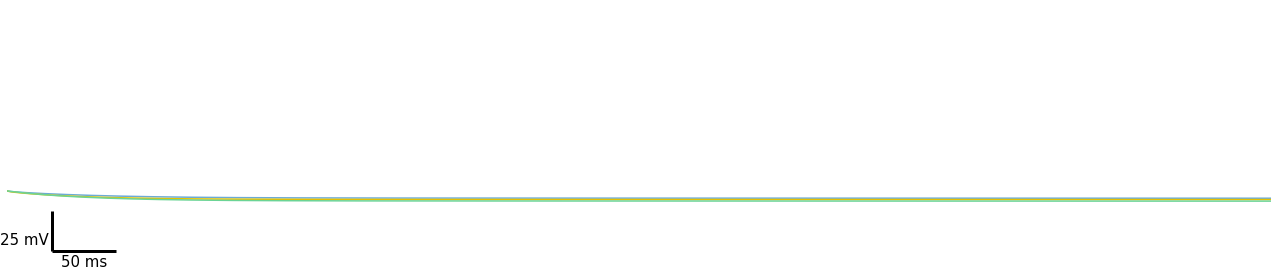



 L6_DBC_cIR   N = 5
Plotting recorded cell traces ... trace


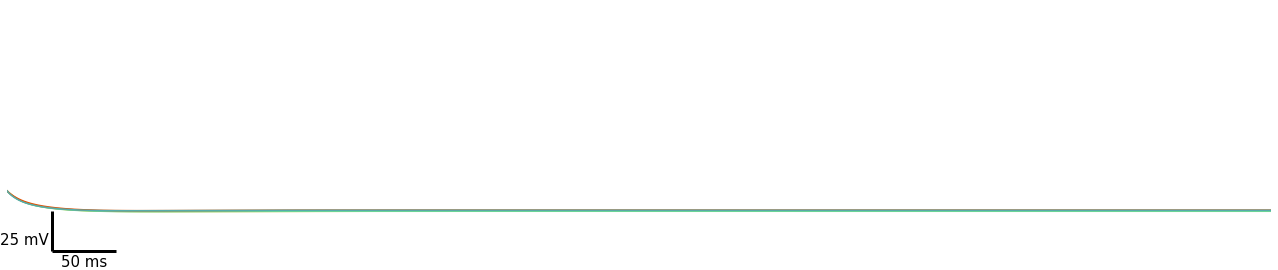



 L6_DBC_cNA   N = 3
Plotting recorded cell traces ... trace


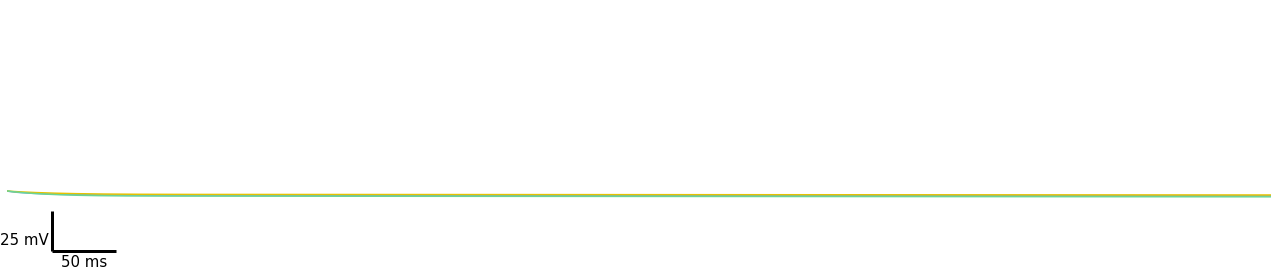



 L6_IPC_cAD   N = 5
Plotting recorded cell traces ... trace


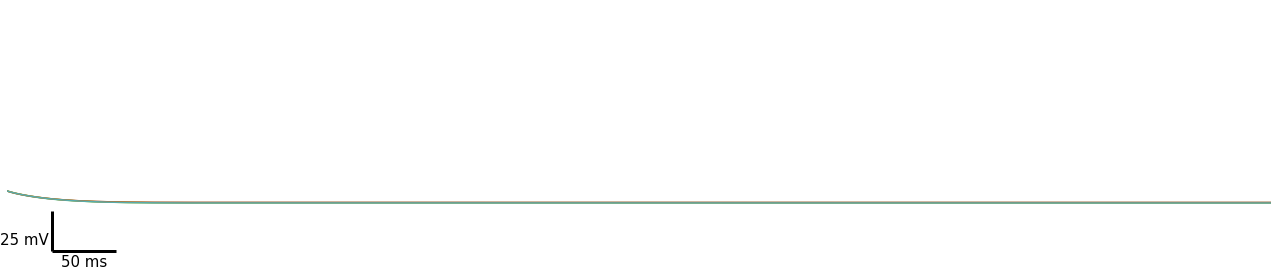



 L6_LBC_bAC   N = 5
Plotting recorded cell traces ... trace


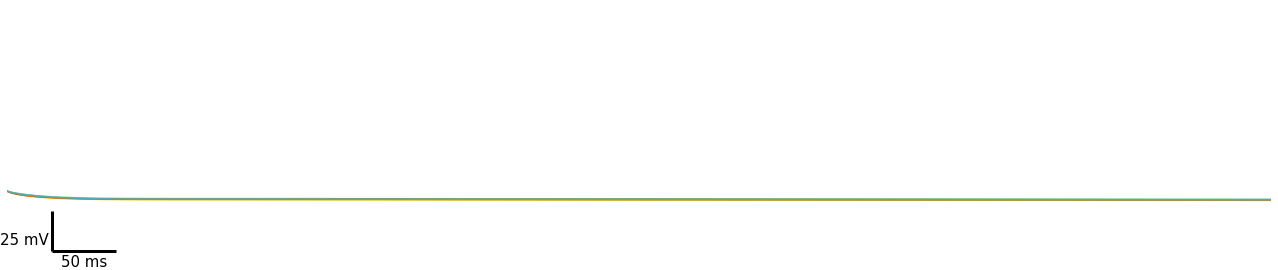



 L6_LBC_bIR   N = 5
Plotting recorded cell traces ... trace


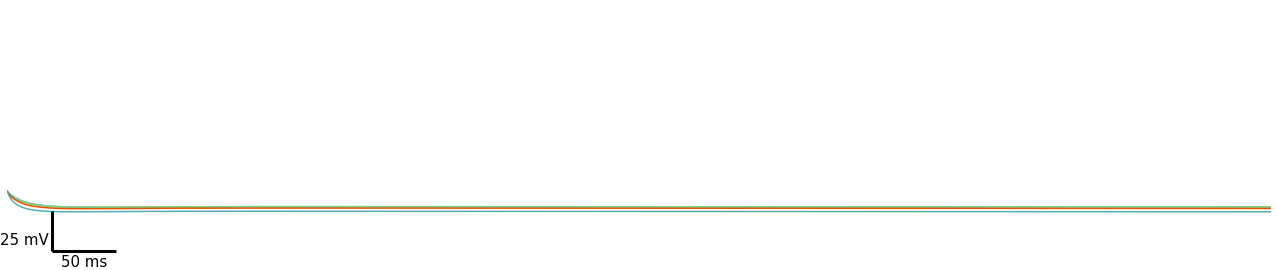



 L6_LBC_bNA   N = 5
Plotting recorded cell traces ... trace


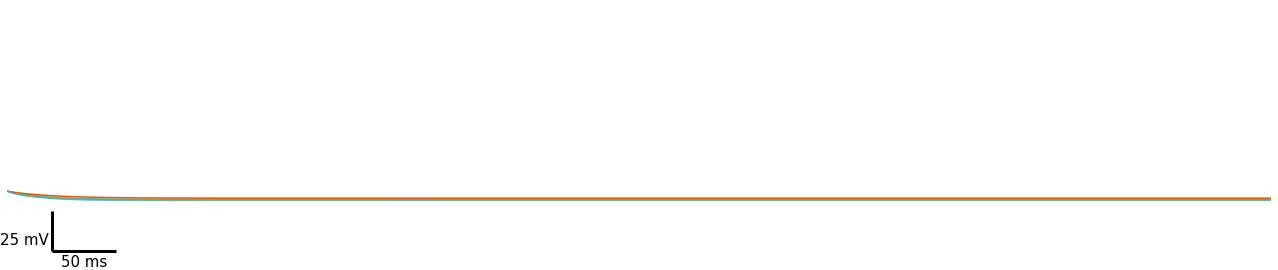



 L6_LBC_bST   N = 5
Plotting recorded cell traces ... trace


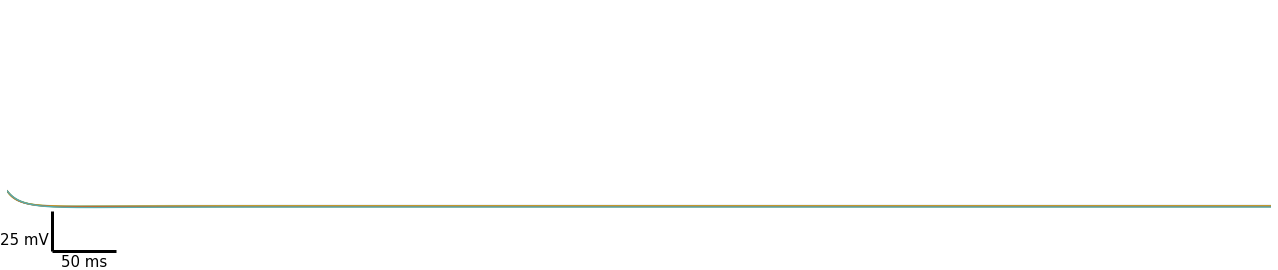



 L6_LBC_cNA   N = 5
Plotting recorded cell traces ... trace


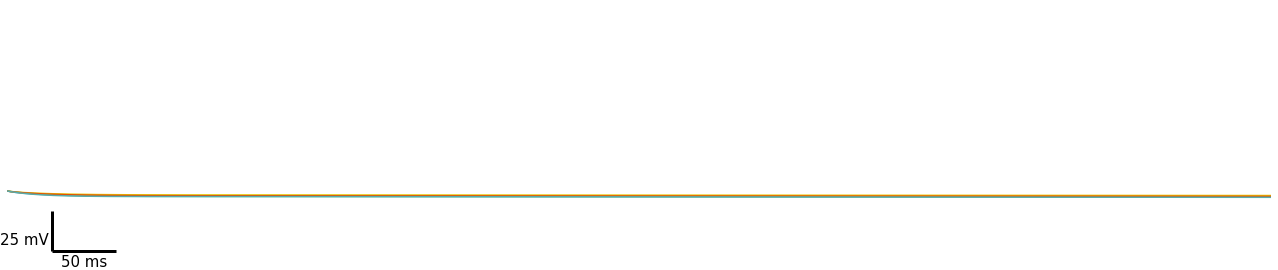



 L6_LBC_cST   N = 5
Plotting recorded cell traces ... trace


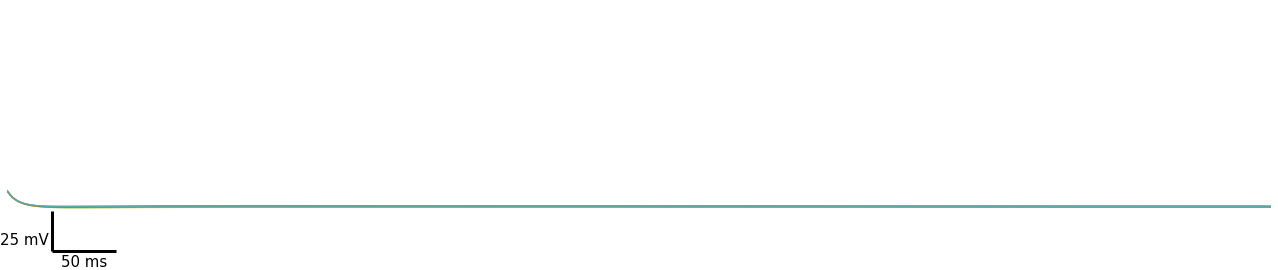



 L6_MC_bAC   N = 5
Plotting recorded cell traces ... trace


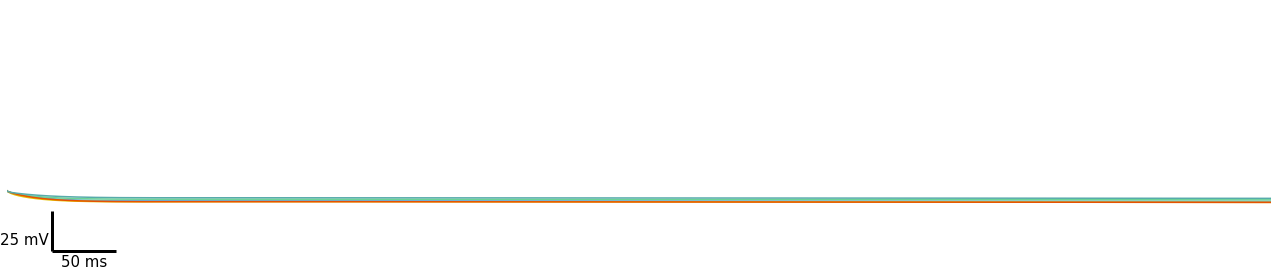



 L6_MC_bIR   N = 5
Plotting recorded cell traces ... trace


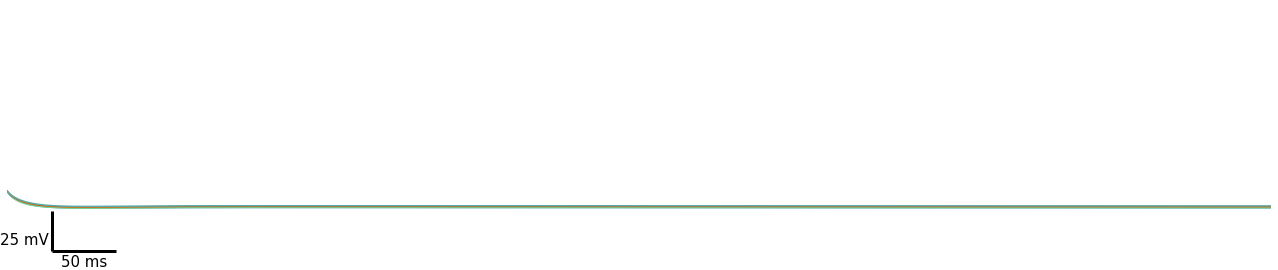



 L6_MC_bNA   N = 5
Plotting recorded cell traces ... trace


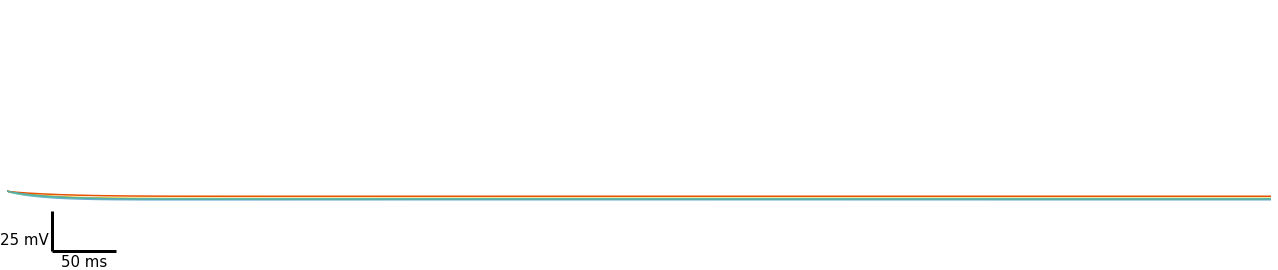



 L6_MC_bST   N = 5
Plotting recorded cell traces ... trace


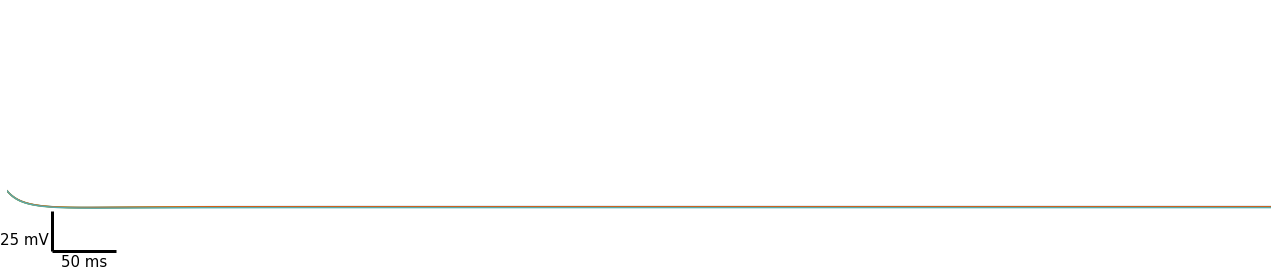



 L6_MC_cAC   N = 5
Plotting recorded cell traces ... trace


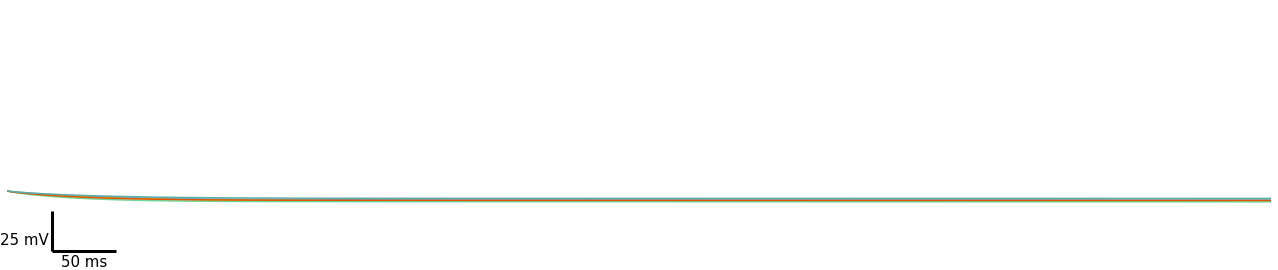



 L6_MC_cIR   N = 5
Plotting recorded cell traces ... trace


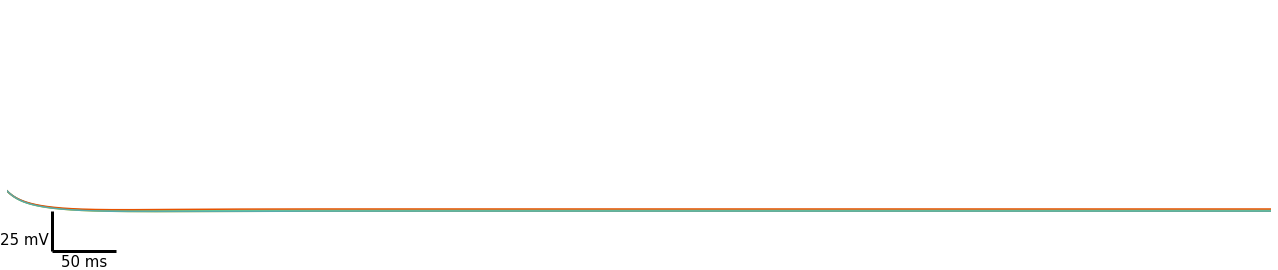



 L6_MC_cNA   N = 5
Plotting recorded cell traces ... trace


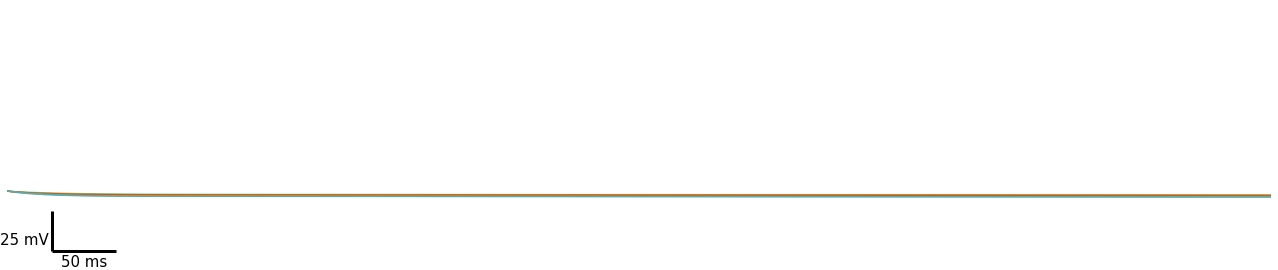



 L6_NBC_bAC   N = 5
Plotting recorded cell traces ... trace


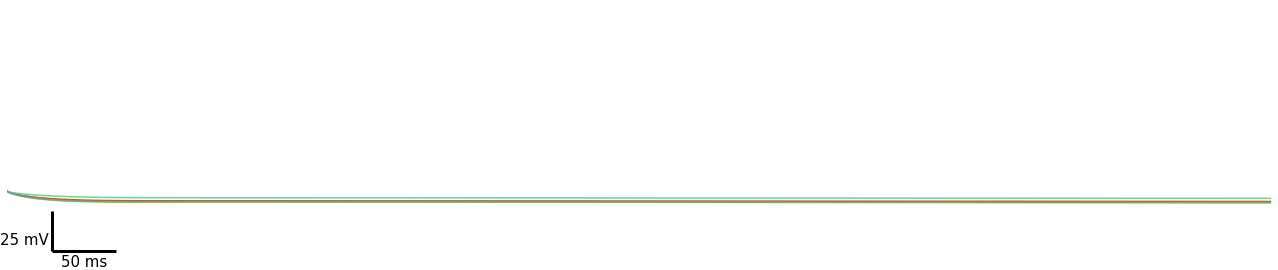



 L6_NBC_bIR   N = 5
Plotting recorded cell traces ... trace


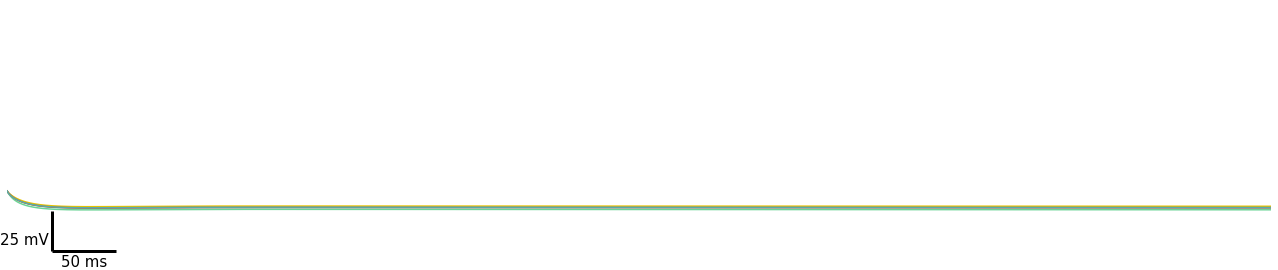



 L6_NBC_bST   N = 5
Plotting recorded cell traces ... trace


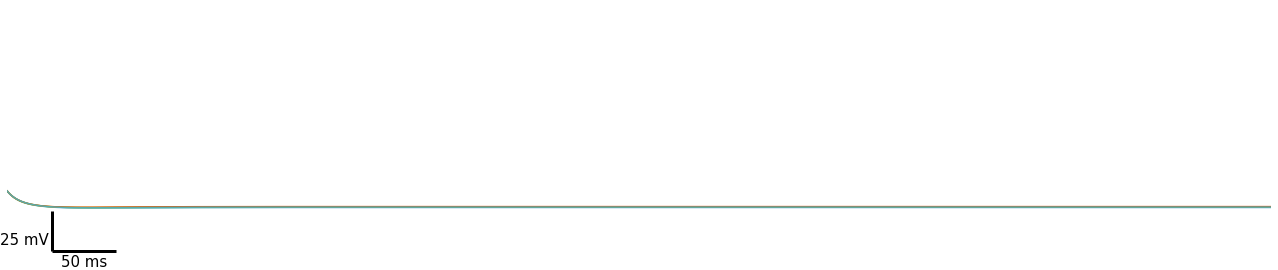



 L6_NBC_cAC   N = 5
Plotting recorded cell traces ... trace


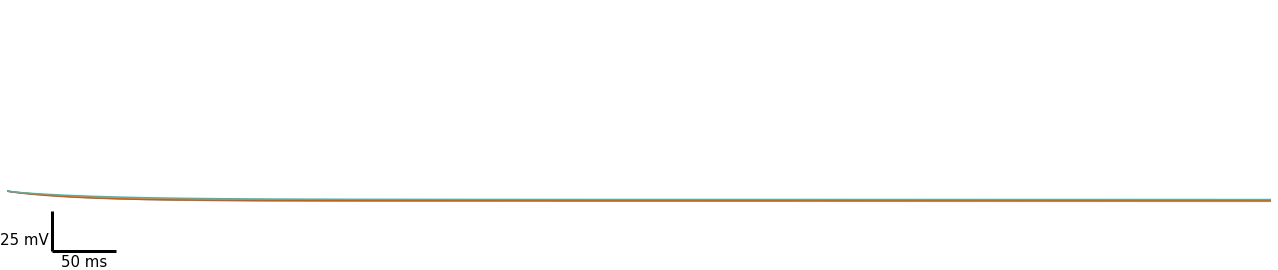



 L6_NBC_cIR   N = 5
Plotting recorded cell traces ... trace


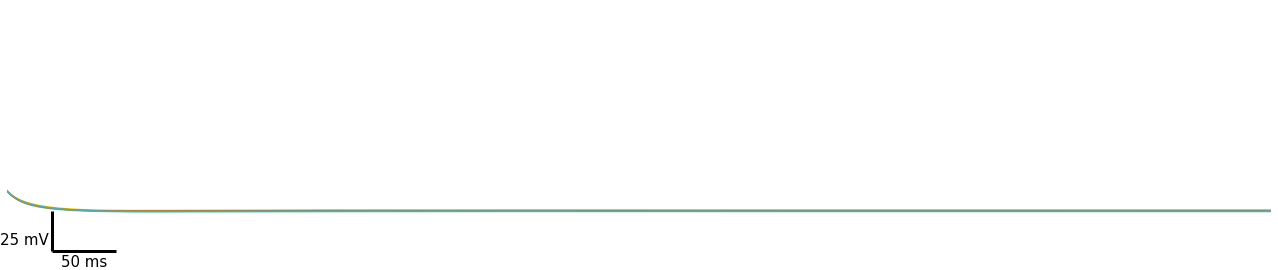



 L6_NBC_cNA   N = 5
Plotting recorded cell traces ... trace


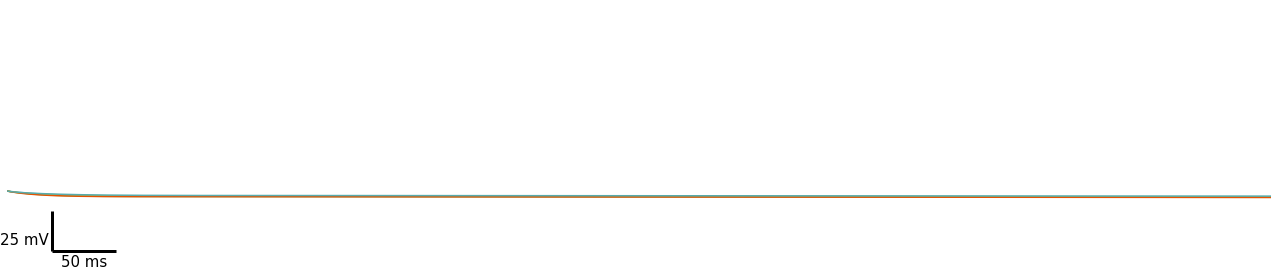



 L6_NBC_cST   N = 5
Plotting recorded cell traces ... trace


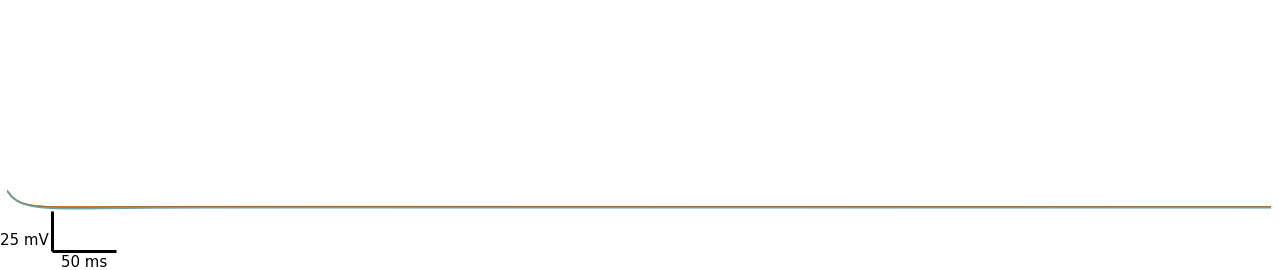



 L6_NBC_dST   N = 5
Plotting recorded cell traces ... trace


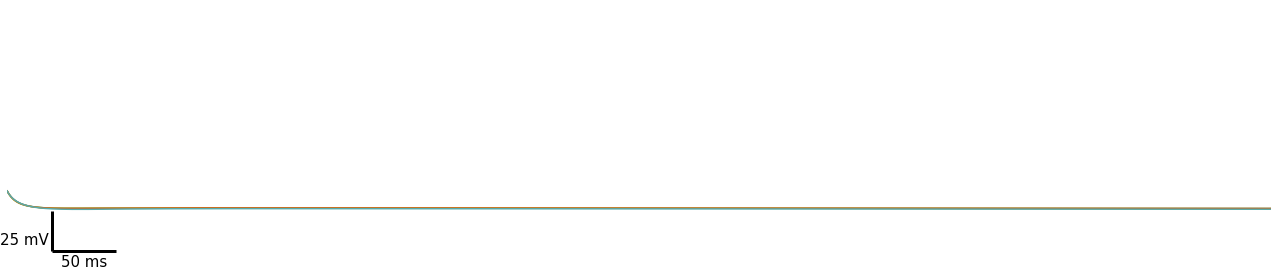



 L6_NGC_bNA   N = 2
Plotting recorded cell traces ... trace


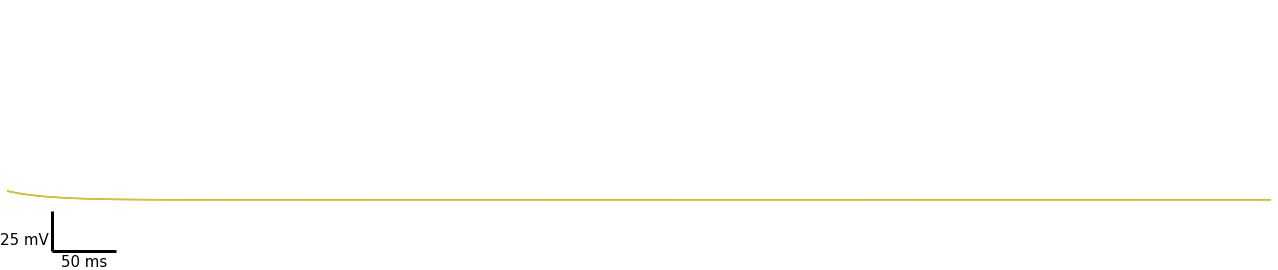



 L6_NGC_cAC   N = 2
Plotting recorded cell traces ... trace


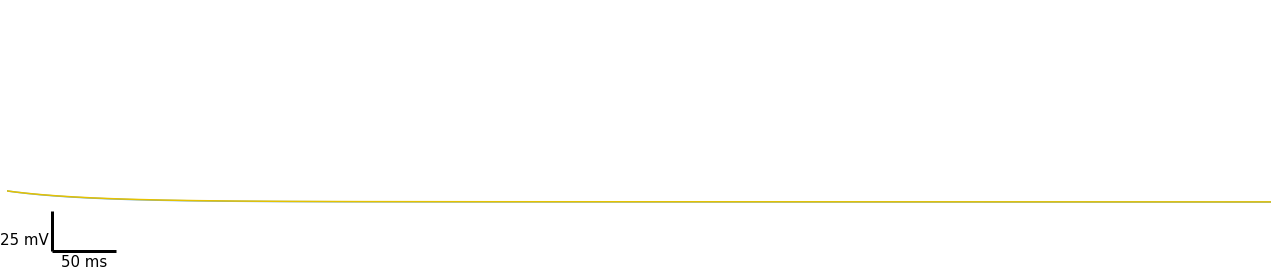



 L6_NGC_cNA   N = 5
Plotting recorded cell traces ... trace


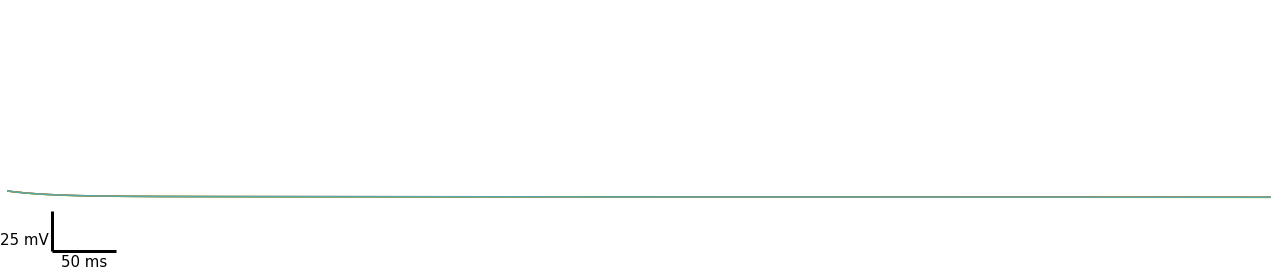



 L6_NGC_cST   N = 2
Plotting recorded cell traces ... trace


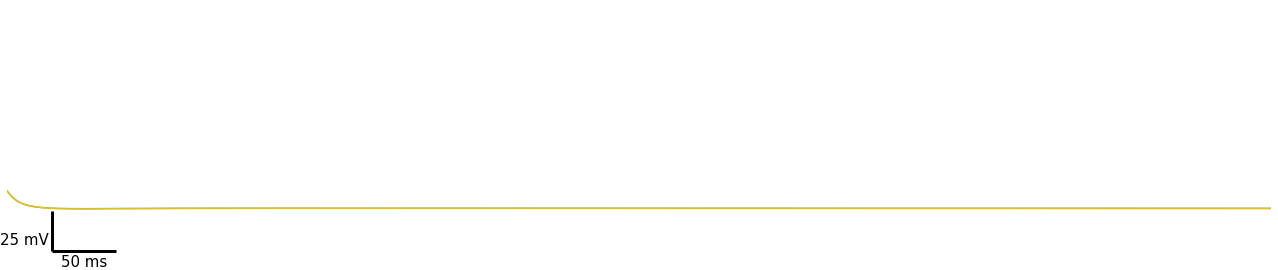



 L6_SBC_bNA   N = 5
Plotting recorded cell traces ... trace


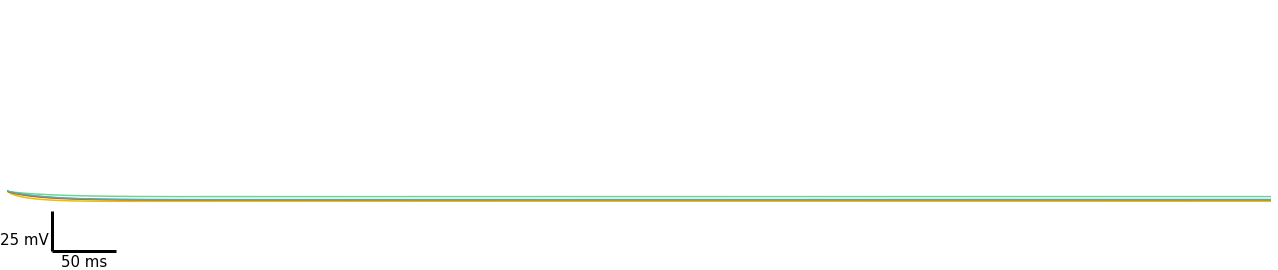



 L6_SBC_cAC   N = 5
Plotting recorded cell traces ... trace


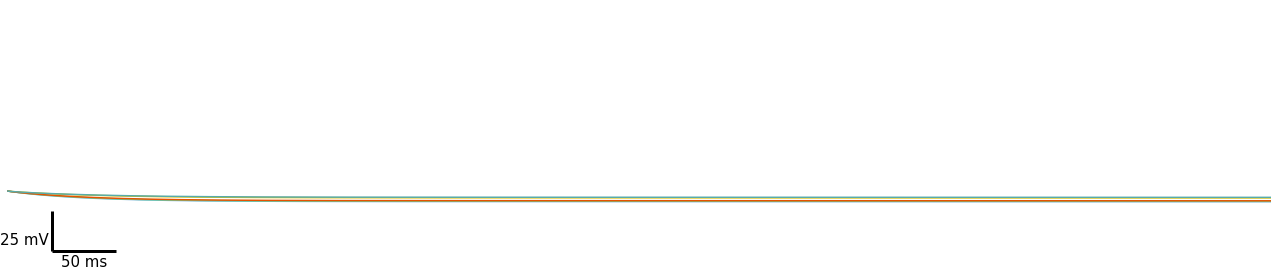



 L6_SBC_dNA   N = 5
Plotting recorded cell traces ... trace


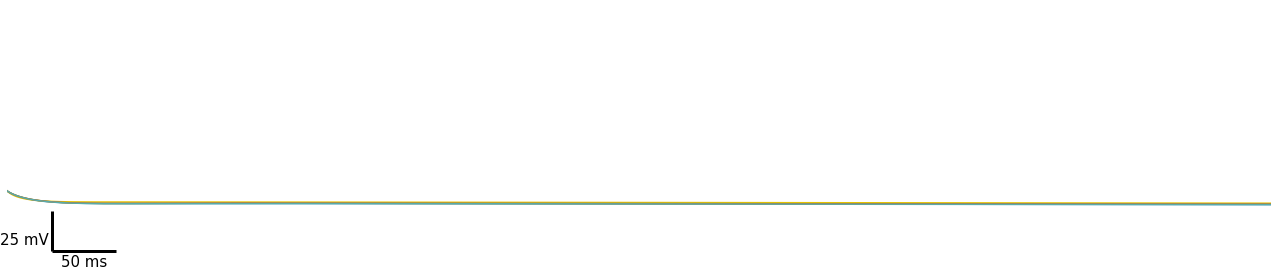



 L6_TPC_L1_cAD   N = 5
Plotting recorded cell traces ... trace


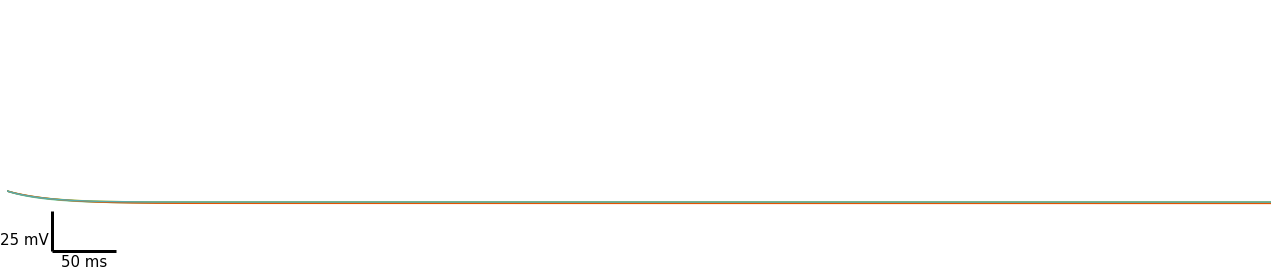



 L6_TPC_L4_cAD   N = 5
Plotting recorded cell traces ... trace


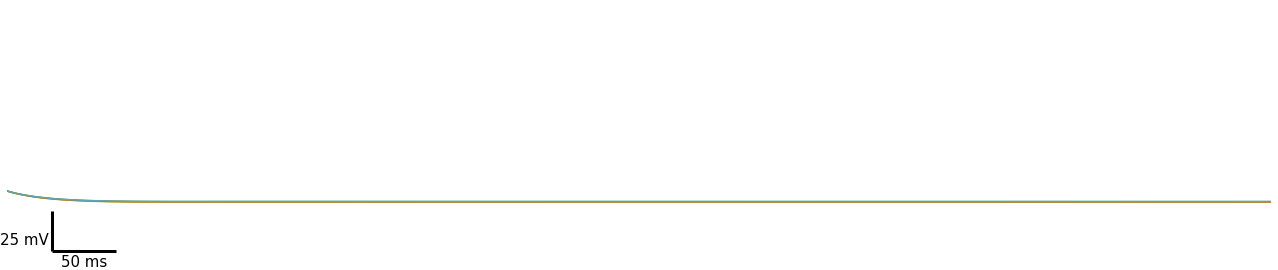



 L6_UTPC_cAD   N = 5
Plotting recorded cell traces ... trace


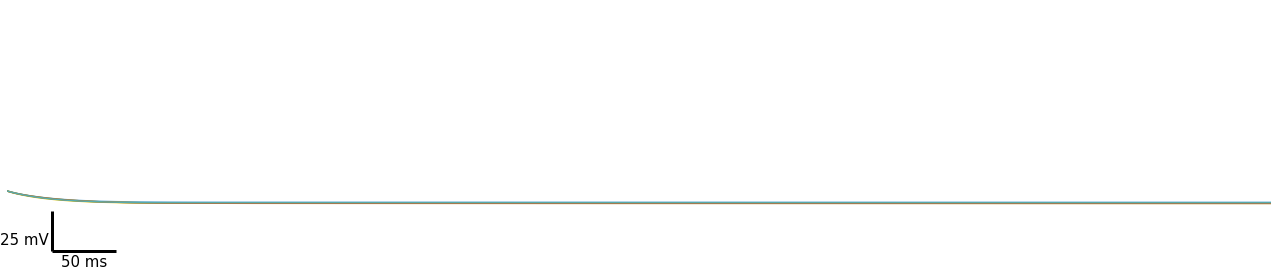

In [ ]:
for pops in cfg.cellParamLabels:
    print('\n\n',pops,'  N =',cfg.cellNumber[pops])
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-110,50], axis=False, scaleBarLoc=3, figSize=(18, 4), fontSize=15, saveFig='../info/test/'+cfg.simLabel+'/'+cfg.simLabel +'_'+pops+ '_Vt.png');

In [ ]:
netParams.cellParams.keys()

odict_keys(['L1_DAC_bNAC219_1', 'L1_DAC_bNAC219_2', 'L1_DAC_bNAC219_3', 'L1_DAC_bNAC219_4', 'L1_DAC_bNAC219_5', 'L1_DAC_cNAC187_1', 'L1_DAC_cNAC187_2', 'L1_DAC_cNAC187_3', 'L1_DAC_cNAC187_4', 'L1_DAC_cNAC187_5', 'L1_DLAC_cNAC187_1', 'L1_DLAC_cNAC187_2', 'L1_DLAC_cNAC187_3', 'L1_DLAC_cNAC187_4', 'L1_DLAC_cNAC187_5', 'L1_HAC_bNAC219_1', 'L1_HAC_bNAC219_2', 'L1_HAC_bNAC219_3', 'L1_HAC_bNAC219_4', 'L1_HAC_bNAC219_5', 'L1_HAC_cIR216_1', 'L1_HAC_cIR216_2', 'L1_HAC_cIR216_3', 'L1_HAC_cIR216_4', 'L1_HAC_cIR216_5', 'L1_HAC_cNAC187_1', 'L1_HAC_cNAC187_2', 'L1_HAC_cNAC187_3', 'L1_HAC_cNAC187_4', 'L1_HAC_cNAC187_5', 'L1_NGC-DA_bNAC219_1', 'L1_NGC-DA_bNAC219_2', 'L1_NGC-DA_bNAC219_3', 'L1_NGC-DA_bNAC219_4', 'L1_NGC-DA_bNAC219_5', 'L1_NGC-DA_cACint209_1', 'L1_NGC-DA_cACint209_2', 'L1_NGC-DA_cACint209_3', 'L1_NGC-DA_cACint209_4', 'L1_NGC-DA_cACint209_5', 'L1_NGC-DA_cNAC187_1', 'L1_NGC-DA_cNAC187_2', 'L1_NGC-DA_cNAC187_3', 'L1_NGC-DA_cNAC187_4', 'L1_NGC-DA_cNAC187_5', 'L1_NGC-DA_cSTUT189_1', 'L1_NGC-D

Plotting recorded cell traces ... trace


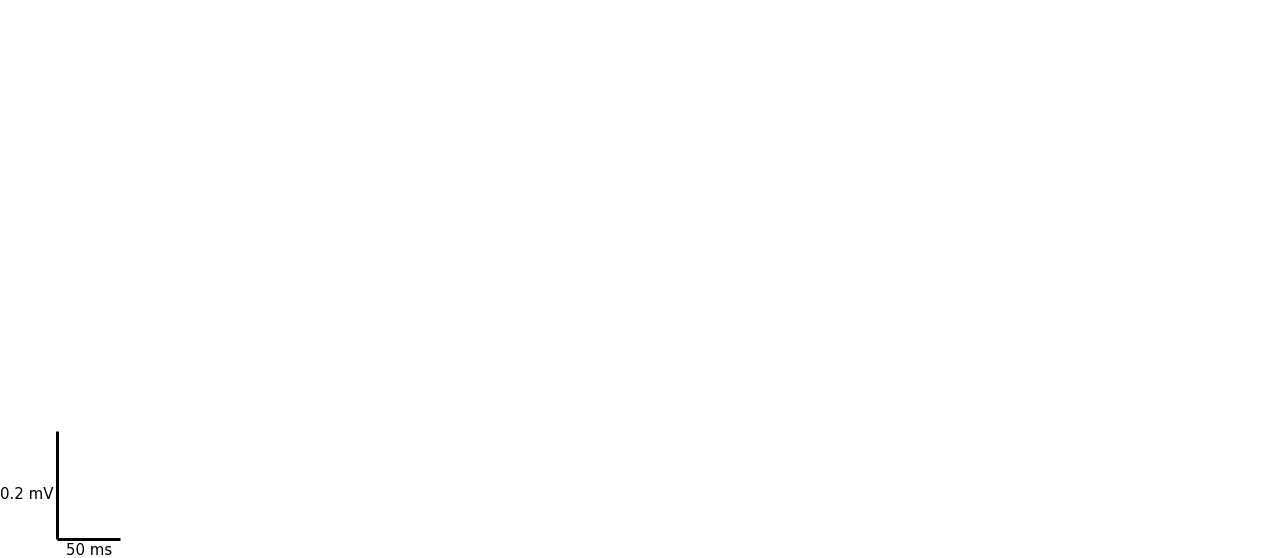

In [ ]:
 sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-75,-74], axis=False, scaleBarLoc=3, figSize=(18, 8), fontSize=15, saveFig='../info/test/'+cfg.simLabel+'/'+cfg.simLabel +'_'+pops+ '_Vt.png');